# Team Based Model

## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.data.make_team_dataset import load_team_data


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV, LogisticRegression, ElasticNet
from sklearn.linear_model import Ridge, Lasso, SGDRegressor
from sklearn.pipeline import make_pipeline

import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import LinearSVR, SVC
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import confusion_matrix

In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-

In [2]:
pd.options.display.max_columns=230
pd.options.display.max_rows=100

## Gather Team Level Basic, Advanced, and Scoring Data

In [3]:
team_data = load_team_data()

In [4]:
from src.data.make_team_dataset import clean_team_data

clean_team_df = clean_team_data(team_data)



In [5]:
clean_team_df

SEASON_YEAR  SEASON_ID     TEAM_ID TEAM_ABBREVIATION  \
0         2000-01      22000  1610612745               HOU   
1         2000-01      22000  1610612750               MIN   
2         2000-01      22000  1610612751               BKN   
3         2000-01      22000  1610612739               CLE   
4         2000-01      22000  1610612754               IND   
...           ...        ...         ...               ...   
51343     2019-20      42019  1610612747               LAL   
51344     2019-20      42019  1610612748               MIA   
51345     2019-20      42019  1610612747               LAL   
51346     2019-20      42019  1610612748               MIA   
51347     2019-20      42019  1610612747               LAL   

                    TEAM_NAME   GAME_ID  GAME_DATE      MATCHUP  WL  MIN  FGM  \
0             Houston Rockets  20000008 2000-10-31  HOU vs. MIN   0  240   34   
1      Minnesota Timberwolves  20000008 2000-10-31    MIN @ HOU   1  240   43   
2             New Jersey Nets  20000002 2000-10-31  BKN vs. CLE   0  240   31   
3         Cleveland Cavaliers  20000002 2000-10-31    CLE @ BKN   1  240   32   
4              Indiana Pacers  20000009 2000-10-31    IND @ SAS   0  240   36   
...                       ...       ...        ...          ...  ..  ...  ...   
51343      Los Angeles Lakers  41900404 2020-10-06    LAL @ MIA   1  240   35   
51344              Miami Heat  41900405 2020-10-09    MIA @ LAL   1  240   38   
51345      Los Angeles Lakers  41900405 2020-10-09  LAL vs. MIA   0  240   38   
51346              Miami Heat  41900406 2020-10-11  MIA vs. LAL   0  240   35   
51347      Los Angeles Lakers  41900406 2020-10-11    LAL @ MIA   1  240   43   

       FGA  FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  \
0       74   0.459     2     9    0.222   28   40   0.700    11    27   38   
1       88   0.489     6    11    0.545   14   16   0.875    13    31   44   
2       85   0.365     3    10    0.300   17   26   0.654    12    35   47   
3       78   0.410     2     7    0.286   20   32   0.625    11    41   52   
4       80   0.450     4    17    0.235    9   13   0.692     9    26   35   
...    ...     ...   ...   ...      ...  ...  ...     ...   ...   ...  ...   
51343   79   0.443    14    39    0.359   18   21   0.857    10    32   42   
51344   83   0.458    14    33    0.424   21   22   0.955     9    26   35   
51345   82   0.463    14    38    0.368   18   21   0.857    12    29   41   
51346   79   0.443    10    28    0.357   13   22   0.591     9    32   41   
51347   89   0.483    11    35    0.314    9   14   0.643    12    34   46   

       AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0       18    9    7   18  17   98          -8          99.4       103.2   
1       29    7    1   16  25  106           8         108.1       110.4   
2       24    9    8   15  31   82          -4          82.5        83.7   
3       16    5    8   19  27   86           4          85.9        87.8   
4       19    5    4   17  32   85         -13          90.7        90.4   
...    ...  ...  ...  ...  ..  ...         ...           ...         ...   
51343   25    5    4   15  14  102           6         109.4       110.9   
51344   26    7    3   13  19  111           3         114.8       119.4   
51345   21   10    5   15  21  108          -3         114.6       114.9   
51346   25    4    4   15  18   93         -13          98.2       100.0   
51347   23    5    4   14  22  106          13         109.1       112.8   

       E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  \
0             108.1       110.4          -8.7        -7.3    0.529     1.00   
1              99.4       103.2           8.7         7.3    0.674     1.81   
2              85.9        87.8          -3.5        -4.1    0.774     1.60   
3              82.5        83.7           3.5         4.1    0.500     0.84   
4             106.1       104.3         -15

In [6]:
from src.data.make_team_dataset import prep_for_aggregation
ready_for_agg_df = prep_for_aggregation(clean_team_df)
ready_for_agg_df

SEASON_YEAR  SEASON_ID     TEAM_ID TEAM_ABBREVIATION  \
0         2000-01      22000  1610612745               HOU   
1         2000-01      22000  1610612750               MIN   
2         2000-01      22000  1610612751               BKN   
3         2000-01      22000  1610612739               CLE   
4         2000-01      22000  1610612754               IND   
...           ...        ...         ...               ...   
51343     2019-20      42019  1610612747               LAL   
51344     2019-20      42019  1610612748               MIA   
51345     2019-20      42019  1610612747               LAL   
51346     2019-20      42019  1610612748               MIA   
51347     2019-20      42019  1610612747               LAL   

                    TEAM_NAME   GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  \
0             Houston Rockets  20000008 2000-10-31  HOU vs. MIN          1   
1      Minnesota Timberwolves  20000008 2000-10-31    MIN @ HOU          0   
2             New Jersey Nets  20000002 2000-10-31  BKN vs. CLE          1   
3         Cleveland Cavaliers  20000002 2000-10-31    CLE @ BKN          0   
4              Indiana Pacers  20000009 2000-10-31    IND @ SAS          0   
...                       ...       ...        ...          ...        ...   
51343      Los Angeles Lakers  41900404 2020-10-06    LAL @ MIA          0   
51344              Miami Heat  41900405 2020-10-09    MIA @ LAL          0   
51345      Los Angeles Lakers  41900405 2020-10-09  LAL vs. MIA          1   
51346              Miami Heat  41900406 2020-10-11  MIA vs. LAL          1   
51347      Los Angeles Lakers  41900406 2020-10-11    LAL @ MIA          0   

       TEAM_SCORE  point_diff  WL  MIN  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  \
0              98          -8   0  240       0    32    65     2     9   28   
1             106           8   1  240       1    37    77     6    11   14   
2              82          -4   0  240       0    28    75     3    10   17   
3              86           4   1  240       1    30    71     2     7   20   
4              85         -13   0  240       0    32    63     4    17    9   
...           ...         ...  ..  ...     ...   ...   ...   ...   ...  ...   
51343         102           6   1  240       1    21    40    14    39   18   
51344         111           3   1  240       1    24    50    14    33   21   
51345         108          -3   0  240       0    24    44    14    38   18   
51346          93         -13   0  240       0    25    51    10    28   13   
51347         106          13   1  240       1    32    54    11    35    9   

       FTA  OREB  DREB  REB  AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  \
0       40    11    27   38   18    9    7   18  17   98          -8   
1       16    13    31   44   29    7    1   16  25  106           8   
2       26    12    35   47   24    9    8   15  31   82          -4   
3       32    11    41   52   16    5    8   19  27   86           4   
4       13     9    26   35   19    5    4   17  32   85         -13   
...    ...   ...   ...  ...  ...  ...  ...  ...  ..  ...         ...   
51343   21    10    32   42   25    5    4   15  14  102           6   
51344   22     9    26   35   26    7    3   13  19  111           3   
51345   21    12    29   41   21   10    5   15  21  108          -3   
51346   22     9    32   41   25    4    4   15  18   93         -13   
51347   14    12    34   46   23    5    4   14  22  106          13   

       E_OFF_RATING  OFF_RATING  E_DEF_RATING  DEF_RATING  E_NET_RATING  \
0              99.4       103.2         108.1       110.4          -8.7   
1             108.1       110.4          99.4       103.2           8.7   
2              82.5        83.7          85.9        87.8          -3.5   
3              85.9        87.8          82.5        83.7           3.5   
4              90.7        90.4         106.1       104.3         -15.4   
...             ...         ...           ...         ...   

In [7]:
from src.data.make_team_dataset import create_matchups

matchups = create_matchups(ready_for_agg_df)
matchups

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
1               2000-01           22000    1610612745                    HOU   
2               2000-01           22000    1610612750                    MIN   
5               2000-01           22000    1610612751                    BKN   
6               2000-01           22000    1610612739                    CLE   
9               2000-01           22000    1610612754                    IND   
...                 ...             ...           ...                    ...   
102678          2019-20           42019    1610612747                    LAL   
102681          2019-20           42019    1610612748                    MIA   
102682          2019-20           42019    1610612747                    LAL   
102685          2019-20           42019    1610612748                    MIA   
102686          2019-20           42019    1610612747                    LAL   

                TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
1              Houston Rockets  20000008     2000-10-31  HOU vs. MIN   
2       Minnesota Timberwolves  20000008     2000-10-31    MIN @ HOU   
5              New Jersey Nets  20000002     2000-10-31  BKN vs. CLE   
6          Cleveland Cavaliers  20000002     2000-10-31    CLE @ BKN   
9               Indiana Pacers  20000009     2000-10-31    IND @ SAS   
...                        ...       ...            ...          ...   
102678      Los Angeles Lakers  41900404     2020-10-06    LAL @ MIA   
102681              Miami Heat  41900405     2020-10-09    MIA @ LAL   
102682      Los Angeles Lakers  41900405     2020-10-09  LAL vs. MIA   
102685              Miami Heat  41900406     2020-10-11  MIA vs. LAL   
102686      Los Angeles Lakers  41900406     2020-10-11    LAL @ MIA   

        HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  MIN_team  \
1                    1               98               -8        0       240   
2                    0              106                8        1       240   
5                    1               82               -4        0       240   
6                    0               86                4        1       240   
9                    0               85              -13        0       240   
...                ...              ...              ...      ...       ...   
102678               0              102                6        1       240   
102681               0              111                3        1       240   
102682               1              108               -3        0       240   
102685               1               93              -13        0       240   
102686               0              106               13        1       240   

        RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team  FTM_team  \
1                 0         32         65          2          9        28   
2                 1         37         77          6         11        14   
5                 0         28         75          3         10        17   
6                 1         30         71          2          7        20   
9                 0         32         63          4         17         9   
...             ...        ...        ...        ...        ...       ...   
102678            1         21         40         14         39        18   
102681            1         24         50         14         33        21   
102682            0         24         44         14         38        18   
102685            0         25         51         10         28        13   
102686            1         32         54         11         35         9   

        FTA_team  OREB_team  DREB_team  REB_team  AST_team  STL_team  \
1             40         11         27        38        18         9   
2             16         13         31        44        29         7   
5             26         12         35        47        24         9   
6             32   

In [10]:
test = matchups.loc[(matchups['SEASON_YEAR_team'] == '2000-01') & (matchups['TEAM_ABBREVIATION_team'] == 'HOU')].sort_values('GAME_DATE_team')
test['FG3M_2_avg'] = test['FG3M_team'].expanding().mean()
test['FG3M_2_SMA_2'] = test['FG3M_team'].rolling(window=2).mean()
test['FG3M_2'] = test['FG3M_team'].ewm(span=2, adjust=True).mean()
test['FG3M_3'] = test['FG3M_team'].ewm(span=1.5, adjust=True).mean()
test['FG3M_19'] = test['FG3M_team'].ewm(span=19, adjust=True).mean()
test['FG3M_10'] = test['FG3M_team'].ewm(span=10, adjust=True).mean()

test[['FG3M_team', 'FG3M_2_avg', 'FG3M_2_SMA_2', 'FG3M_2', 'FG3M_3', 'FG3M_10', 'FG3M_19']].head(10)
# test['FG3M_team']

FG3M_team  FG3M_2_avg  FG3M_2_SMA_2    FG3M_2     FG3M_3   FG3M_10  \
1            2    2.000000           NaN  2.000000   2.000000  2.000000   
85          12    7.000000           7.0  9.500000  10.333333  7.500000   
182          5    6.333333           8.5  6.384615   6.032258  6.495017   
193          6    6.250000           5.5  6.125000   6.006410  6.331931   
217          4    5.800000           5.0  4.702479   4.400768  5.662497   
290          5    5.666667           4.5  4.901099   4.880184  5.490424   
365          2    5.142857           3.5  2.966148   2.576007  4.649372   
386          4    5.000000           3.0  3.655488   3.715204  4.501636   
409          8    5.333333           6.0  6.551976   7.143043  5.262758   
473          2    5.000000           5.0  3.517274   3.028608  4.577396   

      FG3M_19  
1    2.000000  
85   7.263158  
182  6.428044  
193  6.303577  
217  5.741056  
290  5.582900  
365  4.896130  
386  4.738785  
409  5.271159  
473  4.768925

In [9]:
def get_team_and_opp_ewm(df, min_periods=5, span=19, adjust=True):
    df = df.copy()

    df = df.drop(columns = ['SEASON_YEAR_opp', 'SEASON_ID_opp', 
                            'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp',
                            'TEAM_NAME_opp', 'GAME_DATE_opp', 
                            'MATCHUP_opp', 'WL_opp', 'HOME_GAME_opp',
                           'point_diff_opp'])

    team_dfs = []
    for season in tqdm(df['SEASON_YEAR_team'].unique(), desc='Progress'):
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            team_df.iloc[:, 12:] = team_df.iloc[:, 12:].shift(1).ewm(span = span, min_periods=min_periods).mean()
            team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df

avg_data_ewm_19 = get_team_and_opp_ewm(matchups, min_periods=5, span=19)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.09it/s]


In [11]:
from src.data.make_team_dataset import get_team_and_opp_avg
avg_data = get_team_and_opp_avg(matchups)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


In [12]:
avg_data

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0              2000-01           22000    1610612745                    HOU   
1              2000-01           22000    1610612745                    HOU   
2              2000-01           22000    1610612745                    HOU   
3              2000-01           22000    1610612745                    HOU   
4              2000-01           22000    1610612745                    HOU   
...                ...             ...           ...                    ...   
51339          2019-20           22019    1610612740                    NOP   
51340          2019-20           22019    1610612740                    NOP   
51341          2019-20           22019    1610612740                    NOP   
51342          2019-20           22019    1610612740                    NOP   
51343          2019-20           22019    1610612740                    NOP   

             TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0           Houston Rockets  20000008     2000-10-31  HOU vs. MIN   
1           Houston Rockets  20000023     2000-11-02  HOU vs. MIL   
2           Houston Rockets  20000044     2000-11-04    HOU @ LAC   
3           Houston Rockets  20000048     2000-11-05    HOU @ PHX   
4           Houston Rockets  20000058     2000-11-07  HOU vs. LAL   
...                     ...       ...            ...          ...   
51339  New Orleans Pelicans  21901268     2020-08-06    NOP @ SAC   
51340  New Orleans Pelicans  21901278     2020-08-07  NOP vs. WAS   
51341  New Orleans Pelicans  21901287     2020-08-09  NOP vs. SAS   
51342  New Orleans Pelicans  21901302     2020-08-11    NOP @ SAC   
51343  New Orleans Pelicans  21901312     2020-08-13    NOP @ ORL   

       HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  MIN_team  \
0                   1               98               -8        0       NaN   
1                   1              115               22        1       NaN   
2                   0               74               -3        0       NaN   
3                   0               99               -5        0       NaN   
4                   1               84               10        1       NaN   
...               ...              ...              ...      ...       ...   
51339               0              125              -15        0     242.5   
51340               1              118               11        1     242.5   
51341               1              113               -9        0     242.5   
51342               0              106               -6        0     242.5   
51343               0              127               -6        0     242.5   

       RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team  FTM_team  \
0              NaN        NaN        NaN        NaN        NaN       NaN   
1              NaN        NaN        NaN        NaN        NaN       NaN   
2              NaN        NaN        NaN        NaN        NaN       NaN   
3              NaN        NaN        NaN        NaN        NaN       NaN   
4              NaN        NaN        NaN        NaN        NaN       NaN   
...            ...        ...        ...        ...        ...       ...   
51339          0.4       31.5       59.5       11.1       33.0      17.9   
51340          0.4       31.7       58.4       11.7       33.7      17.3   
51341          0.4       30.8       57.2       12.0       34.9      18.4   
51342          0.4       30.5       57.5       12.5       34.7      17.4   
51343          0.4       30.2       57.2       11.8       33.2      17.3   

       FTA_team  OREB_team  DREB_team  REB_team  AST_team  STL_team  BLK_team  \
0           NaN        NaN        NaN       NaN       NaN       NaN       NaN   
1           NaN        NaN        NaN       NaN       NaN       NaN       NaN   
2           NaN        NaN        NaN       NaN       NaN       NaN       NaN   
3           NaN        NaN        NaN       NaN       

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [13]:
from src.features.build_team_features import add_rest_days
from src.features.build_team_features import add_percentage_features


In [14]:
avg_data_2 = add_percentage_features(avg_data)

avg_data_2_ewm_19 = add_percentage_features(avg_data_ewm_19)

In [15]:
avg_data_3 = add_rest_days(avg_data_2)


avg_data_3_ewm_19 = add_rest_days(avg_data_2_ewm_19)

avg_data_3_ewm_19

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0              2000-01           22000    1610612745                    HOU   
1              2000-01           22000    1610612745                    HOU   
2              2000-01           22000    1610612745                    HOU   
3              2000-01           22000    1610612745                    HOU   
4              2000-01           22000    1610612745                    HOU   
...                ...             ...           ...                    ...   
51339          2019-20           22019    1610612740                    NOP   
51340          2019-20           22019    1610612740                    NOP   
51341          2019-20           22019    1610612740                    NOP   
51342          2019-20           22019    1610612740                    NOP   
51343          2019-20           22019    1610612740                    NOP   

             TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0           Houston Rockets  20000008     2000-10-31  HOU vs. MIN   
1           Houston Rockets  20000023     2000-11-02  HOU vs. MIL   
2           Houston Rockets  20000044     2000-11-04    HOU @ LAC   
3           Houston Rockets  20000048     2000-11-05    HOU @ PHX   
4           Houston Rockets  20000058     2000-11-07  HOU vs. LAL   
...                     ...       ...            ...          ...   
51339  New Orleans Pelicans  21901268     2020-08-06    NOP @ SAC   
51340  New Orleans Pelicans  21901278     2020-08-07  NOP vs. WAS   
51341  New Orleans Pelicans  21901287     2020-08-09  NOP vs. SAS   
51342  New Orleans Pelicans  21901302     2020-08-11    NOP @ SAC   
51343  New Orleans Pelicans  21901312     2020-08-13    NOP @ ORL   

       HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team    MIN_team  \
0                   1               98               -8        0         NaN   
1                   1              115               22        1         NaN   
2                   0               74               -3        0         NaN   
3                   0               99               -5        0         NaN   
4                   1               84               10        1         NaN   
...               ...              ...              ...      ...         ...   
51339               0              125              -15        0  241.884111   
51340               1              118               11        1  241.695554   
51341               1              113               -9        0  241.525881   
51342               0              106               -6        0  241.373197   
51343               0              127               -6        0  241.235800   

       RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team  \
0              NaN        NaN        NaN        NaN        NaN        NaN   
1              NaN        NaN        NaN        NaN        NaN        NaN   
2              NaN        NaN        NaN        NaN        NaN        NaN   
3              NaN        NaN        NaN        NaN        NaN        NaN   
4              NaN        NaN        NaN        NaN        NaN        NaN   
...            ...        ...        ...        ...        ...        ...   
51339     0.508290  30.244968  57.069727  12.456844  34.461516  17.973064   
51340     0.457421  30.520684  56.162052  12.611279  34.415329  17.875682   
51341     0.511717  30.468580  55.845626  12.550108  34.473837  18.288401   
51342     0.460513  30.421692  56.861700  12.495063  34.026173  18.159481   
51343     0.414436  30.879781  56.975595  11.945247  33.022990  17.843354   

        FTA_team  OREB_team  DREB_team   REB_team   AST_team  STL_team  \
0            NaN        NaN        NaN        NaN        NaN       NaN   
1            NaN        NaN        NaN        NaN        NaN       NaN   
2            NaN        NaN        NaN        NaN        NaN       NaN   
3            NaN        NaN        NaN        

In [16]:
def compute_matchup_diffs(avg_data):
    home_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 1].sort_values('GAME_ID').reset_index(drop=True)
    away_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 0].sort_values('GAME_ID').reset_index(drop=True)


    stat_diffs = home_teams.iloc[:, 13:] - away_teams.iloc[:, 13:]
    new_cols = [col+"_diff" for col in stat_diffs.columns]
    stat_diffs.columns = new_cols


    full_df = pd.concat([home_teams.iloc[:, :13], stat_diffs], axis=1)

    full_df = full_df.dropna()
    full_df = full_df.sort_values('GAME_DATE_team')

    full_df.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)

    full_df = full_df.reset_index(drop=True)
    
    return full_df

full_df = compute_matchup_diffs(avg_data_3)
full_df_ewm_19 = compute_matchup_diffs(avg_data_3_ewm_19)

In [17]:
full_df_ewm_19

SEASON_YEAR  SEASON_ID     TEAM_ID TEAM_ABBREVIATION  \
0         2000-01      22000  1610612766               CHA   
1         2000-01      22000  1610612750               MIN   
2         2000-01      22000  1610612745               HOU   
3         2000-01      22000  1610612756               PHX   
4         2000-01      22000  1610612757               POR   
...           ...        ...         ...               ...   
24084     2019-20      42019  1610612747               LAL   
24085     2019-20      42019  1610612748               MIA   
24086     2019-20      42019  1610612748               MIA   
24087     2019-20      42019  1610612747               LAL   
24088     2019-20      42019  1610612748               MIA   

                    TEAM_NAME   GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  \
0           Charlotte Hornets  20000073 2000-11-09  CHA vs. OKC          1   
1      Minnesota Timberwolves  20000075 2000-11-09  MIN vs. PHI          1   
2             Houston Rockets  20000076 2000-11-09  HOU vs. MEM          1   
3                Phoenix Suns  20000077 2000-11-09  PHX vs. ATL          1   
4      Portland Trail Blazers  20000078 2000-11-09  POR vs. DEN          1   
...                       ...       ...        ...          ...        ...   
24084      Los Angeles Lakers  41900402 2020-10-02  LAL vs. MIA          1   
24085              Miami Heat  41900403 2020-10-04  MIA vs. LAL          1   
24086              Miami Heat  41900404 2020-10-06  MIA vs. LAL          1   
24087      Los Angeles Lakers  41900405 2020-10-09  LAL vs. MIA          1   
24088              Miami Heat  41900406 2020-10-11  MIA vs. LAL          1   

       SCORE_team  point_diff_team  WL_team    MIN_team  RECORD_team_diff  \
0              94               -8        0  240.000000          0.643965   
1              82               -2        0  246.104857         -0.641987   
2              85                7        1  240.000000         -0.379991   
3              88                9        1  240.000000          0.839784   
4             107               16        1  240.000000          0.019780   
...           ...              ...      ...         ...               ...   
24084         124               10        1  240.069982          0.180049   
24085         115               11        1  242.293870         -0.262051   
24086          96               -6        0  242.064467         -0.135836   
24087         108               -3        0  240.051015          0.222258   
24088          93              -13        0  241.672197         -0.100024   

       FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  \
0           -2.742644       -0.465630       -1.832263       -7.306879   
1            5.751068       13.776684        0.761959       -2.775195   
2           -4.913995      -10.131889        2.315157        4.450563   
3            6.951137       -4.616639        0.314034        3.675759   
4           -0.513345        3.031941       -0.826671       -4.683988   
...               ...             ...             ...             ...   
24084        3.829387        4.177028       -1.424760       -5.244663   
24085       -4.246486       -4.359336        0.782227        2.719977   
24086       -2.921731       -3.023288        0.503981        1.647892   
24087        2.629528        2.420907       -0.153559       -0.783042   
24088       -2.366556       -1.578763        0.138200        0.204702   

       FTM_team_diff  FTA_team_diff  OREB_team_diff  DREB_team_diff  \
0           9.693902      13.763229       -0.672438       -1.643696   
1         -10.192620     -12.229836        1.234036       -3.947352   
2          -0.307050      -2.151742       -0.654270       -5.351762   
3           0.291812      -0.635906       -4.438964        1.871383   
4          -9.899636     -15.017460        0.569266        2.739542   
...              ...            ...             ...             ...   
24084      -0.412213     

## Add ELO Rating

In [18]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    
    # If the home team wins
    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(home_score, away_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_home, S_away = 0, 0
    if home_score > away_score:
        S_home = 1
    else:
        S_away = 1
    return S_home, S_away


def elo_prediction(home_rating, away_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_home = 1.0/(1 + 10 ** ((away_rating - home_rating) / (400.0)))
    return E_home


def elo_update(home_score, away_score, home_rating, away_rating):
    # Add 100 to the home_rating for home court advantage
    HOME_AD = 100
    home_rating += HOME_AD
    
    
    E_home = elo_prediction(home_rating, away_rating)
    E_away = 1.0 - E_home
    
    MOV = home_score - away_score
    
    if MOV > 0:
        elo_diff = home_rating - away_rating
    else:
        elo_diff = away_rating - home_rating
        
    
    S_home, S_away = get_S(home_score, away_score)
    
    K_home, K_away = get_K(MOV, elo_diff)
        
#     print("expected_win_prob: ", E_home, E_away)
#     print("elo_diff:", elo_diff)
#     print("S_home:", S_home, "S_away:", S_away)
#     print("K_home:", K_home, "K_away:", K_away)
#     print(K_home*(S_home-E_home), K_away*(S_away-E_away))
    return K_home*(S_home-E_home), K_away*(S_away-E_away)
    



def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [19]:
def add_elo_ratings(df = full_df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON_YEAR'] != df.loc[idx-1, 'SEASON_YEAR']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

        if row['TEAM_ABBREVIATION'] not in elo_dic:
            elo_dic[row['TEAM_ABBREVIATION']] = 1300
            df.loc[idx, 'home_rating_i'] = 1300
        else:
            df.loc[idx, 'home_rating_i'] = elo_dic[row['TEAM_ABBREVIATION']]

        away_team_abbr = row['MATCHUP'][-3:]
        if away_team_abbr not in elo_dic:
            elo_dic[away_team_abbr] = 1300
            df.loc[idx, 'away_rating_i'] = 1300
        else:
            df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = row['SCORE_team'] - row['point_diff_team']
        home_rating = elo_dic[row['TEAM_ABBREVIATION']]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[row['TEAM_ABBREVIATION']] = df.loc[idx, 'home_rating_n']
        elo_dic[away_team_abbr] = df.loc[idx, 'away_rating_n']

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return None

add_elo_ratings(df = full_df)

progress:: 24089it [00:47, 511.57it/s]


In [20]:
add_elo_ratings(full_df_ewm_19)

progress:: 24089it [00:47, 502.17it/s]


## Add Betting Data

In [21]:
from src.data.make_betting_dataset import clean_spread_data

spread_df = pd.read_csv('../data/all_spreads_sbr.csv', parse_dates=['game_date'])
clean_spread = clean_spread_data(spread_df)
clean_spread

away_team home_team  game_date          away_scoreboard  \
0           CHI       MIA 2006-10-31      22, 37, 21, 28, 108   
1           PHX       LAL 2006-10-31      41, 17, 21, 27, 106   
2           ATL       PHI 2006-11-01       14, 21, 23, 17, 75   
3           NOP       BOS 2006-11-01       26, 28, 21, 16, 91   
4           TOR       BKN 2006-11-01       27, 22, 21, 22, 92   
...         ...       ...        ...                      ...   
18327       LAL       PHX 2021-03-21       26, 18, 32, 18, 94   
18328       DAL       POR 2021-03-21      27, 38, 38, 29, 132   
18329       OKC       HOU 2021-03-21      31, 35, 24, 24, 114   
18330       IND       MIA 2021-03-21  32, 25, 22, 19, 11, 109   
18331       ORL       BOS 2021-03-21       31, 17, 25, 23, 96   

              home_scoreboard  away_spread1  away_spread2  away_spread3  \
0          16, 14, 21, 15, 66           4.5           NaN           4.5   
1         26, 27, 34, 27, 114          -8.5           NaN          -8.0   
2          29, 20, 24, 15, 88           6.0           NaN           5.5   
3          16, 25, 24, 22, 87           3.5           NaN           3.0   
4         28, 25, 21, 28, 102           7.0           NaN           7.5   
...                       ...           ...           ...           ...   
18327     31, 28, 29, 23, 111          10.5          10.5          10.0   
18328      30, 24, 15, 23, 92          -2.0          -2.5          -2.0   
18329     22, 40, 23, 27, 112           4.5           4.5           4.5   
18330  26, 23, 21, 28, 8, 106           3.5           3.5           3.5   
18331     27, 29, 33, 23, 112           9.0           9.0           9.0   

       away_spread4  home_spread1  home_spread2  home_spread3  home_spread4  \
0               NaN          -4.5           NaN          -4.5           NaN   
1               NaN           8.5           NaN           8.0           NaN   
2               NaN          -6.0           NaN          -5.5           NaN   
3               NaN          -3.5           NaN          -3.0           NaN   
4               NaN          -7.0           NaN          -7.5           NaN   
...             ...           ...           ...           ...           ...   
18327          10.5         -10.5         -10.5         -10.0         -10.5   
18328          -2.0           2.0           2.5           2.0           2.0   
18329           5.0          -4.5          -4.5          -4.5          -5.0   
18330           3.5          -3.5          -3.5          -3.5          -3.5   
18331           9.0          -9.0          -9.0          -9.0          -9.0   

       away_spread_mode  home_spread_mode  
0                   4.5              -4.5  
1                  -8.5               8.0  
2                   5.5              -6.0  
3                   3.0              -3.5  
4                   7.0              -7.5  
...                 ...               ...  
18327              10.5             -10.5  
18328              -2.0               2.0  
18329               4.5              -4.5  
18330               3.5              -3.5  
18331               9.0              -9.0  

[18332 rows x 15 columns]

In [22]:
final_df = pd.merge(full_df, clean_spread[['home_team', 'game_date', 'home_spread_mode']], how='left', left_on = ['TEAM_ABBREVIATION', 'GAME_DATE'], right_on=['home_team', 'game_date'])

final_df_ewm_19 = pd.merge(full_df_ewm_19, clean_spread[['home_team', 'game_date', 'home_spread_mode']], how='left', left_on = ['TEAM_ABBREVIATION', 'GAME_DATE'], right_on=['home_team', 'game_date'])


In [23]:
final_df = final_df.drop(columns = ['game_date', 'home_team'], errors='ignore')

final_df_ewm_19 = final_df_ewm_19.drop(columns = ['game_date', 'home_team'], errors='ignore')


## Helper Functions for Bet Simulations

In [24]:
def simulate_bets(selected_bets, unit_size=0.01):
    """This function simulates betting unit_size (default 1%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 10000
    for idx in selected_bets.index:
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return selected_bets

In [25]:
def simulate_weighted_bets(selected_bets, unit_size=0.01):
    """This function simulates betting 1% of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 10000
    
    
    std = abs(selected_bets['model_probability']-0.5).std()
    min_threshold = abs(selected_bets['model_probability'] - 0.5).min()
    print(std)
    
    cond_list = [abs(selected_bets['model_probability']-0.5).between(min_threshold, min_threshold+0.5*std),
                abs(selected_bets['model_probability']-0.5).between(min_threshold+0.5*std, min_threshold+1*std),
                abs(selected_bets['model_probability']-0.5).between(min_threshold+1*std, min_threshold+1.5*std),
                abs(selected_bets['model_probability']-0.5) > min_threshold+1.5*std]
    
    choice_list = [1, 2, 3, 4]
    
    selected_bets['weight'] = np.select(cond_list, choice_list)
    for idx in selected_bets.index:
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        weight = selected_bets.loc[idx, 'weight']
        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_size * weight
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return selected_bets

In [26]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(test_preds, test_indices):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    betting_df = final_df[['GAME_DATE', 'home_spread_mode', 'point_diff_team']].iloc[cutoff_15:]
    betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
    betting_df['preds'] = test_preds
    betting_df['home_cover'] = (betting_df['point_diff_team'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_home'] = (betting_df['preds'] + betting_df['spread'] > 0).astype(int)

    betting_df.loc[betting_df['spread'] + betting_df['point_diff_team'] == 0, 'home_cover'] = 0.5
    betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['home_cover']).astype(int)

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df['bankroll_i'].iloc[0] = 10000
    betting_df['bet_size'] = np.nan

    betting_df['confidence'] = betting_df['preds'] + betting_df['spread']

    confidence_range = []
    win_percentages = []
    num_games_bet = []
    for i in range(1, 20):
        for j in range(0, i):
            select_bets = betting_df.loc[abs(betting_df['confidence']).between(j, i)]
            win_pct = select_bets['bet_won'].mean()
            num_games = select_bets.shape[0]
            confidence_range.append((j, i))
            win_percentages.append(win_pct)
            num_games_bet.append(num_games)

    confidence_thresholds = pd.DataFrame({'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
    confidence_thresholds.sort_values('num_games_bet', ascending=False, inplace=True)
    confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
    best_thresholds = confidence_thresholds.loc[0, 'confidence_range']
    print("best thresholds:", best_thresholds)
    select_bets = betting_df.loc[abs(betting_df['confidence']).between(best_thresholds[0], best_thresholds[1])]  
    print("num_games_bet:", select_bets.shape[0])
    print("win percetange at threshold:", select_bets['bet_won'].mean())
    
    return select_bets, confidence_thresholds
    



In [27]:
# Find ranges of model probability where the win percentage is higher than 52.8

def find_optimal_spreads(test_preds, test_indices):
    betting_df = final_df[['GAME_DATE', 'home_spread_mode', 'point_diff_team']].iloc[cutoff_15:]
    betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
    betting_df['preds'] = lr_preds
    betting_df['home_cover'] = (betting_df['point_diff_team'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_home'] = (betting_df['preds'] + betting_df['spread'] > 0).astype(int)

    betting_df.loc[betting_df['spread'] + betting_df['point_diff_team'] == 0, 'home_cover'] = 0.5
    betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['home_cover']).astype(int)

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df['bankroll_i'].iloc[0] = 10000
    betting_df['bet_size'] = np.nan

    betting_df['model_spread_diff'] = betting_df['preds'] + betting_df['spread']
    
    spread_threshold = []
    win_percentage = []
    number_bets = []
    estimated_profit = []
    for i in range(0, 20):
        select_bets = betting_df.loc[abs(betting_df['spread']) < i]
        win_pct = select_bets['bet_won'].mean()
        n_bets_won = select_bets.loc[select_bets['bet_won'] == 1].shape[0]
        n_bets_lost = select_bets.loc[select_bets['bet_won'] == 0].shape[0]
        estimated_prof = 100 * n_bets_won - 108 * n_bets_lost
        num_bets = select_bets.shape[0]
        
        spread_threshold.append(i)
        win_percentage.append(win_pct)
        number_bets.append(num_bets)
        estimated_profit.append(estimated_prof)
        
    spread_thresholds_df = pd.DataFrame({'spread_threshold':spread_threshold,
                                        'win_percentage':win_percentage,
                                        'number_bets':number_bets,
                                        'estimated_profit':estimated_profit})
    return spread_thresholds_df



In [28]:
def train_model():
    features = full_df[['home_rating_i', 'away_rating_i', 'home_elo_pred', 'elo_MOV_pred', 'HOME_rest', 'AWAY_rest', 
                        'HOME_FG3M', 'HOME_FG3M_opp', 'AWAY_FG3M', 'AWAY_FG3M_opp',
                       'HOME_EFG_PCT', 'HOME_EFG_PCT_opp', 'AWAY_EFG_PCT', 'AWAY_EFG_PCT_opp']]
    point_diff = full_df['point_diff']
    win = full_df['WL']
    
    result_dfs = []
    
    for i in range(len(cutoffs)):
        if i == len(cutoffs) - 1:
            X_train = features.iloc[:cutoffs[i], :]
            X_test = features.iloc[cutoffs[i]:, :]
            point_diff_train = point_diff.iloc[:cutoffs[i]]
            point_diff_test = point_diff.iloc[cutoffs[i]:]
        else:
            X_train = features.iloc[:cutoffs[i], :]
            X_test = features.iloc[cutoffs[i]:cutoffs[i+1], :]
            point_diff_train = point_diff.iloc[:cutoffs[i]]
            point_diff_test = point_diff.iloc[cutoffs[i]:cutoffs[i+1]]
        
        pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

        pipeline.fit(X_train, point_diff_train)
        lr_preds = pipeline.predict(X_test)

        mse = mean_squared_error(point_diff_test, lr_preds)
        mae = mean_absolute_error(point_diff_test, lr_preds)
        print("season {}".format(i+2015))
        print("mse:", mse, "mae:", mae)
        print(list(zip(features.columns, pipeline.named_steps['linreg'].coef_)))
        
        if i == len(cutoffs) - 1:
            betting_results = full_df[['GAME_DATE', 'spread', 'point_diff']].iloc[cutoffs[i]:]
            
        else:
            betting_results = full_df[['GAME_DATE', 'spread', 'point_diff']].iloc[cutoffs[i]:cutoffs[i+1]]
            
        betting_results['model_preds'] = lr_preds
        betting_results['bet_home'] = (betting_results['model_preds'] + betting_results['spread'] > 0).astype(int)
        betting_results['home_cover'] = (betting_results['point_diff'] + betting_results['spread'] > 0).astype(int)
        betting_results.loc[betting_results['spread'] + betting_results['point_diff'] == 0, 'home_cover'] = 0.5
        betting_results['bet_won'] = (betting_results['bet_home'] == betting_results['home_cover']).astype(int)
        betting_results.loc[betting_results['home_cover'] == 0.5, 'bet_won'] = 0.5

        betting_results['bankroll_i'] = np.nan
        betting_results['bankroll_n'] = np.nan
        betting_results['bet_size'] = np.nan

        betting_results['model_spread_diff'] = abs(-betting_results['model_preds'] - betting_results['spread'])
        
        select_bets = betting_results.loc[((betting_results['model_spread_diff'].between(3,6)))
                                 & (abs(betting_results['spread']) < 10)]
        
        results = simulate_bets(select_bets)
        result_dfs.append(results)
    return result_dfs

In [30]:
final_df.loc[abs(final_df['rest_diff']) > 10, 'rest_diff'] = 1
final_df.loc[abs(final_df_ewm_19['rest_diff']) > 10, 'rest_diff'] = 1

## Feature Selection

In [421]:
final_df = final_df.sort_values('GAME_DATE').reset_index(drop=True)
features = final_df.iloc[:, 14:-1]
features = features.drop(columns=['MIN_opp_diff', 'home_rating_n', 'away_rating_n'])
point_diff = final_df['point_diff_team']

spread_point_diff = final_df['home_spread_mode'] + final_df['point_diff_team']
spread_point_diff
features

X_train = features.iloc[:cutoff_15]
# X_train2 = features.iloc[cutoff_15:cutoff_17]
X_test = features.iloc[cutoff_15:]
point_diff_train = point_diff[:cutoff_15]
spread_point_diff_train = spread_point_diff[:cutoff_15]
# point_diff_train2 = point_diff[cutoff_15:cutoff_17]
point_diff_test = point_diff[cutoff_15:]
spread_point_diff_test = spread_point_diff[cutoff_15:]

test_indices = X_test.index


In [439]:
final_df = final_df.sort_values('GAME_DATE').reset_index(drop=True)
final_df_spread = final_df.dropna().reset_index(drop=True)

cutoff_16 = final_df_spread.loc[final_df_spread['SEASON_YEAR'] == '2016-17'].index[0]

features_spread = final_df_spread.iloc[:, 14:]
features_spread = features_spread.drop(columns=['MIN_opp_diff', 'home_rating_n', 'away_rating_n'])
spread_point_diff = final_df_spread['home_spread_mode'] + final_df_spread['point_diff_team']

X_train_spread = features_spread.iloc[:cutoff_16]
X_test_spread = features_spread.iloc[cutoff_16:]

spread_point_diff_train = spread_point_diff[:cutoff_16]
spread_point_diff_test = spread_point_diff[cutoff_16:]

spread_test_indices = X_test.index

print(X_train_spread.shape, X_test_spread.shape, spread_point_diff_train.shape, spread_point_diff_test.shape)

(11774, 85) (4720, 85) (11774,) (4720,)


### Features EWM

In [35]:
cutoff_16 = final_df_ewm_19.loc[final_df_ewm_19['SEASON_YEAR'] == '2016-17'].index[0]

final_df_ewm_19 = final_df_ewm_19.sort_values('GAME_DATE').reset_index(drop=True)
final_df_ewm_19 = final_df_ewm_19.dropna()
features_ewm_19 = final_df_ewm_19.iloc[:, 14:]
features_ewm_19 = features_ewm_19.drop(columns=['MIN_opp_diff', 'home_rating_n', 'away_rating_n'])

spread_point_diff_ewm_19 = final_df_ewm_19['home_spread_mode'] + final_df_ewm_19['point_diff_team']


X_train_ewm_19 = features_ewm_19.iloc[:cutoff_16]
X_test_ewm_19 = features_ewm_19.iloc[cutoff_16:]

spread_point_diff_train_ewm_19 = spread_point_diff_ewm_19[:cutoff_16]
spread_point_diff_test_ewm_19 = spread_point_diff_ewm_19[cutoff_16:]

test_indices = X_test_ewm_19.index


print(X_train_ewm_19.shape, X_test_ewm_19.shape, spread_point_diff_train_ewm_19.shape, spread_point_diff_test_ewm_19.shape)

(11774, 85) (4720, 85) (11774,) (4720,)


## Training Models

### Linear Regression

mse: 163.1951706616264 mae: 9.983815201122816


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (2, 3)
num_games_bet: 1048
win percetange at threshold: 0.541030534351145


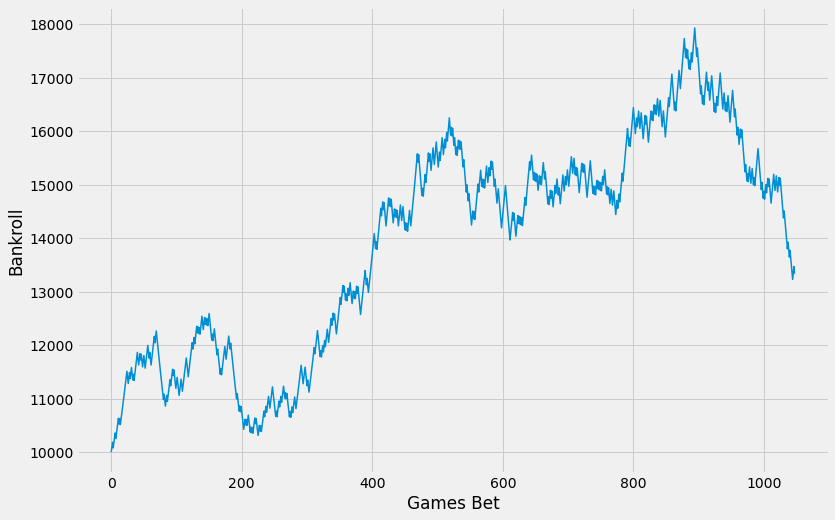

min balance: 10080.818181818182 
max balance: 17935.297491435085 
final balance: 13458.761239481086 
win percentage 54.1


index  GAME_DATE  spread  point_diff_team     preds  home_cover  \
0     18093 2015-11-06     6.0                5 -3.972051         1.0   
1     18094 2015-11-06    -1.5               -7 -1.000302         0.0   
2     18097 2015-11-06     4.5               -6 -1.929266         0.0   
3     18100 2015-11-07    -2.5               10  5.432279         1.0   
4     18112 2015-11-09    -4.5               13  6.645202         1.0   
...     ...        ...     ...              ...       ...         ...   
1043  24055 2020-09-04    -5.5              -15  8.403555         0.0   
1044  24057 2020-09-05    -9.0               -9  6.301397         0.0   
1045  24069 2020-09-12    -6.5               23  8.876701         1.0   
1046  24072 2020-09-15    -2.0               -3  4.239794         0.0   
1047  24074 2020-09-18    -7.5               12  9.517177         1.0   

      bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0            1        1  10000.000000  10090.909091  100.000000    2.027949  
1            0        1  10090.909091  10182.644628  100.909091   -2.500302  
2            1        0  10182.644628  10080.818182  101.826446    2.570734  
3            1        1  10080.818182  10172.461983  100.808182    2.932279  
4            1        1  10172.461983  10264.938911  101.724620    2.145202  
...        ...      ...           ...           ...         ...         ...  
1043         1        0  13364.226226  13230.583964  133.642262    2.903555  
1044         0        1  13230.583964  13350.862000  132.305840   -2.698603  
1045         1        1  13350.862000  13472.233473  133.508620    2.376701  
1046         1        0  13472.233473  13337.511138  134.722335    2.239794  
1047         1        1  13337.511138  13458.761239  133.375111    2.017177  

[1048 rows x 12 columns]

In [366]:
lr_pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline.fit(X_train, point_diff_train)
lr_preds = lr_pipeline.predict(X_test)

mse = mean_squared_error(point_diff_test, lr_preds)
mae = mean_absolute_error(point_diff_test, lr_preds)
print("mse:", mse, "mae:", mae)

select_bets_lr, bet_thresholds_lr = find_optimal_threshold(lr_preds, test_indices)
simulate_bets(select_bets_lr)

In [365]:
feature_names = X_train.columns
coefficients = lr_pipeline.named_steps['linreg'].coef_

coefs = pd.DataFrame({'feature':feature_names, 'coef':coefficients})
coefs.sort_values('coef').head(10)

feature          coef
75    REB_PCT_opp_diff -1.550129e+13
35   REB_PCT_team_diff -1.550129e+13
33  OREB_PCT_team_diff -1.231671e+13
74   DREB_PCT_opp_diff -1.231671e+13
34  DREB_PCT_team_diff -8.374178e+12
73   OREB_PCT_opp_diff -8.374178e+12
48       DREB_opp_diff -4.530421e+11
55        PTS_opp_diff -4.023891e+11
8       DREB_team_diff -3.439943e+11
47       OREB_opp_diff -3.026182e+11

#### Predicting Spread + Actual Point Diff as Proxy For Confidence of Covering

In [441]:
lr_pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline.fit(X_train_spread, spread_point_diff_train)
lr_preds = lr_pipeline.predict(X_test_spread)

mse = mean_squared_error(spread_point_diff_test, lr_preds)
mae = mean_absolute_error(spread_point_diff_test, lr_preds)
print("mse:", mse, "mae:", mae)

# select_bets_lr, bet_thresholds_lr = find_optimal_threshold(lr_preds, test_indices)
# simulate_bets(select_bets_lr)

mse: 159.7409919864432 mae: 9.847399146058782


In [40]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_confidence_thresholds(test_preds, test_indices):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    betting_df = final_df_ewm_19[['GAME_DATE', 'home_spread_mode', 'point_diff_team']].iloc[cutoff_16:]
    betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
    betting_df['confidence_preds'] = test_preds
    betting_df['home_cover'] = (betting_df['point_diff_team'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_home'] = (betting_df['confidence_preds'] > 0).astype(int)

    betting_df.loc[betting_df['spread'] + betting_df['point_diff_team'] == 0, 'home_cover'] = 0.5
    betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['home_cover']).astype(int)

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df['bankroll_i'].iloc[0] = 10000
    betting_df['bet_size'] = np.nan

    confidence_threshold = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
    for i in range(1, 100):
        select_bets = betting_df.loc[abs(betting_df['confidence_preds']) > i/10]
        win_pct = select_bets['bet_won'].mean()
        num_games = select_bets.shape[0]
        confidence_threshold.append(i/10)
        win_percentages.append(win_pct)
        num_games_bet.append(num_games)
        bets_won = select_bets['bet_won'].sum()
        bets_lost = num_games - bets_won
        expected_profit = (bets_won*100 + bets_lost*-108)
        expected_profits.append(expected_profit)
        

    confidence_thresholds = pd.DataFrame({'confidence_thresholds':confidence_threshold, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profits':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
    confidence_thresholds.sort_values('expected_profits', ascending=False, inplace=True)
    confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
    best_thresholds = confidence_thresholds.loc[0, 'confidence_thresholds']
    print("best thresholds:", best_thresholds)
    select_bets =  betting_df.loc[abs(betting_df['confidence_preds']) > best_thresholds]
    print("num_games_bet:", select_bets.shape[0])
    print("win percetange at threshold:", select_bets['bet_won'].mean())
    
    return select_bets, confidence_thresholds
    

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.5
num_games_bet: 701
win percetange at threshold: 0.5378031383737518


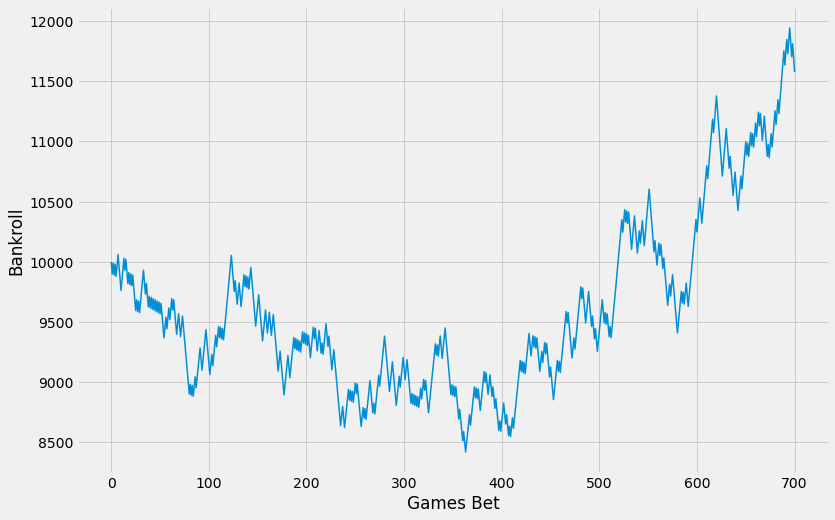

min balance: 8419.448843838505 
max balance: 11943.246113806059 
final balance: 11682.176070684553 
win percentage 53.779999999999994


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11776 2016-11-04     3.5              -14          2.510471         0.0   
1    11781 2016-11-06    -7.5               -5         -3.224778         0.0   
2    11782 2016-11-06    -4.0               11         -4.566497         1.0   
3    11783 2016-11-06    -7.0              -16         -3.528927         0.0   
4    11785 2016-11-07    -5.5               12         -2.588115         1.0   
..     ...        ...     ...              ...               ...         ...   
696  16465 2020-09-07     1.5              -22          3.559061         0.0   
697  16466 2020-09-07     9.0               -6          2.999338         1.0   
698  16469 2020-09-09     8.0              -11          2.578562         0.0   
699  16480 2020-09-19     3.5              -11          3.091350         0.0   
700  16483 2020-09-23     3.5                3          2.938643         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           1        0  10000.000000   9900.000000  100.000000  
1           0        1   9900.000000   9990.000000   99.000000  
2           0        0   9990.000000   9890.100000   99.900000  
3           0        1   9890.100000   9980.010000   98.901000  
4           0        0   9980.010000   9880.209900   99.800100  
..        ...      ...           ...           ...         ...  
696         1        0  11823.813653  11705.575516  118.238137  
697         1        1  11705.575516  11811.989839  117.055755  
698         1        0  11811.989839  11693.869941  118.119898  
699         1        0  11693.869941  11576.931241  116.938699  
700         1        1  11576.931241  11682.176071  115.769312  

[701 rows x 11 columns]

In [41]:
select_bets_lr, best_thresholds_lr = find_optimal_confidence_thresholds(lr_preds, test_indices)
simulate_bets(select_bets_lr)


#### Exponential Weighted Average

mse: 159.5054247513403 mae: 9.83742352322099
best thresholds: 2.5
num_games_bet: 701
win percetange at threshold: 0.5378031383737518


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


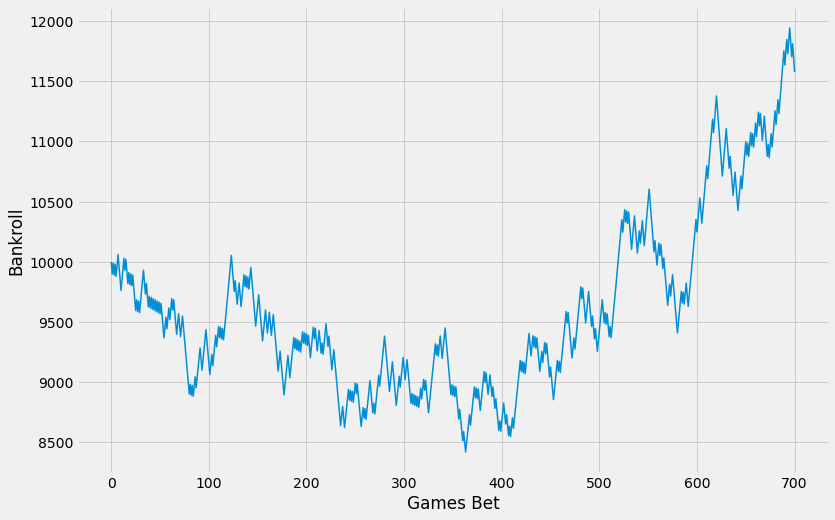

min balance: 8419.448843838505 
max balance: 11943.246113806059 
final balance: 11682.176070684553 
win percentage 53.779999999999994


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11776 2016-11-04     3.5              -14          2.510471         0.0   
1    11781 2016-11-06    -7.5               -5         -3.224778         0.0   
2    11782 2016-11-06    -4.0               11         -4.566497         1.0   
3    11783 2016-11-06    -7.0              -16         -3.528927         0.0   
4    11785 2016-11-07    -5.5               12         -2.588115         1.0   
..     ...        ...     ...              ...               ...         ...   
696  16465 2020-09-07     1.5              -22          3.559061         0.0   
697  16466 2020-09-07     9.0               -6          2.999338         1.0   
698  16469 2020-09-09     8.0              -11          2.578562         0.0   
699  16480 2020-09-19     3.5              -11          3.091350         0.0   
700  16483 2020-09-23     3.5                3          2.938643         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           1        0  10000.000000   9900.000000  100.000000  
1           0        1   9900.000000   9990.000000   99.000000  
2           0        0   9990.000000   9890.100000   99.900000  
3           0        1   9890.100000   9980.010000   98.901000  
4           0        0   9980.010000   9880.209900   99.800100  
..        ...      ...           ...           ...         ...  
696         1        0  11823.813653  11705.575516  118.238137  
697         1        1  11705.575516  11811.989839  117.055755  
698         1        0  11811.989839  11693.869941  118.119898  
699         1        0  11693.869941  11576.931241  116.938699  
700         1        1  11576.931241  11682.176071  115.769312  

[701 rows x 11 columns]

In [42]:
lr_pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
lr_preds = lr_pipeline.predict(X_test_ewm_19)

mse = mean_squared_error(spread_point_diff_test_ewm_19, lr_preds)
mae = mean_absolute_error(spread_point_diff_test_ewm_19, lr_preds)
print("mse:", mse, "mae:", mae)

select_bets_lr_ewm_19, bet_thresholds_lr_ewm_19 = find_optimal_confidence_thresholds(lr_preds, test_indices)
simulate_bets(select_bets_lr_ewm_19)

In [505]:
sgd_pipe = make_pipeline(StandardScaler(), SGDRegressor(loss='huber', penalty='elasticnet', epsilon=0.257191))

params = {#'sgdregressor__epsilon':np.logspace(-2, 3, 40),
         'sgdregressor__alpha':np.logspace(-4, 2, 20),
         'sgdregressor__l1_ratio':np.linspace(0.05, 1, 20)}

sgd_cv = GridSearchCV(sgd_pipe, param_grid = params, scoring='neg_mean_absolute_error', cv=tscv)

sgd_cv.fit(X_train_spread, spread_point_diff_train)

best_sgd = sgd_cv.best_estimator_
print(best_sgd)

sgd_preds = best_sgd.predict(X_test_spread)



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(epsilon=0.257191, l1_ratio=1.0, loss='huber',
                              penalty='elasticnet'))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.2
num_games_bet: 225
win percetange at threshold: 0.5688888888888889


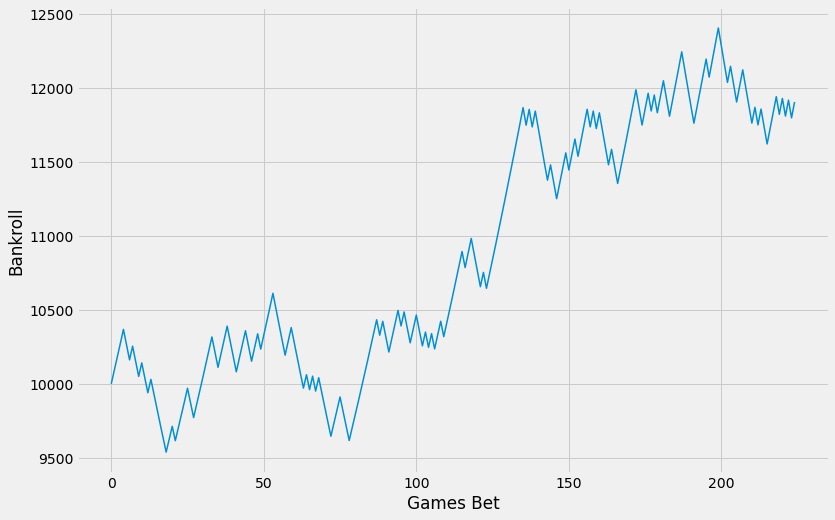

min balance: 9538.919768589501 
max balance: 12406.098143174579 
final balance: 12014.106027933547 
win percentage 56.88999999999999


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11792 2016-11-08    -4.0              -12         -2.755645         0.0   
1    12021 2016-12-08    -6.0              -11         -2.502568         0.0   
2    12026 2016-12-09    -1.5               -4         -2.416083         0.0   
3    12028 2016-12-09     3.5                8          2.759541         1.0   
4    12108 2016-12-20    -8.0               17         -2.308499         1.0   
..     ...        ...     ...              ...               ...         ...   
220  16437 2020-08-23    14.0              -28          2.644911         0.0   
221  16439 2020-08-24    -6.5               12          2.282957         1.0   
222  16466 2020-09-07     1.5              -22          2.388546         0.0   
223  16483 2020-09-23     3.5                3          2.339087         1.0   
224  16486 2020-09-26    -5.5               10          2.700199         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        1  10000.000000  10090.909091  100.000000  
1           0        1  10090.909091  10182.644628  100.909091  
2           0        1  10182.644628  10275.214125  101.826446  
3           1        1  10275.214125  10368.625162  102.752141  
4           0        0  10368.625162  10264.938911  103.686252  
..        ...      ...           ...           ...         ...  
220         1        0  11929.718345  11810.421162  119.297183  
221         1        1  11810.421162  11917.788627  118.104212  
222         1        0  11917.788627  11798.610741  119.177886  
223         1        1  11798.610741  11905.870838  117.986107  
224         1        1  11905.870838  12014.106028  119.058708  

[225 rows x 11 columns]

In [515]:
select_bets_sgd, best_thresholds_sgd = find_optimal_confidence_thresholds(sgd_preds, test_indices)
simulate_bets(select_bets_sgd)

In [503]:
select_bets_sgd

GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
11777 2016-11-05    -4.5              -24          1.842939         0.0   
11792 2016-11-08    -4.0              -12         -2.850256         0.0   
11840 2016-11-14   -11.5               27          1.720357         1.0   
11901 2016-11-23    -5.0               23         -2.232842         1.0   
11913 2016-11-25    -5.5               21         -1.885542         1.0   
...          ...     ...              ...               ...         ...   
16481 2020-09-20    -7.5                2          2.093566         0.0   
16482 2020-09-22     6.0                8         -1.920313         1.0   
16483 2020-09-23     3.5                3          2.367926         1.0   
16486 2020-09-26    -5.5               10          2.862190         1.0   
16488 2020-09-30    -4.5               18          1.777867         1.0   

       bet_home  bet_won  bankroll_i  bankroll_n  bet_size  
11777         1        0         NaN         NaN       NaN  
11792         0        1         NaN         NaN       NaN  
11840         1        1         NaN         NaN       NaN  
11901         0        0         NaN         NaN       NaN  
11913         0        0         NaN         NaN       NaN  
...         ...      ...         ...         ...       ...  
16481         1        0         NaN         NaN       NaN  
16482         0        0         NaN         NaN       NaN  
16483         1        1         NaN         NaN       NaN  
16486         1        1         NaN         NaN       NaN  
16488         1        1         NaN         NaN       NaN  

[569 rows x 10 columns]

#### SGD EWM

In [43]:
sgd_pipe = make_pipeline(StandardScaler(), SGDRegressor(loss='huber', penalty='elasticnet'))

params = {'sgd_regressor__loss': ['huber'],
    'sgdregressor__epsilon':[0.19144819761699575],
         'sgdregressor__alpha':np.logspace(-4, 2, 20),
         'sgdregressor__l1_ratio':np.linspace(0.05, 1, 20)}

sgd_cv = GridSearchCV(sgd_pipe, param_grid = params, scoring='neg_mean_absolute_error', cv=tscv)

sgd_cv.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

best_sgd = sgd_cv.best_estimator_
print(best_sgd)

sgd_preds = best_sgd.predict(X_test_ewm_19)
select_bets_sgd, best_thresholds_sgd = find_optimal_confidence_thresholds(sgd_preds, test_indices)
simulate_bets(select_bets_sgd)

SyntaxError: invalid syntax (<ipython-input-43-8bb7daa4076f>, line 4)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 1.1
num_games_bet: 933
win percetange at threshold: 0.5509110396570204


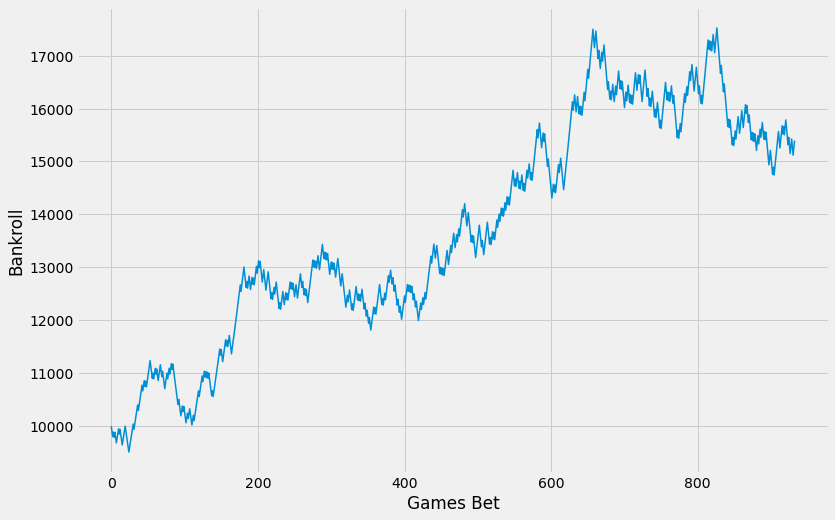

min balance: 9510.33161650412 
max balance: 17522.524984931577 
final balance: 15535.221915482822 
win percentage 55.089999999999996


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11788 2016-11-07    -7.0               32         -1.298134         1.0   
1    11790 2016-11-08    -4.0                1          1.227701         0.0   
2    11792 2016-11-08    -4.0              -12         -2.637129         0.0   
3    11794 2016-11-09    -3.0                6         -1.109683         1.0   
4    11800 2016-11-09    -3.5                8          1.287222         1.0   
..     ...        ...     ...              ...               ...         ...   
928  16480 2020-09-19     3.5              -11          2.039395         0.0   
929  16481 2020-09-20    -7.5                2          1.230693         0.0   
930  16483 2020-09-23     3.5                3          2.052607         1.0   
931  16486 2020-09-26    -5.5               10          1.552297         1.0   
932  16487 2020-09-27     3.0               12          1.237435         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           1        0   9900.000000   9801.000000   99.000000  
2           0        1   9801.000000   9890.100000   98.010000  
3           0        0   9890.100000   9791.199000   98.901000  
4           1        1   9791.199000   9880.209900   97.911990  
..        ...      ...           ...           ...         ...  
928         1        0  15426.101739  15271.840721  154.261017  
929         1        0  15271.840721  15119.122314  152.718407  
930         1        1  15119.122314  15256.568881  151.191223  
931         1        1  15256.568881  15395.264961  152.565689  
932         1        1  15395.264961  15535.221915  153.952650  

[933 rows x 11 columns]

In [44]:
sgd_pipe = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.0008858667904100823,
                              epsilon=0.19144819761699575, l1_ratio=0.25,
                              loss='huber', penalty='elasticnet'))])

sgd_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

sgd_preds = sgd_pipe.predict(X_test_ewm_19)

select_bets_sgd, best_thresholds_sgd = find_optimal_confidence_thresholds(sgd_preds, test_indices)
simulate_bets(select_bets_sgd)

#### Windsor Outliers

The reasoning behind this technique is that a spread is generally never more than 20. Thus, I will replace any point differentials that are greater than 20 with 20, as that will never change whether or not a bet is placed. However the hope is that this could possibly make the other predictions more accurate.

In [401]:
final_df = final_df.sort_values('GAME_DATE').reset_index(drop=True)

features = final_df.iloc[:, 14:-1]
features = features.drop(columns=['MIN_opp_diff', 'home_rating_n', 'away_rating_n'])
point_diff = final_df['point_diff_team']
features

X_train = features.iloc[:cutoff_15]
# X_train2 = features.iloc[cutoff_15:cutoff_17]
X_test = features.iloc[cutoff_15:]
point_diff_train = point_diff[:cutoff_15]

point_diff_train_windsor = point_diff_train.copy(deep=True)
point_diff_train_windsor.loc[point_diff_train_windsor > 20] = 20
point_diff_train_windsor.loc[point_diff_train_windsor < -20] = -20

# point_diff_train2 = point_diff[cutoff_15:cutoff_17]
point_diff_test = point_diff[cutoff_15:]


test_indices = X_test.index


mse: 164.06774993339562 mae: 10.011002978334561


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (6, 7)
num_games_bet: 217
win percetange at threshold: 0.5391705069124424


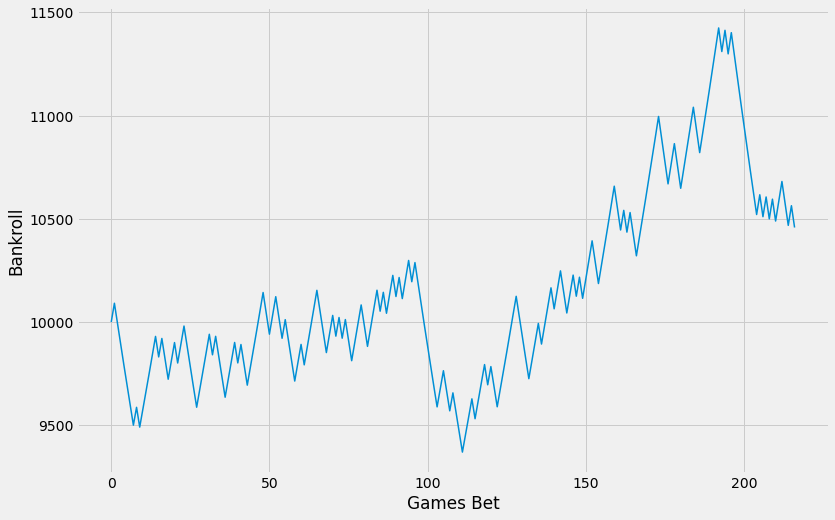

min balance: 9369.945115789762 
max balance: 11424.259463164577 
final balance: 10552.70540429874 
win percentage 53.92


index  GAME_DATE  spread  point_diff_team     preds  home_cover  \
0    18092 2015-11-05     4.5               19  2.119298         1.0   
1    18117 2015-11-09    10.5              -23 -3.874963         0.0   
2    18120 2015-11-10     6.5              -24 -0.194011         0.0   
3    18149 2015-11-13   -10.5               19  4.085793         1.0   
4    18222 2015-11-24     7.0              -17 -0.868779         0.0   
..     ...        ...     ...              ...       ...         ...   
212  23994 2020-08-12     5.5              -13  0.985405         0.0   
213  23998 2020-08-13    -8.5               26  1.755143         1.0   
214  24010 2020-08-18   -14.0              -12  7.945966         0.0   
215  24034 2020-08-24     7.0              -20 -0.445108         0.0   
216  24078 2020-09-23     3.5                3  3.380890         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        1  10000.000000  10090.909091  100.000000    6.619298  
1           1        0  10090.909091   9990.000000  100.909091    6.625037  
2           1        0   9990.000000   9890.100000   99.900000    6.305989  
3           0        0   9890.100000   9791.199000   98.901000   -6.414207  
4           1        0   9791.199000   9693.287010   97.911990    6.131221  
..        ...      ...           ...           ...         ...         ...  
212         1        0  10680.649006  10573.842515  106.806490    6.485405  
213         0        0  10573.842515  10468.104090  105.738425   -6.744857  
214         0        1  10468.104090  10563.268673  104.681041   -6.054034  
215         1        0  10563.268673  10457.635986  105.632687    6.554892  
216         1        1  10457.635986  10552.705404  104.576360    6.880890  

[217 rows x 12 columns]

In [403]:
lr_pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline.fit(X_train, point_diff_train_windsor)
lr_preds = lr_pipeline.predict(X_test)

mse = mean_squared_error(point_diff_test, lr_preds)
mae = mean_absolute_error(point_diff_test, lr_preds)
print("mse:", mse, "mae:", mae)

select_bets_lr, bet_thresholds_lr = find_optimal_threshold(lr_preds, test_indices)
simulate_bets(select_bets_lr)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (2, 3)
num_games_bet: 1048
win percetange at threshold: 0.541030534351145


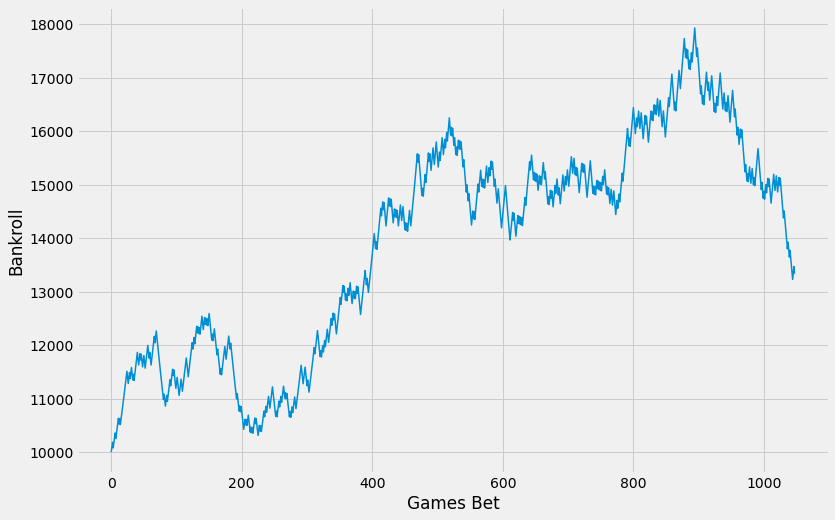

min balance: 10080.818181818182 
max balance: 17935.297491435085 
final balance: 13458.761239481086 
win percentage 54.1


index  GAME_DATE  spread  point_diff_team     preds  home_cover  \
0     18093 2015-11-06     6.0                5 -3.972051         1.0   
1     18094 2015-11-06    -1.5               -7 -1.000302         0.0   
2     18097 2015-11-06     4.5               -6 -1.929266         0.0   
3     18100 2015-11-07    -2.5               10  5.432279         1.0   
4     18112 2015-11-09    -4.5               13  6.645202         1.0   
...     ...        ...     ...              ...       ...         ...   
1043  24055 2020-09-04    -5.5              -15  8.403555         0.0   
1044  24057 2020-09-05    -9.0               -9  6.301397         0.0   
1045  24069 2020-09-12    -6.5               23  8.876701         1.0   
1046  24072 2020-09-15    -2.0               -3  4.239794         0.0   
1047  24074 2020-09-18    -7.5               12  9.517177         1.0   

      bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0            1        1  10000.000000  10090.909091  100.000000    2.027949  
1            0        1  10090.909091  10182.644628  100.909091   -2.500302  
2            1        0  10182.644628  10080.818182  101.826446    2.570734  
3            1        1  10080.818182  10172.461983  100.808182    2.932279  
4            1        1  10172.461983  10264.938911  101.724620    2.145202  
...        ...      ...           ...           ...         ...         ...  
1043         1        0  13364.226226  13230.583964  133.642262    2.903555  
1044         0        1  13230.583964  13350.862000  132.305840   -2.698603  
1045         1        1  13350.862000  13472.233473  133.508620    2.376701  
1046         1        0  13472.233473  13337.511138  134.722335    2.239794  
1047         1        1  13337.511138  13458.761239  133.375111    2.017177  

[1048 rows x 12 columns]

In [157]:
select_bets_lr, bet_thresholds_lr = find_optimal_threshold(lr_preds_reduced, test_indices)
simulate_bets(select_bets_lr)

### Elastic Net

In [143]:
X_train_scaled

en = ElasticNetCV(l1_ratio = [0.05, .1, 0.2, 0.3, 0.4, .5, .7, 0.8, .9, .95, .99, 1], max_iter=10000, cv=tscv)
en.fit(X_train_scaled, point_diff_train)

ElasticNetCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             l1_ratio=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99,
                       1],
             max_iter=10000)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (8, 11)
num_games_bet: 130
win percetange at threshold: 0.5384615384615384


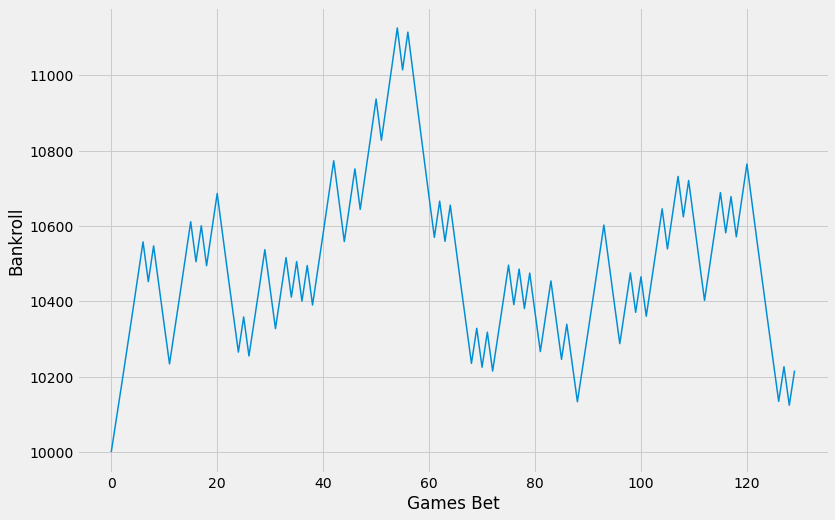

min balance: 10090.90909090909 
max balance: 11125.867289286321 
final balance: 10309.372450939349 
win percentage 53.849999999999994


index  GAME_DATE  spread  point_diff_team     preds  home_cover  \
0    18092 2015-11-05     4.5               19  5.715305         1.0   
1    18553 2016-01-08    15.5               -4 -7.381065         1.0   
2    18703 2016-01-28     5.5                9  4.747972         1.0   
3    18953 2016-03-07   -15.0               -3  6.860130         0.0   
4    18975 2016-03-11     3.0                7  6.181116         1.0   
..     ...        ...     ...              ...       ...         ...   
125  24044 2020-08-30     9.5              -14 -1.103585         0.0   
126  24061 2020-09-07     9.0               -6 -0.863049         1.0   
127  24062 2020-09-08     5.5               -9  3.542117         0.0   
128  24085 2020-10-04     9.5               11  0.010024         1.0   
129  24086 2020-10-06     7.5               -6  1.219858         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        1  10000.000000  10090.909091  100.000000   10.215305  
1           1        1  10090.909091  10182.644628  100.909091    8.118935  
2           1        1  10182.644628  10275.214125  101.826446   10.247972  
3           0        1  10275.214125  10368.625162  102.752141   -8.139870  
4           1        1  10368.625162  10462.885391  103.686252    9.181116  
..        ...      ...           ...           ...         ...         ...  
125         1        0  10236.958902  10134.589313  102.369589    8.396415  
126         1        1  10134.589313  10226.721944  101.345893    8.136951  
127         1        0  10226.721944  10124.454724  102.267219    9.042117  
128         1        1  10124.454724  10216.495222  101.244547    9.510024  
129         1        1  10216.495222  10309.372451  102.164952    8.719858  

[130 rows x 12 columns]

In [269]:
en_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('en', ElasticNet(alpha=0.7984, l1_ratio = 0.3))])
en_pipeline.fit(X_train, point_diff_train)
en_preds = en_pipeline.predict(X_test)

select_bets_en, bet_thresholds_en = find_optimal_threshold(en_preds, test_indices)
simulate_bets(select_bets_en)

In [325]:
feature_names = X_train.columns
coefficients = en_pipeline.named_steps['en'].coef_

coefs = pd.DataFrame({'feature':feature_names, 'coef':coefficients})
coefs.sort_values('coef').head(10)

feature      coef
83          away_rating_i -0.392524
61  E_NET_RATING_opp_diff -0.189081
56    PLUS_MINUS_opp_diff -0.183274
68     PTS_PAINT_opp_diff -0.169470
64           PIE_opp_diff -0.169136
62    NET_RATING_opp_diff -0.165004
25   PTS_2PT_MR_team_diff -0.131716
78     AST_RATIO_opp_diff -0.128877
50           AST_opp_diff -0.090590
40        RECORD_opp_diff -0.086719

#### Predicting Spread + Actual Point Diff as Proxy for Confidence of Covering

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46405.29824911695, tolerance: 27.21964898167006
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23967.889520232857, tolerance: 54.486963346917975
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28147.863014982664, tolerance: 80.16074984714675
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.11721022975334805, max_iter=10000))])
best thresholds: 0.8
num_games_bet: 1764
win percetange at threshold: 0.5317460317460317


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


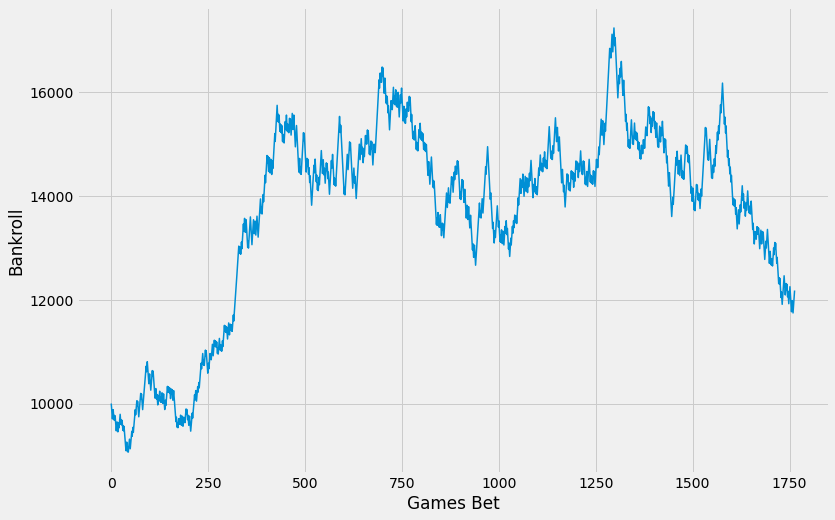

min balance: 9062.757197225039 
max balance: 17244.98432628581 
final balance: 12058.30212442243 
win percentage 53.169999999999995


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0     11776 2016-11-04     3.5              -14          1.143403         0.0   
1     11778 2016-11-05    -3.5               26         -1.305891         1.0   
2     11781 2016-11-06    -4.0               11         -1.372788         1.0   
3     11782 2016-11-06    -7.5               -5         -1.178708         0.0   
4     11785 2016-11-07   -16.5               10         -1.411299         0.0   
...     ...        ...     ...              ...               ...         ...   
1759  16483 2020-09-23     3.5                3          1.692489         1.0   
1760  16486 2020-09-26    -5.5               10          1.514092         1.0   
1761  16487 2020-09-27     3.0               12          0.977415         1.0   
1762  16488 2020-09-30    -4.5               18          0.882488         1.0   
1763  16492 2020-10-09    -7.5               -3          0.847482         0.0   

      bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0            1        0  10000.000000   9900.000000  100.000000  
1            0        0   9900.000000   9801.000000   99.000000  
2            0        0   9801.000000   9702.990000   98.010000  
3            0        1   9702.990000   9791.199000   97.029900  
4            0        1   9791.199000   9880.209900   97.911990  
...        ...      ...           ...           ...         ...  
1759         1        1  11747.076363  11853.867966  117.470764  
1760         1        1  11853.867966  11961.630402  118.538680  
1761         1        1  11961.630402  12070.372497  119.616304  
1762         1        1  12070.372497  12180.103156  120.703725  
1763         1        0  12180.103156  12058.302124  121.801032  

[1764 rows x 11 columns]

In [517]:
en_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('en', ElasticNet(max_iter=10000))])
en_pipeline.fit(X_train_spread, spread_point_diff_train)

params = {"en__alpha":np.logspace(-3, 2, 30)}

en_cv = GridSearchCV(en_pipeline, params, scoring='neg_mean_absolute_error', cv=tscv)
en_cv.fit(X_train_spread, spread_point_diff_train)

print(en_cv.best_estimator_)
best_en = en_cv.best_estimator_
en_preds = best_en.predict(X_test_spread)

select_bets_en, bet_thresholds_en = find_optimal_confidence_thresholds(en_preds, test_indices)
simulate_bets(select_bets_en)

#### Elastic Net EWM

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42515.933398616195, tolerance: 27.21964898167006
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18676.90394144319, tolerance: 54.486963346917975
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 731.7285962216556, tolerance: 80.16074984714675
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.11721022975334805, max_iter=10000))])
best thresholds: 1.5
num_games_bet: 406
win percetange at threshold: 0.5344827586206896


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


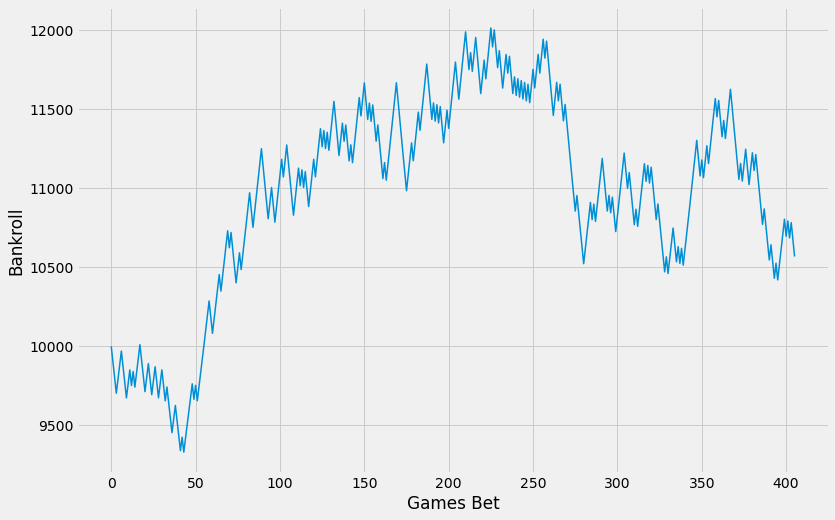

min balance: 9330.829404160793 
max balance: 12014.106027933558 
final balance: 10664.131611933686 
win percentage 53.449999999999996


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11781 2016-11-06    -4.0               11         -1.529753         1.0   
1    11786 2016-11-07    -7.0               32         -1.760013         1.0   
2    11787 2016-11-07    -8.0               32         -1.665613         1.0   
3    11792 2016-11-08    -4.0              -12         -2.586241         0.0   
4    11803 2016-11-09    -3.0              -16         -2.063963         0.0   
..     ...        ...     ...              ...               ...         ...   
401  16437 2020-08-23    14.0              -28          2.322294         0.0   
402  16445 2020-08-29    -5.0               34          1.809281         1.0   
403  16455 2020-09-02    -5.5                2          2.009405         0.0   
404  16480 2020-09-19     3.5              -11          1.782516         0.0   
405  16483 2020-09-23     3.5                3          1.962849         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           0        0   9900.000000   9801.000000   99.000000  
2           0        0   9801.000000   9702.990000   98.010000  
3           0        1   9702.990000   9791.199000   97.029900  
4           0        1   9791.199000   9880.209900   97.911990  
..        ...      ...           ...           ...         ...  
401         1        0  10793.426172  10685.491910  107.934262  
402         1        1  10685.491910  10782.632746  106.854919  
403         1        0  10782.632746  10674.806418  107.826327  
404         1        0  10674.806418  10568.058354  106.748064  
405         1        1  10568.058354  10664.131612  105.680584  

[406 rows x 11 columns]

In [635]:
en_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('en', ElasticNet(max_iter=10000))])

en_pipeline.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

params = {"en__alpha":np.logspace(-3, 2, 30)}

en_cv = GridSearchCV(en_pipeline, params, scoring='neg_mean_absolute_error', cv=tscv)
en_cv.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

print(en_cv.best_estimator_)
best_en = en_cv.best_estimator_
en_preds = best_en.predict(X_test_ewm_19)

select_bets_en, bet_thresholds_en = find_optimal_confidence_thresholds(en_preds, test_indices)
simulate_bets(select_bets_en)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 1.5
num_games_bet: 400
win percetange at threshold: 0.5725


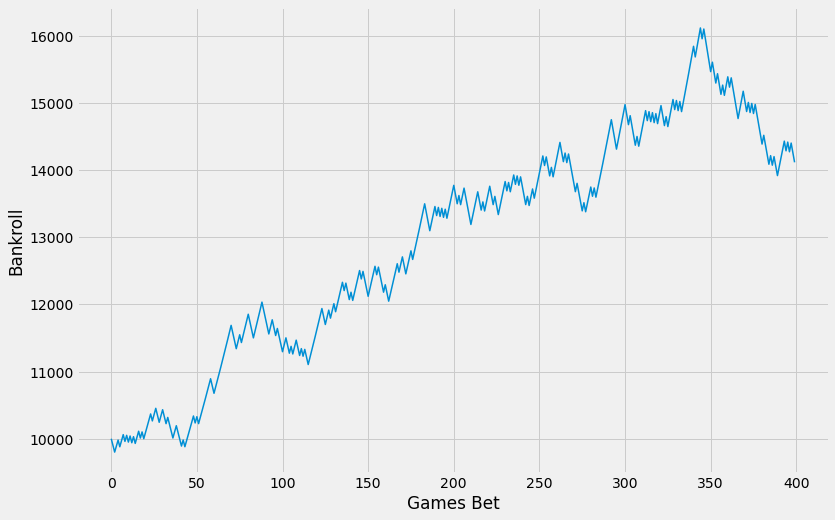

min balance: 9801.0 
max balance: 16117.487494618685 
final balance: 14244.772482908105 
win percentage 57.25


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11782 2016-11-06    -4.0               11         -1.528211         1.0   
1    11785 2016-11-07    -5.5               12         -1.667264         1.0   
2    11786 2016-11-07   -16.5               10         -1.761373         0.0   
3    11792 2016-11-08    -4.0              -12         -2.586228         0.0   
4    11804 2016-11-09   -18.5               21         -2.065348         1.0   
..     ...        ...     ...              ...               ...         ...   
395  16437 2020-08-23    14.0              -28          2.324239         0.0   
396  16445 2020-08-29    -5.0               34          1.808928         1.0   
397  16455 2020-09-02    -5.5                2          2.009437         0.0   
398  16480 2020-09-19     3.5              -11          1.783403         0.0   
399  16483 2020-09-23     3.5                3          1.963603         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           0        0   9900.000000   9801.000000   99.000000  
2           0        1   9801.000000   9890.100000   98.010000  
3           0        1   9890.100000   9980.010000   98.901000  
4           0        0   9980.010000   9880.209900   99.800100  
..        ...      ...           ...           ...         ...  
395         1        0  14417.479615  14273.304819  144.174796  
396         1        1  14273.304819  14403.062136  142.733048  
397         1        0  14403.062136  14259.031514  144.030621  
398         1        0  14259.031514  14116.441199  142.590315  
399         1        1  14116.441199  14244.772483  141.164412  

[400 rows x 11 columns]

In [45]:
en_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.11721022975334805, max_iter=10000))])

en_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

en_preds = en_pipe.predict(X_test_ewm_19)

select_bets_en, bet_thresholds_en = find_optimal_confidence_thresholds(en_preds, test_indices)
simulate_bets(select_bets_en)

#### Windsor Outliers

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (8, 19)
num_games_bet: 169
win percetange at threshold: 0.5443786982248521


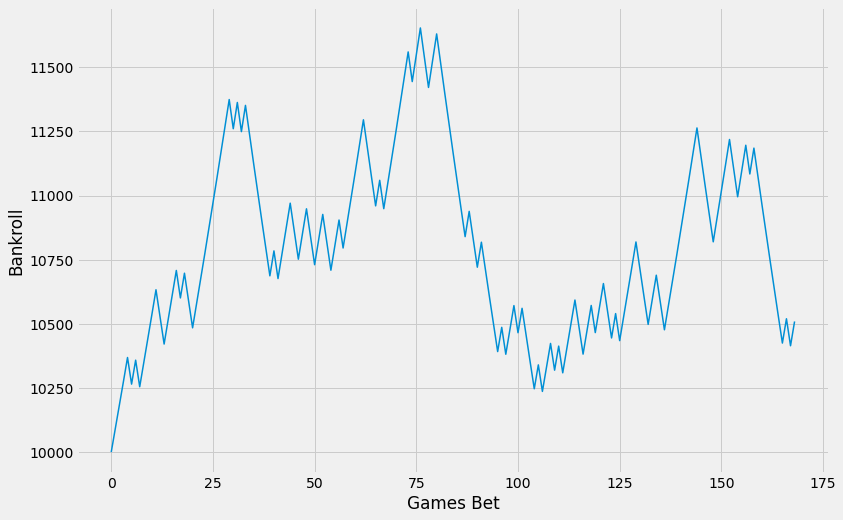

min balance: 10090.90909090909 
max balance: 11653.048202279013 
final balance: 10604.66607597427 
win percentage 54.44


index  GAME_DATE  spread  point_diff_team     preds  home_cover  \
0    18092 2015-11-05     4.5               19  5.033648         1.0   
1    18476 2015-12-28     9.5               -4 -1.427703         1.0   
2    18553 2016-01-08    15.5               -4 -6.458262         1.0   
3    18570 2016-01-10    16.5              -10 -7.589658         1.0   
4    18594 2016-01-13   -12.5               19  4.238574         1.0   
..     ...        ...     ...              ...       ...         ...   
164  24044 2020-08-30     9.5              -14 -0.974741         0.0   
165  24061 2020-09-07     9.0               -6 -0.756007         1.0   
166  24062 2020-09-08     5.5               -9  3.170031         0.0   
167  24085 2020-10-04     9.5               11  0.092177         1.0   
168  24086 2020-10-06     7.5               -6  1.154271         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        1  10000.000000  10090.909091  100.000000    9.533648  
1           1        1  10090.909091  10182.644628  100.909091    8.072297  
2           1        1  10182.644628  10275.214125  101.826446    9.041738  
3           1        1  10275.214125  10368.625162  102.752141    8.910342  
4           0        0  10368.625162  10264.938911  103.686252   -8.261426  
..        ...      ...           ...           ...         ...         ...  
164         1        0  10530.178370  10424.876587  105.301784    8.525259  
165         1        1  10424.876587  10519.648192  104.248766    8.243993  
166         1        0  10519.648192  10414.451710  105.196482    8.670031  
167         1        1  10414.451710  10509.128544  104.144517    9.592177  
168         1        1  10509.128544  10604.666076  105.091285    8.654271  

[169 rows x 12 columns]

In [404]:
en_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('en', ElasticNet(alpha=0.7984, l1_ratio = 0.3))])
en_pipeline.fit(X_train, point_diff_train_windsor)
en_preds = en_pipeline.predict(X_test)

select_bets_en, bet_thresholds_en = find_optimal_threshold(en_preds, test_indices)
simulate_bets(select_bets_en)

### Ridge Regression

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=100.0))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (6, 8)
num_games_bet: 332
win percetange at threshold: 0.5391566265060241


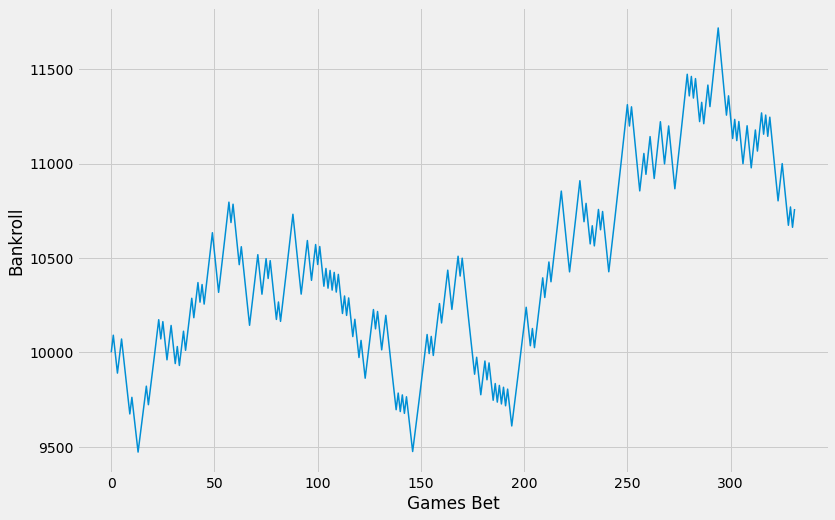

min balance: 9471.917918376901 
max balance: 11717.861316056986 
final balance: 10856.937379435647 
win percentage 53.92


index  GAME_DATE  spread  point_diff_team     preds  home_cover  \
0    18092 2015-11-05     4.5               19  2.997133         1.0   
1    18117 2015-11-09    10.5              -23 -4.079596         0.0   
2    18120 2015-11-10     6.5              -24 -0.205055         0.0   
3    18129 2015-11-11     7.0               10 -0.727684         1.0   
4    18135 2015-11-11   -13.0                8  5.791814         0.0   
..     ...        ...     ...              ...       ...         ...   
327  24068 2020-09-11     3.5               -5  4.351676         0.0   
328  24070 2020-09-13     8.5               13 -0.672368         1.0   
329  24075 2020-09-19     3.5              -11  4.399764         0.0   
330  24078 2020-09-23     3.5                3  4.009929         1.0   
331  24086 2020-10-06     7.5               -6  0.321753         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        1  10000.000000  10090.909091  100.000000    7.497133  
1           1        0  10090.909091   9990.000000  100.909091    6.420404  
2           1        0   9990.000000   9890.100000   99.900000    6.294945  
3           1        1   9890.100000   9980.010000   98.901000    6.272316  
4           0        1   9980.010000  10070.737364   99.800100   -7.208186  
..        ...      ...           ...           ...         ...         ...  
327         1        0  10780.677708  10672.870930  107.806777    7.851676  
328         1        1  10672.870930  10769.897030  106.728709    7.827632  
329         1        0  10769.897030  10662.198060  107.698970    7.899764  
330         1        1  10662.198060  10759.127133  106.621981    7.509929  
331         1        1  10759.127133  10856.937379  107.591271    7.821753  

[332 rows x 12 columns]

In [332]:
ridge_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('ridge', Ridge())])


params = {"ridge__alpha":np.logspace(-3, 2, 30)}

ridge_cv = GridSearchCV(ridge_pipeline, params, scoring='neg_root_mean_squared_error', cv=tscv)
ridge_cv.fit(X_train, point_diff_train)

print(ridge_cv.best_estimator_)

best_ridge = ridge_cv.best_estimator_

ridge_preds = best_ridge.predict(X_test)

select_bets_ridge, bet_thresholds_ridge = find_optimal_threshold(ridge_preds, test_indices)

simulate_bets(select_bets_ridge)

<AxesSubplot:ylabel='feature'>

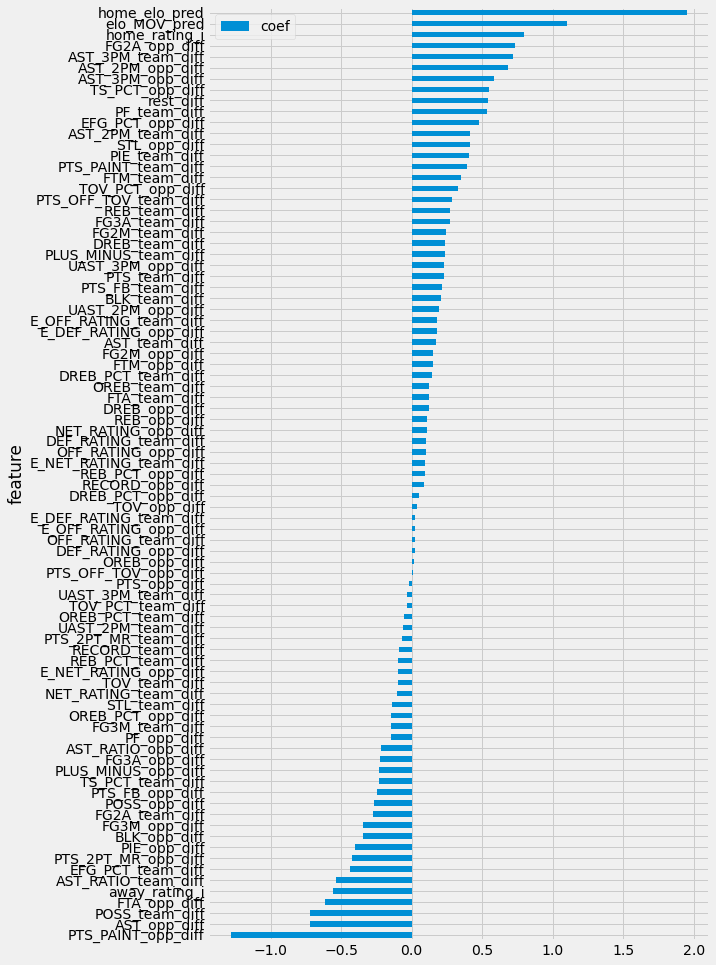

In [341]:
feature_names = X_train.columns
ridge_coefficients = best_ridge.named_steps['ridge'].coef_

ridge_coefs = pd.DataFrame({'feature':feature_names, 'coef':ridge_coefficients})
ridge_coefs.loc[ridge_coefs['coef'] !=0].sort_values('coef').plot(x='feature',kind='barh', figsize=(8,16))

#### Predicting Spread + Actual Point Diff as Proxy for Confidence of Covering

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=100.0, max_iter=10000))])
best thresholds: 2.8
num_games_bet: 199
win percetange at threshold: 0.5829145728643216


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


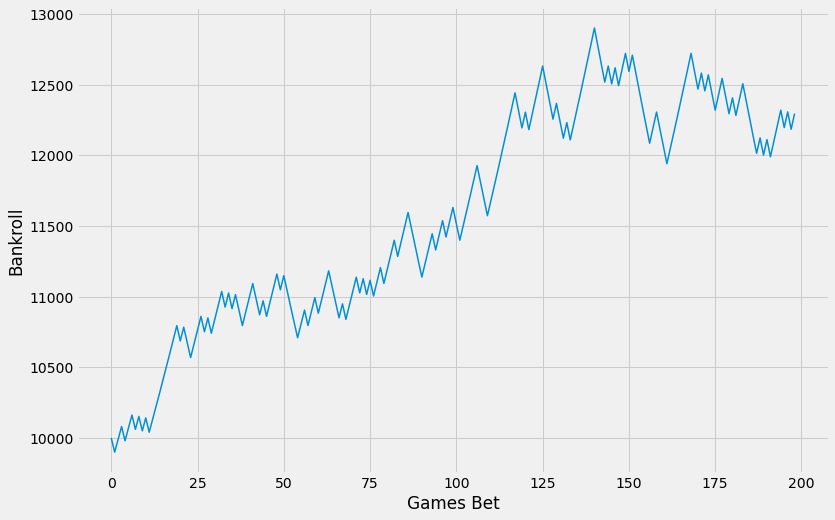

min balance: 9900.0 
max balance: 12900.331168196528 
final balance: 12406.098143174591 
win percentage 58.29


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11781 2016-11-06    -4.0               11         -3.052326         1.0   
1    11785 2016-11-07   -16.5               10         -3.288852         0.0   
2    11792 2016-11-08    -4.0              -12         -3.704538         0.0   
3    11797 2016-11-09   -18.5               21         -3.091434         1.0   
4    11834 2016-11-14   -11.0                4         -2.816539         0.0   
..     ...        ...     ...              ...               ...         ...   
194  16427 2020-08-21    11.0              -25          3.411550         0.0   
195  16432 2020-08-22    -5.0                9          3.141833         1.0   
196  16437 2020-08-23    14.0              -28          4.043567         0.0   
197  16465 2020-09-07     9.0               -6          2.962674         1.0   
198  16483 2020-09-23     3.5                3          2.910610         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           0        1   9900.000000   9990.000000   99.000000  
2           0        1   9990.000000  10080.818182   99.900000  
3           0        0  10080.818182   9980.010000  100.808182  
4           0        1   9980.010000  10070.737364   99.800100  
..        ...      ...           ...           ...         ...  
194         1        0  12318.957088  12195.767518  123.189571  
195         1        1  12195.767518  12306.638131  121.957675  
196         1        0  12306.638131  12183.571750  123.066381  
197         1        1  12183.571750  12294.331493  121.835718  
198         1        1  12294.331493  12406.098143  122.943315  

[199 rows x 11 columns]

In [518]:
ridge_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('ridge', Ridge(max_iter=10000))])
ridge_pipeline.fit(X_train_spread, spread_point_diff_train)

params = {"ridge__alpha":np.logspace(-3, 2, 30)}

ridge_cv = GridSearchCV(ridge_pipeline, params, scoring='neg_root_mean_squared_error', cv=tscv)
ridge_cv.fit(X_train_spread, spread_point_diff_train)

print(ridge_cv.best_estimator_)
best_ridge = ridge_cv.best_estimator_
ridge_preds = best_ridge.predict(X_test_spread)

select_bets_ridge, bet_thresholds_ridge = find_optimal_confidence_thresholds(ridge_preds, test_indices)
simulate_bets(select_bets_ridge)

<AxesSubplot:ylabel='feature'>

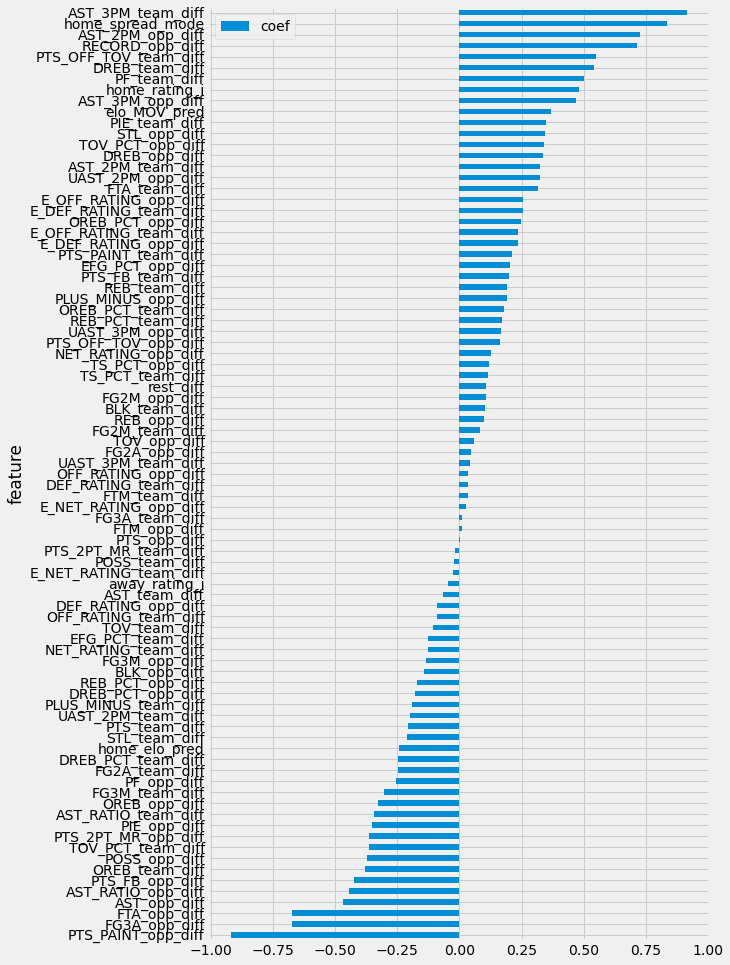

In [458]:
best_ridge
feature_names = X_train_spread.columns
ridge_coefficients = best_ridge.named_steps['ridge'].coef_

ridge_coefs = pd.DataFrame({'feature':feature_names, 'coef':ridge_coefficients})
ridge_coefs.loc[ridge_coefs['coef'] !=0].sort_values('coef').plot(x='feature',kind='barh', figsize=(8,16))

#### Ridge EWM 

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=100.0, max_iter=10000))])
best thresholds: 2.5
num_games_bet: 377
win percetange at threshold: 0.5358090185676393


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


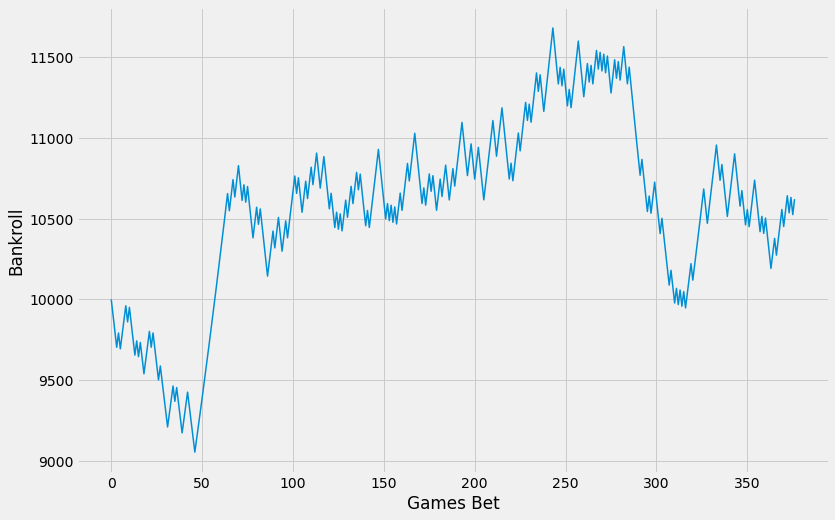

min balance: 9053.694440027815 
max balance: 11681.154157564946 
final balance: 10717.126760609573 
win percentage 53.580000000000005


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11781 2016-11-06    -4.0               11         -3.423635         1.0   
1    11786 2016-11-07    -7.0               32         -4.565230         1.0   
2    11787 2016-11-07    -8.0               32         -2.736559         1.0   
3    11792 2016-11-08    -4.0              -12         -4.535874         0.0   
4    11793 2016-11-08    -6.5                8         -3.659504         1.0   
..     ...        ...     ...              ...               ...         ...   
372  16437 2020-08-23    14.0              -28          4.418513         0.0   
373  16445 2020-08-29    -5.0               34          2.507638         1.0   
374  16480 2020-09-19     3.5              -11          2.920120         0.0   
375  16483 2020-09-23     3.5                3          3.287159         1.0   
376  16487 2020-09-27     3.0               12          2.517299         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           0        0   9900.000000   9801.000000   99.000000  
2           0        0   9801.000000   9702.990000   98.010000  
3           0        1   9702.990000   9791.199000   97.029900  
4           0        0   9791.199000   9693.287010   97.911990  
..        ...      ...           ...           ...         ...  
372         1        0  10641.849125  10535.430634  106.418491  
373         1        1  10535.430634  10631.207276  105.354306  
374         1        0  10631.207276  10524.895204  106.312073  
375         1        1  10524.895204  10620.576069  105.248952  
376         1        1  10620.576069  10717.126761  106.205761  

[377 rows x 11 columns]

In [672]:
ridge_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('ridge', Ridge(max_iter=10000))])
ridge_pipeline.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

params = {"ridge__alpha":np.logspace(-3, 2, 30)}

ridge_cv = GridSearchCV(ridge_pipeline, params, scoring='neg_mean_absolute_error', cv=tscv)
ridge_cv.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

print(ridge_cv.best_estimator_)
best_ridge = ridge_cv.best_estimator_
ridge_preds = best_ridge.predict(X_test_ewm_19)

select_bets_ridge, bet_thresholds_ridge = find_optimal_confidence_thresholds(ridge_preds, test_indices)
simulate_bets(select_bets_ridge)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 1.2
num_games_bet: 1884
win percetange at threshold: 0.5339702760084926


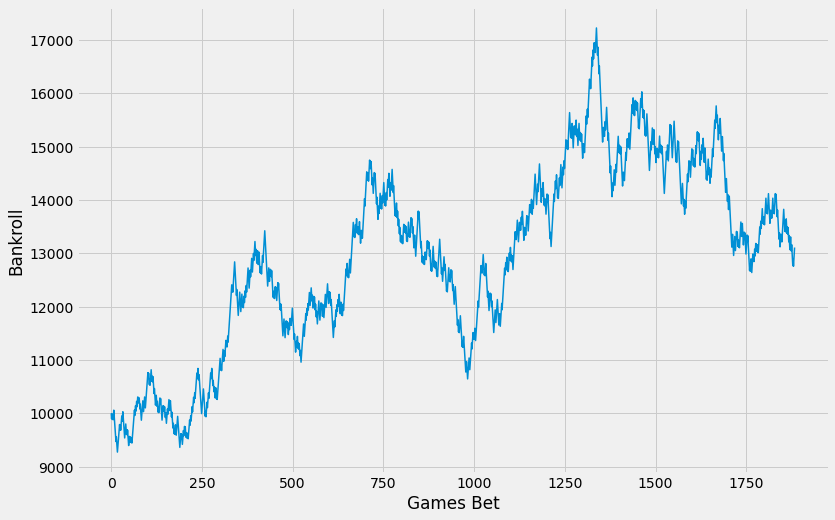

min balance: 9274.143325049397 
max balance: 17229.301366365136 
final balance: 13230.49968709251 
win percentage 53.400000000000006


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0     11776 2016-11-04     3.5              -14          1.479269         0.0   
1     11781 2016-11-06    -7.5               -5         -1.668772         0.0   
2     11782 2016-11-06    -4.0               11         -3.422760         1.0   
3     11783 2016-11-06    -7.0              -16         -1.932691         0.0   
4     11785 2016-11-07    -5.5               12         -2.739053         1.0   
...     ...        ...     ...              ...               ...         ...   
1879  16480 2020-09-19     3.5              -11          2.920534         0.0   
1880  16483 2020-09-23     3.5                3          3.287289         1.0   
1881  16486 2020-09-26    -5.5               10          1.408494         1.0   
1882  16487 2020-09-27     3.0               12          2.516190         1.0   
1883  16490 2020-10-04     9.5               11          1.529642         1.0   

      bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0            1        0  10000.000000   9900.000000  100.000000  
1            0        1   9900.000000   9990.000000   99.000000  
2            0        0   9990.000000   9890.100000   99.900000  
3            0        1   9890.100000   9980.010000   98.901000  
4            0        0   9980.010000   9880.209900   99.800100  
...        ...      ...           ...           ...         ...  
1879         1        0  12889.019411  12760.129217  128.890194  
1880         1        1  12760.129217  12876.130392  127.601292  
1881         1        1  12876.130392  12993.186122  128.761304  
1882         1        1  12993.186122  13111.305996  129.931861  
1883         1        1  13111.305996  13230.499687  131.113060  

[1884 rows x 11 columns]

In [49]:
ridge_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=100.0, max_iter=10000))])

ridge_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

ridge_preds = ridge_pipe.predict(X_test_ewm_19)

select_bets_ridge, bet_thresholds_ridge = find_optimal_confidence_thresholds(ridge_preds, test_indices)
simulate_bets(select_bets_ridge)


#### Windsor Outliers

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=100.0))])
best thresholds: (7, 13)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


num_games_bet: 254
win percetange at threshold: 0.531496062992126


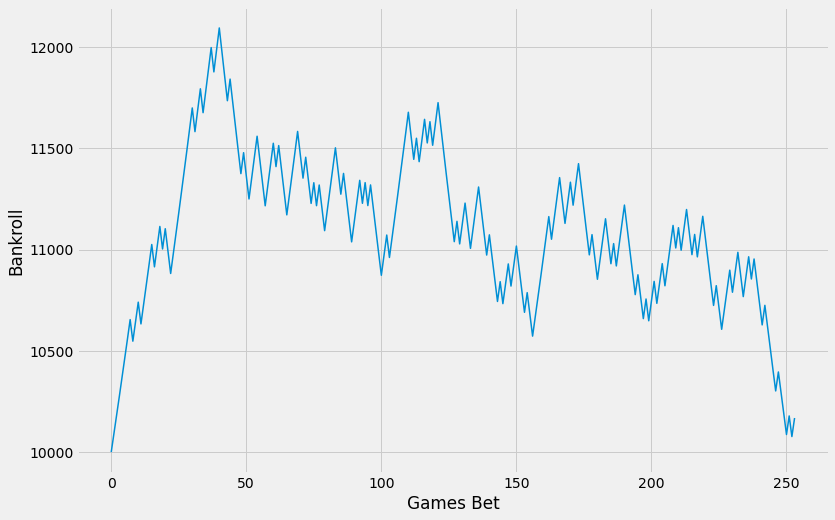

min balance: 10076.67402720275 
max balance: 12093.607067231336 
final balance: 10260.719065220253 
win percentage 53.15


index  GAME_DATE  spread  point_diff_team     preds  home_cover  \
0    18092 2015-11-05     4.5               19  2.637812         1.0   
1    18135 2015-11-11   -13.0                8  5.212560         0.0   
2    18305 2015-12-05     2.5               15  5.465413         1.0   
3    18467 2015-12-27   -16.5               10  8.768078         0.0   
4    18476 2015-12-28     9.5               -4 -1.420319         1.0   
..     ...        ...     ...              ...       ...         ...   
249  24068 2020-09-11     3.5               -5  3.960602         0.0   
250  24070 2020-09-13     8.5               13 -0.520397         1.0   
251  24075 2020-09-19     3.5              -11  3.815575         0.0   
252  24085 2020-10-04     9.5               11 -0.496515         1.0   
253  24086 2020-10-06     7.5               -6  0.252272         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        1  10000.000000  10090.909091  100.000000    7.137812  
1           0        1  10090.909091  10182.644628  100.909091   -7.787440  
2           1        1  10182.644628  10275.214125  101.826446    7.965413  
3           0        1  10275.214125  10368.625162  102.752141   -7.731922  
4           1        1  10368.625162  10462.885391  103.686252    8.079681  
..        ...      ...           ...           ...         ...         ...  
249         1        0  10188.647261  10086.760788  101.886473    7.460602  
250         1        1  10086.760788  10178.458613  100.867608    7.979603  
251         1        0  10178.458613  10076.674027  101.784586    7.315575  
252         1        1  10076.674027  10168.280155  100.766740    9.003485  
253         1        1  10168.280155  10260.719065  101.682802    7.752272  

[254 rows x 12 columns]

In [405]:
ridge_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('ridge', Ridge())])


params = {"ridge__alpha":np.logspace(-3, 2, 30)}

ridge_cv = GridSearchCV(ridge_pipeline, params, scoring='neg_root_mean_squared_error', cv=tscv)
ridge_cv.fit(X_train, point_diff_train_windsor)

print(ridge_cv.best_estimator_)

best_ridge = ridge_cv.best_estimator_

ridge_preds = best_ridge.predict(X_test)

select_bets_ridge, bet_thresholds_ridge = find_optimal_threshold(ridge_preds, test_indices)

simulate_bets(select_bets_ridge)

### Lasso Regression

In [519]:
lasso_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(max_iter=20000))])


params = {"lasso__alpha":np.logspace(-3, 3, 30)}

lasso_cv = GridSearchCV(lasso_pipeline, params, scoring='neg_root_mean_squared_error', cv=tscv)
lasso_cv.fit(X_train, point_diff_train)

print(lasso_cv.best_estimator_)

best_lasso= lasso_cv.best_estimator_

lasso_preds = best_lasso.predict(X_test)

select_bets_lasso, bet_thresholds_lasso = find_optimal_threshold(lasso_preds, test_indices)

simulate_bets(select_bets_lasso)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 258.6725481300382, tolerance: 49.18794522546418
  positive)


KeyboardInterrupt: 

<AxesSubplot:ylabel='feature'>

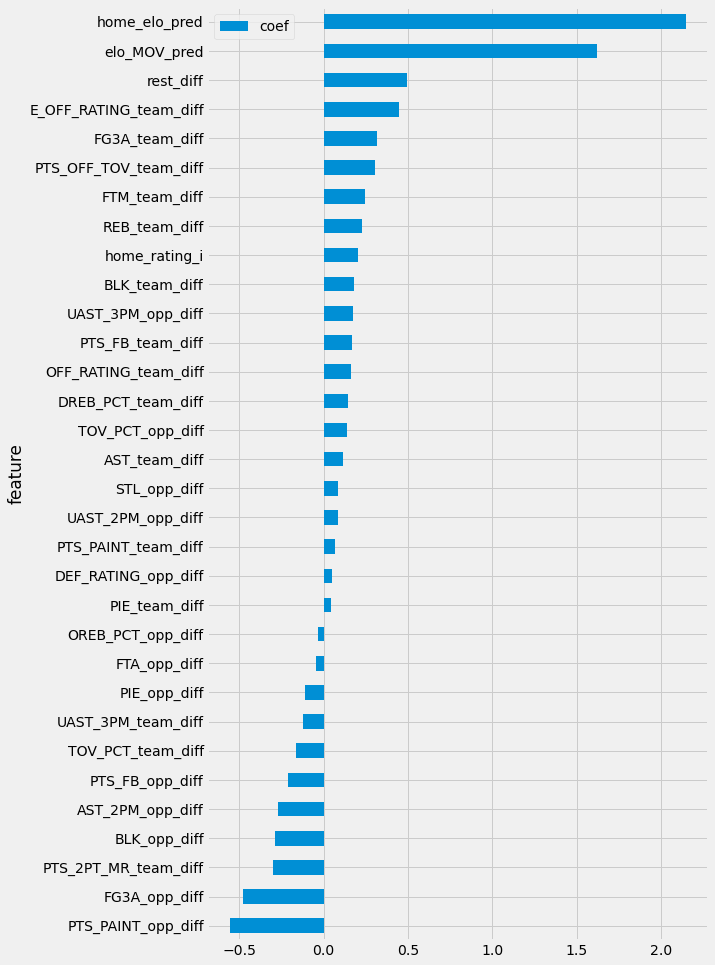

In [342]:
feature_names = X_train.columns
lasso_coefficients = best_lasso.named_steps['lasso'].coef_

lasso_coefs = pd.DataFrame({'feature':feature_names, 'coef':lasso_coefficients})
lasso_coefs.loc[lasso_coefs['coef'] !=0].sort_values('coef').plot(x='feature',kind='barh', figsize=(8,16))

#### Predicting Spread + Actual Point Diff

In [520]:
lasso_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(max_iter=20000))])


params = {"lasso__alpha":np.logspace(-3, 3, 30)}

lasso_cv = GridSearchCV(lasso_pipeline, params, scoring='neg_mean_absolute_error', cv=tscv)
lasso_cv.fit(X_train_spread, spread_point_diff_train)

print(lasso_cv.best_estimator_)

best_lasso= lasso_cv.best_estimator_

lasso_preds = best_lasso.predict(X_test_spread)



C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2105.8663179949217, tolerance: 27.21964898167006
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.39100485484232, tolerance: 27.21964898167006
  positive)


Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.0727895384398315, max_iter=20000))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 0.8
num_games_bet: 1807
win percetange at threshold: 0.5329275041505257


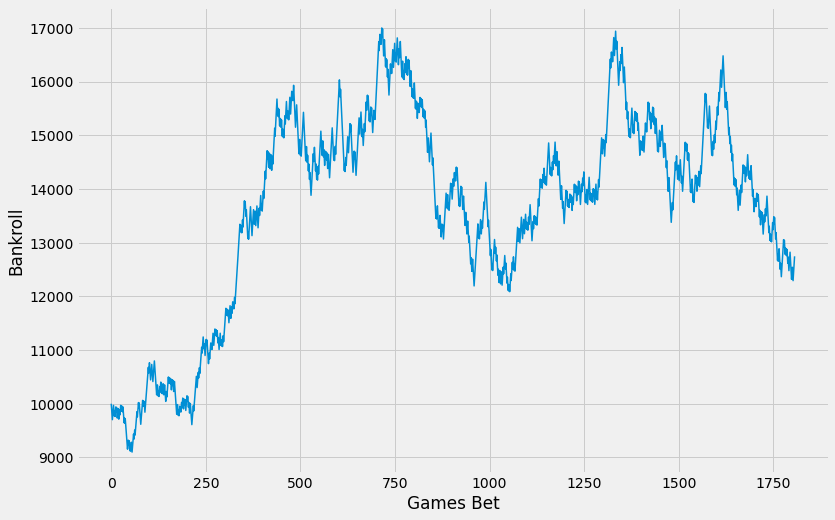

min balance: 9099.511529576148 
max balance: 16997.46461436011 
final balance: 12617.607237692144 
win percentage 53.290000000000006


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0     11776 2016-11-04     3.5              -14          1.194684         0.0   
1     11778 2016-11-05    -3.5               26         -1.360325         1.0   
2     11781 2016-11-06    -4.0               11         -1.404474         1.0   
3     11782 2016-11-06    -7.5               -5         -1.153785         0.0   
4     11783 2016-11-06    -3.0               11          0.818949         1.0   
...     ...        ...     ...              ...               ...         ...   
1802  16483 2020-09-23     3.5                3          1.646878         1.0   
1803  16486 2020-09-26    -5.5               10          1.427627         1.0   
1804  16487 2020-09-27     3.0               12          0.969972         1.0   
1805  16488 2020-09-30    -4.5               18          0.862366         1.0   
1806  16492 2020-10-09    -7.5               -3          0.822936         0.0   

      bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0            1        0  10000.000000   9900.000000  100.000000  
1            0        0   9900.000000   9801.000000   99.000000  
2            0        0   9801.000000   9702.990000   98.010000  
3            0        1   9702.990000   9791.199000   97.029900  
4            1        1   9791.199000   9880.209900   97.911990  
...        ...      ...           ...           ...         ...  
1802         1        1  12291.945766  12403.690727  122.919458  
1803         1        1  12403.690727  12516.451552  124.036907  
1804         1        1  12516.451552  12630.237475  125.164516  
1805         1        1  12630.237475  12745.057816  126.302375  
1806         1        0  12745.057816  12617.607238  127.450578  

[1807 rows x 11 columns]

In [521]:
select_bets_lasso, bet_thresholds_lasso = find_optimal_confidence_thresholds(lasso_preds, test_indices)
simulate_bets(select_bets_lasso)

#### Lasso EWM

In [673]:
lasso_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(max_iter=20000))])


params = {"lasso__alpha":np.logspace(-3, 3, 30)}

lasso_cv = GridSearchCV(lasso_pipeline, params, scoring='neg_mean_absolute_error', cv=tscv)
lasso_cv.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

print(lasso_cv.best_estimator_)

best_lasso= lasso_cv.best_estimator_

lasso_preds = best_lasso.predict(X_test_ewm_19)



C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1115.366500182019, tolerance: 27.21964898167006
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259.1148217860027, tolerance: 54.486963346917975
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 386.0257057059789, tolerance: 107.18618842038217
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.0727895384398315, max_iter=20000))])


best thresholds: 1.6


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


num_games_bet: 347
win percetange at threshold: 0.5389048991354467


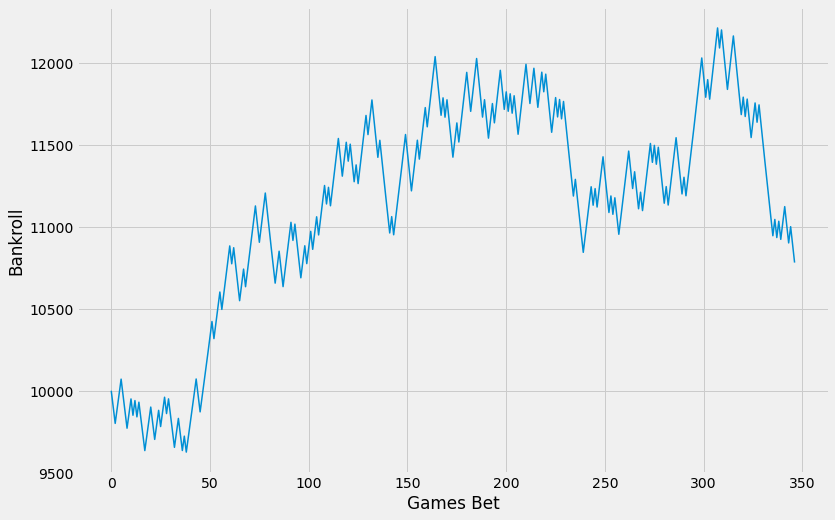

min balance: 9626.073585291268 
max balance: 12211.296454274776 
final balance: 10879.177037795616 
win percentage 53.89000000000001


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11786 2016-11-07    -7.0               32         -1.860777         1.0   
1    11787 2016-11-07    -8.0               32         -1.691187         1.0   
2    11792 2016-11-08    -4.0              -12         -2.638491         0.0   
3    11803 2016-11-09    -3.0              -16         -2.174529         0.0   
4    11834 2016-11-14   -11.0                4         -2.524888         0.0   
..     ...        ...     ...              ...               ...         ...   
342  16437 2020-08-23    14.0              -28          2.341652         0.0   
343  16445 2020-08-29    -5.0               34          1.919376         1.0   
344  16455 2020-09-02    -5.5                2          2.135449         0.0   
345  16480 2020-09-19     3.5              -11          1.702986         0.0   
346  16483 2020-09-23     3.5                3          1.897914         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           0        0   9900.000000   9801.000000   99.000000  
2           0        1   9801.000000   9890.100000   98.010000  
3           0        1   9890.100000   9980.010000   98.901000  
4           0        1   9980.010000  10070.737364   99.800100  
..        ...      ...           ...           ...         ...  
342         1        0  11011.078862  10900.968073  110.110789  
343         1        1  10900.968073  11000.067783  109.009681  
344         1        0  11000.067783  10890.067105  110.000678  
345         1        0  10890.067105  10781.166434  108.900671  
346         1        1  10781.166434  10879.177038  107.811664  

[347 rows x 11 columns]

In [674]:
select_bets_lasso, bet_thresholds_lasso = find_optimal_confidence_thresholds(lasso_preds, test_indices)
simulate_bets(select_bets_lasso)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 1.6
num_games_bet: 342
win percetange at threshold: 0.5789473684210527


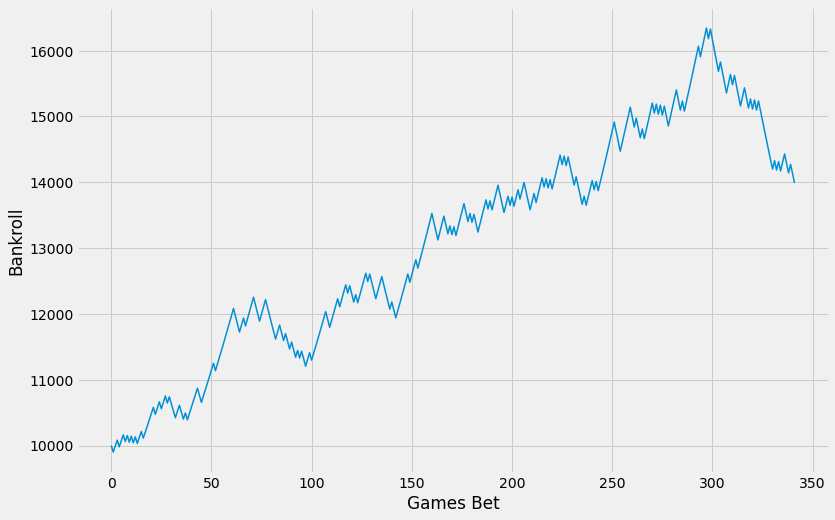

min balance: 9900.0 
max balance: 16344.092784352437 
final balance: 14114.521528356388 
win percentage 57.89


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11785 2016-11-07    -5.5               12         -1.693005         1.0   
1    11786 2016-11-07   -16.5               10         -1.861808         0.0   
2    11792 2016-11-08    -4.0              -12         -2.638555         0.0   
3    11804 2016-11-09   -18.5               21         -2.175915         1.0   
4    11834 2016-11-14   -11.0                4         -2.527432         0.0   
..     ...        ...     ...              ...               ...         ...   
337  16437 2020-08-23    14.0              -28          2.343928         0.0   
338  16445 2020-08-29    -5.0               34          1.919441         1.0   
339  16455 2020-09-02    -5.5                2          2.135287         0.0   
340  16480 2020-09-19     3.5              -11          1.704034         0.0   
341  16483 2020-09-23     3.5                3          1.899060         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           0        1   9900.000000   9990.000000   99.000000  
2           0        1   9990.000000  10080.818182   99.900000  
3           0        0  10080.818182   9980.010000  100.808182  
4           0        1   9980.010000  10070.737364   99.800100  
..        ...      ...           ...           ...         ...  
337         1        0  14285.649466  14142.792972  142.856495  
338         1        1  14142.792972  14271.363817  141.427930  
339         1        0  14271.363817  14128.650179  142.713638  
340         1        0  14128.650179  13987.363677  141.286502  
341         1        1  13987.363677  14114.521528  139.873637  

[342 rows x 11 columns]

In [50]:
lasso_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.0727895384398315, max_iter=20000))])


lasso_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

lasso_preds = lasso_pipe.predict(X_test_ewm_19)

select_bets_lasso, bet_thresholds_lasso = find_optimal_confidence_thresholds(lasso_preds, test_indices)
simulate_bets(select_bets_lasso)

#### Windsor Outliers

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444.17532778484747, tolerance: 112.39359464956888
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216.31433380930685, tolerance: 112.39359464956888
  positive)


Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.02807216203941177, max_iter=20000))])
best thresholds: (6, 16)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


num_games_bet: 465
win percetange at threshold: 0.5311827956989247


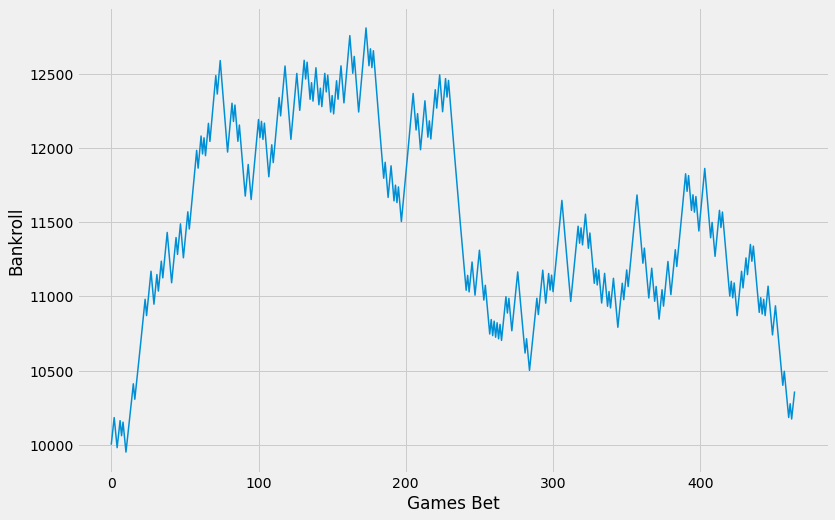

min balance: 9950.09990004999 
max balance: 12810.88004219596 
final balance: 10453.336924433996 
win percentage 53.12


index  GAME_DATE  spread  point_diff_team     preds  home_cover  \
0    18092 2015-11-05     4.5               19  2.996029         1.0   
1    18101 2015-11-07    14.0               -9 -7.310992         1.0   
2    18117 2015-11-09    10.5              -23 -4.056153         0.0   
3    18120 2015-11-10     6.5              -24  0.147166         0.0   
4    18129 2015-11-11     7.0               10 -0.599000         1.0   
..     ...        ...     ...              ...       ...         ...   
460  24070 2020-09-13     8.5               13 -0.781263         1.0   
461  24075 2020-09-19     3.5              -11  3.811741         0.0   
462  24078 2020-09-23     3.5                3  3.284565         1.0   
463  24085 2020-10-04     9.5               11 -0.555985         1.0   
464  24086 2020-10-06     7.5               -6  0.291481         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        1  10000.000000  10090.909091  100.000000    7.496029  
1           1        1  10090.909091  10182.644628  100.909091    6.689008  
2           1        0  10182.644628  10080.818182  101.826446    6.443847  
3           1        0  10080.818182   9980.010000  100.808182    6.647166  
4           1        1   9980.010000  10070.737364   99.800100    6.401000  
..        ...      ...           ...           ...         ...         ...  
460         1        1  10183.535446  10276.113041  101.835354    7.718737  
461         1        0  10276.113041  10173.351910  102.761130    7.311741  
462         1        1  10173.351910  10265.836928  101.733519    6.784565  
463         1        1  10265.836928  10359.162718  102.658369    8.944015  
464         1        1  10359.162718  10453.336924  103.591627    7.791481  

[465 rows x 12 columns]

In [406]:
lasso_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(max_iter=20000))])

params = {"lasso__alpha":np.logspace(-3, 3, 30)}

lasso_cv = GridSearchCV(lasso_pipeline, params, scoring='neg_root_mean_squared_error', cv=tscv)
lasso_cv.fit(X_train, point_diff_train_windsor)

print(lasso_cv.best_estimator_)

best_lasso= lasso_cv.best_estimator_

lasso_preds = best_lasso.predict(X_test)

select_bets_lasso, bet_thresholds_lasso = find_optimal_threshold(lasso_preds, test_indices)

simulate_bets(select_bets_lasso)

### Light GBM

In [159]:
lgbr = lgb.LGBMRegressor()

search_spaces = {'min_child_weight':Integer(1,8),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 30),
              'reg_lambda': Integer(1, 10),
              'reg_alpha': Integer(0, 10),
                'boosting_type':Categorical(['gbdt'], transform='string'),
                'num_leaf':Integer(1, 2048),
                'feature_fraction':Real(0.01, 1)}
    
    
lgbr_bs = BayesSearchCV(lgb.LGBMRegressor(objective='regression', subsample_freq=1), search_spaces=search_spaces, cv=tscv, verbose=1, n_jobs=-1)

lgbr_bs.fit(X_train, point_diff_train)

best_lgbr = lgbr_bs.best_estimator_


lgbr_preds = best_lgbr.predict(X_test)

print("score:", best_lgbr.score(X_test, point_diff_test))
print("best_lgbr:", best_lgbr)
print("mae", mean_absolute_error(point_diff_test, lgbr_preds))



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


[LightGBM] [Warning] feature_fraction is set=0.1883400819365125, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.1883400819365125
[LightGBM] [Warning] num_leaves is set=31, num_leaf=2048 will be ignored. Current value: num_leaves=31
score: 0.15845000102569495
best_lgbr: LGBMRegressor(colsample_bytree=0.5, feature_fraction=0.1883400819365125,
              max_depth=3, min_child_weight=1, num_leaf=2048,
              objective='regression', reg_alpha=10, reg_lambda=9,
              subsample_freq=1)
mae 10.00527377670259


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (6, 9)
num_games_bet: 436
win percetange at threshold: 0.5389908256880734


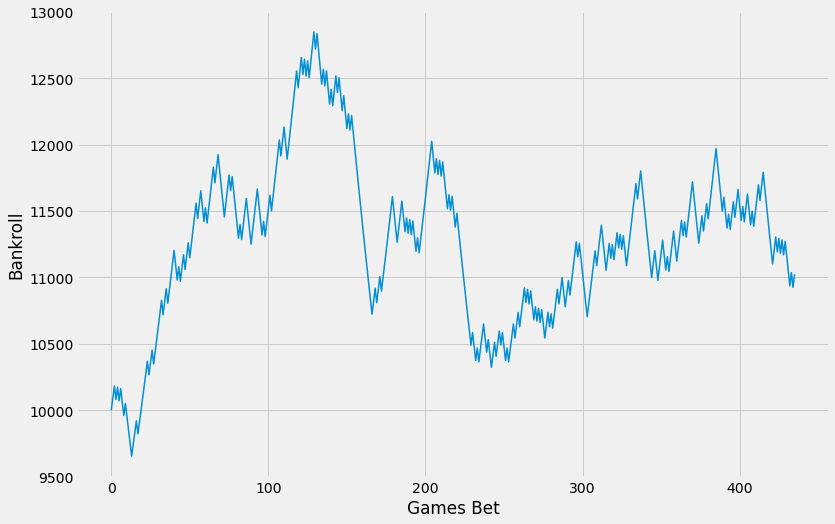

min balance: 9654.571982918605 
max balance: 12848.224738345409 
final balance: 11124.823175856578 
win percentage 53.900000000000006


index  GAME_DATE  spread  point_diff_team     preds  home_cover  \
0    18092 2015-11-05     4.5               19  3.271399         1.0   
1    18101 2015-11-07    14.0               -9 -7.818927         1.0   
2    18120 2015-11-10     6.5              -24 -0.227890         0.0   
3    18129 2015-11-11     7.0               10 -0.279020         1.0   
4    18134 2015-11-11     6.5              -12  0.083887         0.0   
..     ...        ...     ...              ...       ...         ...   
431  24068 2020-09-11     3.5               -5  3.730549         0.0   
432  24070 2020-09-13     8.5               13 -1.993378         1.0   
433  24075 2020-09-19     3.5              -11  2.722971         0.0   
434  24078 2020-09-23     3.5                3  2.983505         1.0   
435  24086 2020-10-06     7.5               -6  0.759078         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        1  10000.000000  10090.909091  100.000000    7.771399  
1           1        1  10090.909091  10182.644628  100.909091    6.181073  
2           1        0  10182.644628  10080.818182  101.826446    6.272110  
3           1        1  10080.818182  10172.461983  100.808182    6.720980  
4           1        0  10172.461983  10070.737364  101.724620    6.583887  
..        ...      ...           ...           ...         ...         ...  
431         1        0  11046.681861  10936.215042  110.466819    7.230549  
432         1        1  10936.215042  11035.635179  109.362150    6.506622  
433         1        0  11035.635179  10925.278827  110.356352    6.222971  
434         1        1  10925.278827  11024.599544  109.252788    6.483505  
435         1        1  11024.599544  11124.823176  110.245995    8.259078  

[436 rows x 12 columns]

In [176]:
best_lgbr = lgb.LGBMRegressor(colsample_bytree=0.5, feature_fraction=0.1883400819365125,
              max_depth=3, min_child_weight=1, num_leaf=2048,
              objective='regression', reg_alpha=10, reg_lambda=9,
              subsample_freq=1)

best_lgbr.fit(X_train, point_diff_train)
lgbr_preds = best_lgbr.predict(X_test)

select_bets_lgbr, bet_thresholds_lgbr= find_optimal_threshold(lgbr_preds, test_indices)
simulate_bets(select_bets_lgbr)

#### Predicting Spread + Actual Point Diff as Proxy for Confidence of Covering

In [ ]:
lgbr = lgb.LGBMRegressor()

search_spaces = {'min_child_weight':Integer(1,8),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 30),
              'reg_lambda': Integer(1, 10),
              'reg_alpha': Integer(0, 10),
                'boosting_type':Categorical(['gbdt'], transform='string'),
                'num_leaf':Integer(1, 2048),
                'feature_fraction':Real(0.01, 1)}
    
    
lgbr_bs = BayesSearchCV(lgb.LGBMRegressor(objective='regression', subsample_freq=1),
                        search_spaces=search_spaces, scoring='neg_mean_absolute_error', 
                        cv=tscv, verbose=1, n_jobs=-1)

lgbr_bs.fit(X_train_spread, spread_point_diff_train)

best_lgbr = lgbr_bs.best_estimator_


lgbr_preds = best_lgbr.predict(X_test_spread)

print("best_lgbr:", best_lgbr)
print("mae", mean_absolute_error(spread_point_diff_test, lgbr_preds))

select_bets_lgbr, bet_thresholds_lgbr= find_optimal_confidence_thresholds(lgbr_preds, test_indices)
simulate_bets(select_bets_lgbr)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 1.8
num_games_bet: 66
win percetange at threshold: 0.5606060606060606


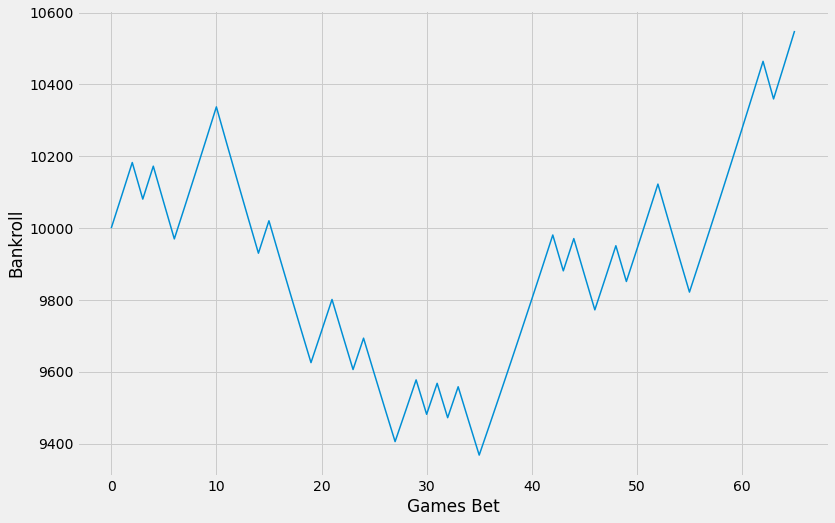

min balance: 9368.246217015174 
max balance: 10548.879052539998 
final balance: 10443.390262014598 
win percentage 56.06


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0   11803 2016-11-09    -3.0              -16         -1.916177         0.0   
1   11810 2016-11-11     4.5              -13         -1.909348         0.0   
2   11818 2016-11-12    -3.0               10         -2.417337         1.0   
3   11892 2016-11-21    -7.0                4         -2.115921         0.0   
4   11924 2016-11-25   -13.0               38         -2.284798         1.0   
5   12019 2016-12-08    -5.5                7         -1.817494         1.0   
6   12037 2016-12-10    -9.5                5         -1.986271         0.0   
7   12058 2016-12-13    -5.5               -5         -1.978721         0.0   
8   12081 2016-12-16   -11.0                3         -1.929851         0.0   
9   12237 2017-01-06   -14.0               -9         -1.878534         0.0   
10  12281 2017-01-13   -11.0               33         -2.294792         1.0   
11  12436 2017-02-03    -3.0                4         -1.948661         1.0   
12  12491 2017-02-10     8.0              -15          2.404859         0.0   
13  12499 2017-02-11     8.0              -16          2.153716         0.0   
14  12513 2017-02-13    -8.0               -6         -2.234245         0.0   
15  12535 2017-02-15    -6.5                9         -1.826979         1.0   
16  12649 2017-03-09     2.5               10         -1.983613         1.0   
17  12669 2017-03-11    -6.5               20         -1.864828         1.0   
18  12777 2017-03-26   -13.0               -1          1.829735         0.0   
19  12843 2017-04-04   -14.5               14         -1.831439         0.0   
20  12939 2017-04-21     2.5              -17         -2.232866         0.0   
21  12988 2017-05-20     9.5              -12          2.421893         0.0   
22  12990 2017-05-22    11.0              -14          1.830138         0.0   
23  13000 2017-10-28     1.0               -2         -1.849404         0.0   
24  13005 2017-10-29    -4.0                7         -1.969881         1.0   
25  13146 2017-11-18     6.0               32         -2.181830         1.0   
26  13203 2017-11-25   -19.0               15          2.073202         0.0   
27  13289 2017-12-08     5.5               -4          1.863039         1.0   
28  13291 2017-12-08    -9.5               -8         -1.988926         0.0   
29  13309 2017-12-11   -14.0                7          2.219168         0.0   
30  13310 2017-12-11    -1.5              -25         -1.842282         0.0   
31  13417 2017-12-26    -6.0               24         -2.137240         1.0   
32  13424 2017-12-27    -3.5              -10         -2.052066         0.0   
33  13537 2018-01-12    -6.5                9         -2.136692         1.0   
34  13584 2018-01-19    -6.5               18         -1.930435         1.0   
35  13612 2018-01-23    -7.5               -6         -1.917261         0.0   
36  13662 2018-01-30     8.0               30          2.241116         1.0   
37  13732 2018-02-09    -3.5              -13         -1.861926         0.0   
38  13763 2018-02-13    -7.5                5         -1.930614         0.0   
39  13822 2018-02-27    -3.0               -3         -1.856235         0.0   
40  13975 2018-03-20   -14.0               -5         -1.977494         0.0   
41  14019 2018-03-26   -13.0               -8         -1.970081         0.0   
42  14031 2018-03-27     2.0               19         -1.973078         1.0   
43  14246 2018-10-30    -4.5               -8         -1.849974         0.0   
44  14277 2018-11-03    -4.5               15         -2.426715         1.0   
45  14290 2018-11-05    -5.5               11         -2.557083         1.0   
46  14372 2018-11-17   -12.0               20          2.160258         1.0   
47  14534 2018-12-09    -5.0               -5         -1.852168         0.0   
48  14694 2018-12-31     1.5                9         -2.187144         1.0   
49  14782 2019-01-12    -7.5               -5         

In [523]:
select_bets_lgbr, bet_thresholds_lgbr= find_optimal_confidence_thresholds(lgbr_preds, test_indices)
simulate_bets(select_bets_lgbr)

#### LGB EWM

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=0.8678435885410023 will be ignored. Current value: feature_fraction=0.01
best_lgbr: LGBMRegressor(colsample_bytree=0.8678435885410023, feature_fraction=0.01,
              max_depth=25, min_child_weight=7, num_leaves=2,
              objective='regression', reg_alpha=20, reg_lambda=13,
              subsample_freq=1)
mae 9.777524702563506
best thresholds: 0.6
num_games_bet: 686
win percetange at threshold: 0.5626822157434402


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


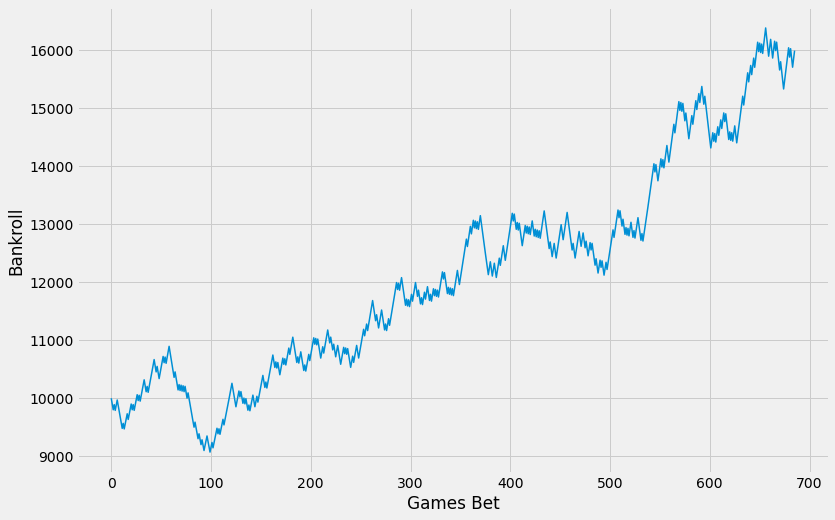

min balance: 9073.062856697134 
max balance: 16374.550858157438 
final balance: 16130.644495006716 
win percentage 56.269999999999996


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11778 2016-11-05    -3.5               26         -1.080836         1.0   
1    11799 2016-11-09     4.5                7         -0.723786         1.0   
2    11803 2016-11-09    -3.0              -16         -0.867930         0.0   
3    11814 2016-11-11     5.0               -2         -0.679589         1.0   
4    11820 2016-11-12     1.5               -6         -1.211628         0.0   
..     ...        ...     ...              ...               ...         ...   
681  16398 2020-08-12     4.0                1         -0.695988         1.0   
682  16404 2020-08-13    -4.0                6         -0.719260         1.0   
683  16452 2020-08-31    -5.0              -11         -0.871636         0.0   
684  16467 2020-09-08     5.5               -9         -0.763581         0.0   
685  16477 2020-09-15    -2.0               -3         -0.624095         0.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           0        0   9900.000000   9801.000000   99.000000  
2           0        1   9801.000000   9890.100000   98.010000  
3           0        0   9890.100000   9791.199000   98.901000  
4           0        1   9791.199000   9880.209900   97.911990  
..        ...      ...           ...           ...         ...  
681         0        0  16017.342040  15857.168620  160.173420  
682         0        0  15857.168620  15698.596934  158.571686  
683         0        1  15698.596934  15841.311451  156.985969  
684         0        1  15841.311451  15985.323373  158.413115  
685         0        1  15985.323373  16130.644495  159.853234  

[686 rows x 11 columns]

In [667]:
lgbr = lgb.LGBMRegressor()

search_spaces = {'min_child_weight':Integer(6,12),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 30),
              'reg_lambda': Integer(12, 20),
              'reg_alpha': Integer(12, 20),
                'boosting_type':Categorical(['gbdt'], transform='string'),
                'feature_fraction':Real(0.01, 1),
                'num_leaves':Integer(2, 2048)}
    
    
lgbr_bs = BayesSearchCV(lgb.LGBMRegressor(objective='regression', subsample_freq=1),
                        search_spaces=search_spaces, scoring='neg_mean_absolute_error', 
                        cv=tscv, verbose=1, n_jobs=-1)

lgbr_bs.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

best_lgbr = lgbr_bs.best_estimator_


lgbr_preds = best_lgbr.predict(X_test_ewm_19)

print("best_lgbr:", best_lgbr)
print("mae", mean_absolute_error(spread_point_diff_test, lgbr_preds))

select_bets_lgbr, bet_thresholds_lgbr= find_optimal_confidence_thresholds(lgbr_preds, test_indices)
simulate_bets(select_bets_lgbr)

[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=0.8678435885410023 will be ignored. Current value: feature_fraction=0.01


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 0.7
num_games_bet: 441
win percetange at threshold: 0.5873015873015873


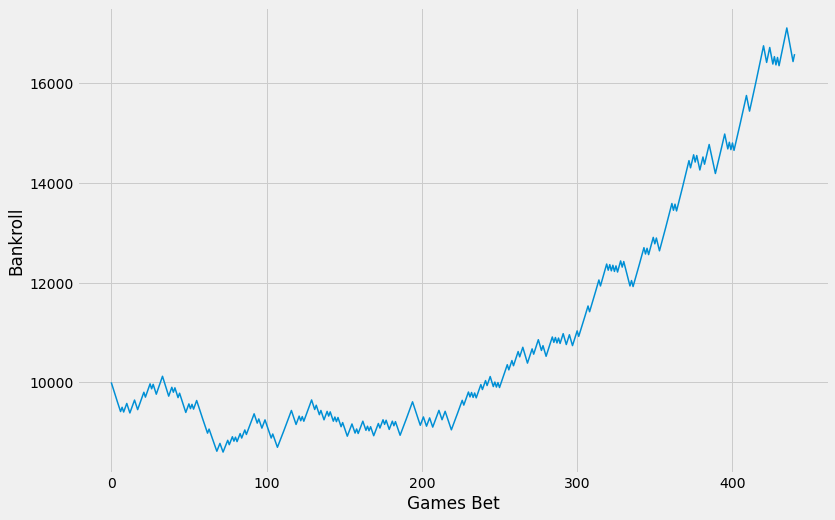

min balance: 8601.753284268498 
max balance: 17106.06432776598 
final balance: 16732.139106001796 
win percentage 58.730000000000004


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11779 2016-11-05    -3.5               26         -1.041997         1.0   
1    11804 2016-11-09   -18.5               21         -0.839228         1.0   
2    11820 2016-11-12   -10.0               11         -0.876827         1.0   
3    11822 2016-11-12    -3.0               10         -1.171613         1.0   
4    11858 2016-11-17    -5.5                7         -0.809426         1.0   
..     ...        ...     ...              ...               ...         ...   
436  16395 2020-08-11    -3.0                6         -0.906893         1.0   
437  16399 2020-08-12     4.0                1         -0.720216         1.0   
438  16401 2020-08-13    -4.0                6         -0.704323         1.0   
439  16452 2020-08-31    -5.0              -11         -0.919173         0.0   
440  16467 2020-09-08     5.5               -9         -0.812845         0.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           0        0   9900.000000   9801.000000   99.000000  
2           0        0   9801.000000   9702.990000   98.010000  
3           0        0   9702.990000   9605.960100   97.029900  
4           0        0   9605.960100   9509.900499   96.059601  
..        ...      ...           ...           ...         ...  
436         0        0  16935.003684  16765.653648  169.350037  
437         0        0  16765.653648  16597.997111  167.656536  
438         0        0  16597.997111  16432.017140  165.979971  
439         0        1  16432.017140  16581.399114  164.320171  
440         0        1  16581.399114  16732.139106  165.813991  

[441 rows x 11 columns]

In [54]:
best_lgbr = lgb.LGBMRegressor(colsample_bytree=0.8678435885410023, feature_fraction=0.01,
              max_depth=25, min_child_weight=7, num_leaves=2,
              objective='regression', reg_alpha=20, reg_lambda=13,
              subsample_freq=1)

best_lgbr.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
lgbr_preds = best_lgbr.predict(X_test_ewm_19)

select_bets_lgbr, bet_thresholds_lgbr= find_optimal_confidence_thresholds(lgbr_preds, test_indices)
simulate_bets(select_bets_lgbr)


#### Windsor Outliers

[LightGBM] [Warning] feature_fraction is set=0.1883400819365125, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.1883400819365125
[LightGBM] [Warning] num_leaves is set=31, num_leaf=2048 will be ignored. Current value: num_leaves=31


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (8, 17)
num_games_bet: 171
win percetange at threshold: 0.5380116959064327


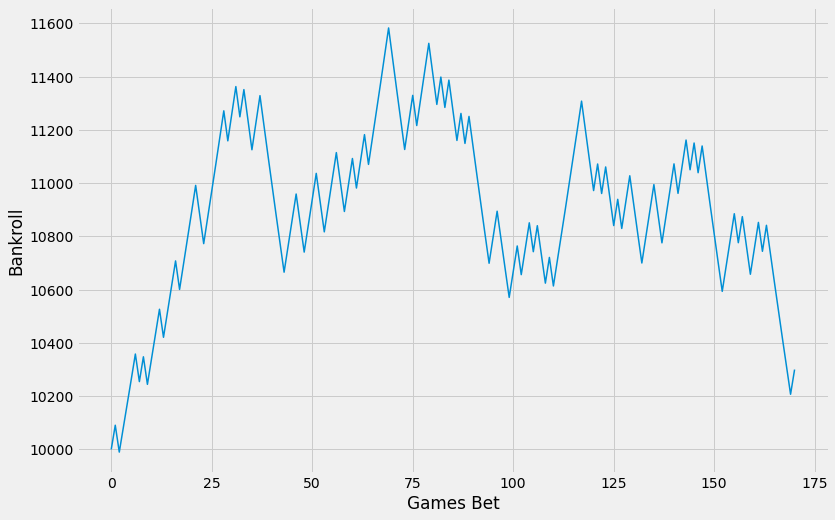

min balance: 9990.0 
max balance: 11582.779387449224 
final balance: 10393.633221062377 
win percentage 53.800000000000004


index  GAME_DATE  spread  point_diff_team      preds  home_cover  \
0    18092 2015-11-05     4.5               19   3.696667         1.0   
1    18149 2015-11-13   -10.5               19   2.493992         1.0   
2    18403 2015-12-18   -19.0                9  10.708798         0.0   
3    18467 2015-12-27   -16.5               10   8.320785         0.0   
4    18476 2015-12-28     9.5               -4  -1.305530         1.0   
..     ...        ...     ...              ...        ...         ...   
166  24032 2020-08-23    14.0              -28  -3.620051         0.0   
167  24037 2020-08-24    13.0              -15  -1.447412         0.0   
168  24044 2020-08-30     9.5              -14  -1.326969         0.0   
169  24085 2020-10-04     9.5               11   0.096549         1.0   
170  24086 2020-10-06     7.5               -6   0.688193         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        1  10000.000000  10090.909091  100.000000    8.196667  
1           0        0  10090.909091   9990.000000  100.909091   -8.006008  
2           0        1   9990.000000  10080.818182   99.900000   -8.291202  
3           0        1  10080.818182  10172.461983  100.808182   -8.179215  
4           1        1  10172.461983  10264.938911  101.724620    8.194470  
..        ...      ...           ...           ...         ...         ...  
166         1        0  10519.648192  10414.451710  105.196482   10.379949  
167         1        0  10414.451710  10310.307193  104.144517   11.552588  
168         1        0  10310.307193  10207.204121  103.103072    8.173031  
169         1        1  10207.204121  10299.996886  102.072041    9.596549  
170         1        1  10299.996886  10393.633221  102.999969    8.188193  

[171 rows x 12 columns]

In [407]:
best_lgbr = lgb.LGBMRegressor(colsample_bytree=0.5, feature_fraction=0.1883400819365125,
              max_depth=3, min_child_weight=1, num_leaf=2048,
              objective='regression', reg_alpha=10, reg_lambda=9,
              subsample_freq=1)

best_lgbr.fit(X_train, point_diff_train_windsor)
lgbr_preds = best_lgbr.predict(X_test)

select_bets_lgbr, bet_thresholds_lgbr= find_optimal_threshold(lgbr_preds, test_indices)
simulate_bets(select_bets_lgbr)

### ADA Boost

In [218]:
ada = AdaBoostRegressor()
search_spaces = {'learning_rate': Real(0.01,1, prior='log-uniform'),
                'loss': Categorical(['linear', 'square', 'exponential']), 
                'n_estimators': Integer(50, 500)}

ada_bs = BayesSearchCV(ada, search_spaces=search_spaces, n_iter=50, cv=tscv, n_jobs=-1, verbose=1)
ada_bs.fit(X_train, point_diff_train)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


OrderedDict([('learning_rate', 0.020117684599365193), ('loss', 'exponential'), ('n_estimators', 245)])
AdaBoostRegressor(learning_rate=0.020117684599365193, loss='exponential',
                  n_estimators=245)


NameError: name 'best_ada' is not defined

OrderedDict([('learning_rate', 0.020117684599365193), ('loss', 'exponential'), ('n_estimators', 245)])
AdaBoostRegressor(learning_rate=0.020117684599365193, loss='exponential',
                  n_estimators=245)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (6, 7)
num_games_bet: 251
win percetange at threshold: 0.5378486055776892


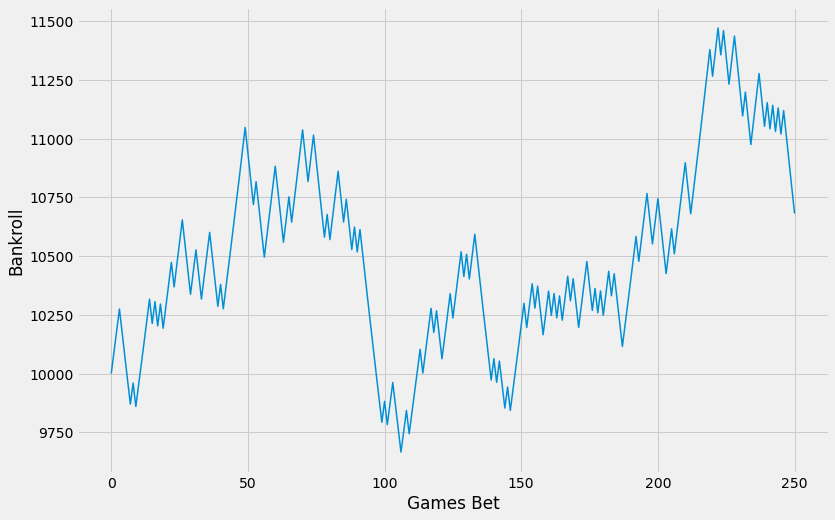

min balance: 9666.42698820673 
max balance: 11471.110954031808 
final balance: 10574.80123675306 
win percentage 53.779999999999994


index  GAME_DATE  spread  point_diff_team      preds  home_cover  \
0    18092 2015-11-05     4.5               19   1.699086         1.0   
1    18129 2015-11-11     7.0               10  -0.352165         1.0   
2    18146 2015-11-13     6.5                9  -0.224871         1.0   
3    18194 2015-11-20    -6.5               -3  12.524220         0.0   
4    18222 2015-11-24     7.0              -17  -0.367004         0.0   
..     ...        ...     ...              ...        ...         ...   
246  24060 2020-09-07     1.5              -22   4.563356         0.0   
247  24064 2020-09-09     8.0              -11  -1.760716         0.0   
248  24066 2020-09-10     5.5              -10   0.973437         0.0   
249  24068 2020-09-11     3.5               -5   3.114026         0.0   
250  24088 2020-10-11     5.5              -13   0.744810         0.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        1  10000.000000  10090.909091  100.000000    6.199086  
1           1        1  10090.909091  10182.644628  100.909091    6.647835  
2           1        1  10182.644628  10275.214125  101.826446    6.275129  
3           1        0  10275.214125  10172.461983  102.752141    6.024220  
4           1        0  10172.461983  10070.737364  101.724620    6.632996  
..        ...      ...           ...           ...         ...         ...  
246         1        0  11119.781156  11008.583345  111.197812    6.063356  
247         1        0  11008.583345  10898.497511  110.085833    6.239284  
248         1        0  10898.497511  10789.512536  108.984975    6.473437  
249         1        0  10789.512536  10681.617411  107.895125    6.614026  
250         1        0  10681.617411  10574.801237  106.816174    6.244810  

[251 rows x 12 columns]

In [219]:
best_ada = ada_bs.best_estimator_
print(ada_bs.best_params_)
print(best_ada_)

ada_preds = best_ada.predict(X_test)
select_bets_ada, best_thresholds_ada= find_optimal_threshold(ada_preds, test_indices)
simulate_bets(select_bets_ada)

#### Predicting Spread + Actual Point Diff

In [533]:
ada = AdaBoostRegressor()
search_spaces = {'learning_rate': Real(0.01,1, prior='log-uniform'),
                'loss': Categorical(['linear', 'square', 'exponential']), 
                'n_estimators': Integer(50, 500)}

ada_bs = BayesSearchCV(ada, search_spaces=search_spaces, n_iter=50, cv=tscv, n_jobs=-1, verbose=1)
ada_bs.fit(X_train_spread, spread_point_diff_train)
best_ada = ada_bs.best_estimator_
ada_preds = best_ada.predict(X_test_spread)
print(best_ada)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.3s finished


ValueError: Number of features of the model must match the input. Model n_features is 85 and input n_features is 84 

AdaBoostRegressor(learning_rate=0.010033907692549427, loss='exponential',
                  n_estimators=63)
best thresholds: 0.9
num_games_bet: 253
win percetange at threshold: 0.549407114624506


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


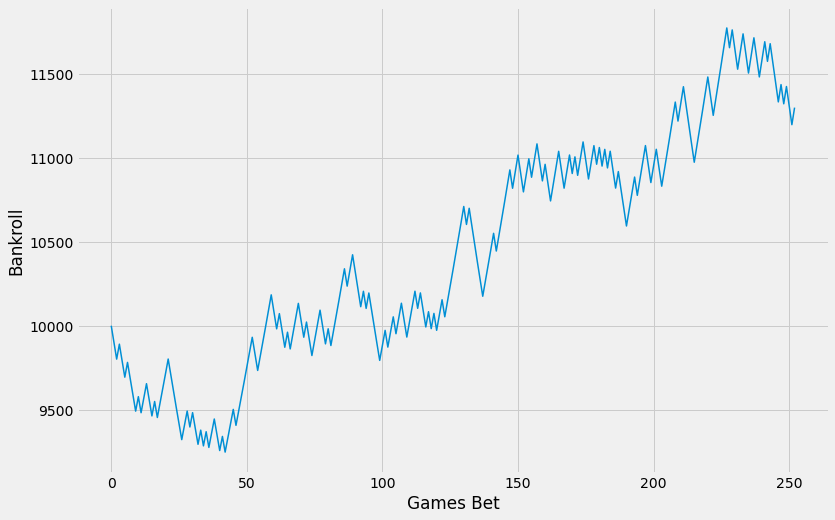

min balance: 9246.767877997183 
max balance: 11775.025317977676 
final balance: 11187.241117113286 
win percentage 54.94


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11779 2016-11-05    -3.0               15         -1.347784         1.0   
1    11786 2016-11-07    -7.0               32         -1.119785         1.0   
2    11792 2016-11-08    -4.0              -12         -1.392420         0.0   
3    11797 2016-11-09   -18.5               21         -0.942622         1.0   
4    11800 2016-11-09    -1.5               25         -1.119785         1.0   
..     ...        ...     ...              ...               ...         ...   
248  16377 2020-08-08    -4.5               -5         -1.251684         0.0   
249  16395 2020-08-11    -4.5               18         -1.055861         1.0   
250  16411 2020-08-17    -4.5               10         -1.055861         1.0   
251  16419 2020-08-19    -3.5              -19         -0.942622         0.0   
252  16464 2020-09-06    -6.0                8         -1.184279         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           0        0   9900.000000   9801.000000   99.000000  
2           0        1   9801.000000   9890.100000   98.010000  
3           0        0   9890.100000   9791.199000   98.901000  
4           0        0   9791.199000   9693.287010   97.911990  
..        ...      ...           ...           ...         ...  
248         0        1  11322.877986  11425.813240  113.228780  
249         0        0  11425.813240  11311.555108  114.258132  
250         0        0  11311.555108  11198.439557  113.115551  
251         0        1  11198.439557  11300.243553  111.984396  
252         0        0  11300.243553  11187.241117  113.002436  

[253 rows x 11 columns]

In [535]:
ada_preds = best_ada.predict(X_test_spread)
print(best_ada)
select_bets_ada, best_thresholds_ada= find_optimal_confidence_thresholds(ada_preds, test_indices)
simulate_bets(select_bets_ada)

### Linear SVR

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   33.4s remaining:   50.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   37.4s remaining:   56.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.1s remaining:   34.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   39.6s remaining:   59.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   42.7s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   40.7s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.7s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   41.0s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   42.6s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.0s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.3s remaining:   21.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   43.4s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.0012612108028070067,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])
best parameters: OrderedDict([('svr__C', 0.0012612108028070067), ('svr__loss', 'squared_epsilon_insensitive')])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (6, 7)
num_games_bet: 219
win percetange at threshold: 0.54337899543379


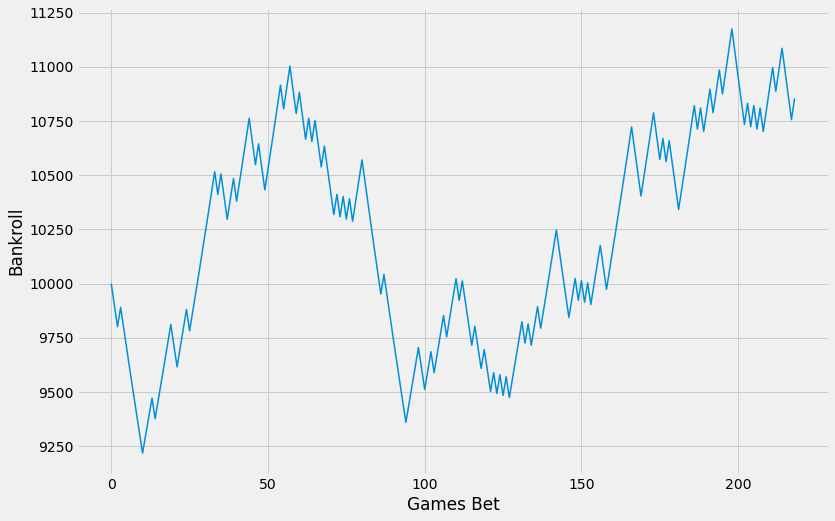

min balance: 9218.219497334923 
max balance: 11174.534063364625 
final balance: 10745.444899699582 
win percentage 54.339999999999996


index  GAME_DATE  spread  point_diff_team     preds  home_cover  \
0    18117 2015-11-09    10.5              -23 -4.182974         0.0   
1    18120 2015-11-10     6.5              -24 -0.221833         0.0   
2    18129 2015-11-11     7.0               10 -0.633952         1.0   
3    18149 2015-11-13   -10.5               19  4.083691         1.0   
4    18282 2015-12-02     2.0              -12  4.181433         0.0   
..     ...        ...     ...              ...       ...         ...   
214  23994 2020-08-12     5.5              -13  0.817356         0.0   
215  23998 2020-08-13    -8.5               26  1.989913         1.0   
216  24022 2020-08-21     5.0               -8  1.272599         0.0   
217  24031 2020-08-23     7.0               -4 -0.837056         1.0   
218  24034 2020-08-24     7.0              -20 -0.563648         0.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  confidence  
0           1        0  10000.000000   9900.000000  100.000000    6.317026  
1           1        0   9900.000000   9801.000000   99.000000    6.278167  
2           1        1   9801.000000   9890.100000   98.010000    6.366048  
3           0        0   9890.100000   9791.199000   98.901000   -6.416309  
4           1        0   9791.199000   9693.287010   97.911990    6.181433  
..        ...      ...           ...           ...         ...         ...  
214         1        0  11085.450053  10974.595552  110.854501    6.317356  
215         0        0  10974.595552  10864.849597  109.745956   -6.510087  
216         1        0  10864.849597  10756.201101  108.648496    6.272599  
217         1        1  10756.201101  10853.984747  107.562011    6.162944  
218         1        0  10853.984747  10745.444900  108.539847    6.436352  

[219 rows x 12 columns]

In [220]:
pipeline_svr = Pipeline([('scaler', StandardScaler()),
                        ('svr', LinearSVR(max_iter=10000))])


search_spaces = {'svr__C': Real(1e-6, 1e+6, prior='log-uniform'),
                'svr__loss' : Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive'])}


svr_bs = BayesSearchCV(pipeline_svr, search_spaces=search_spaces, n_jobs=-1, cv=tscv, verbose=3)
svr_bs.fit(X_train, point_diff_train)

print("best estimator:", svr_bs.best_estimator_)
print("best parameters:", svr_bs.best_params_)
best_svr = svr_bs.best_estimator_
svr_preds = best_svr.predict(X_test)

select_bets_svr, best_thresholds_svr = find_optimal_threshold(svr_preds, test_indices)
simulate_bets(select_bets_svr)

In [524]:
select_bets_svr, best_thresholds_svr = find_optimal_threshold(svr_preds, test_indices)
simulate_bets(select_bets_svr)

ValueError: Length of values (4720) does not match length of index (5998)

#### Predicting Spread + Actual Point Diff as Proxy for Confidence of Covering

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.3s remaining:   38.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   22.9s remaining:   34.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.2s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.0003076281045389281,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])
best parameters: OrderedDict([('svr__C', 0.0003076281045389281), ('svr__loss', 'squared_epsilon_insensitive')])
best thresholds: 3
num_games_bet: 41
win percetange at threshold: 0.6585365853658537


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


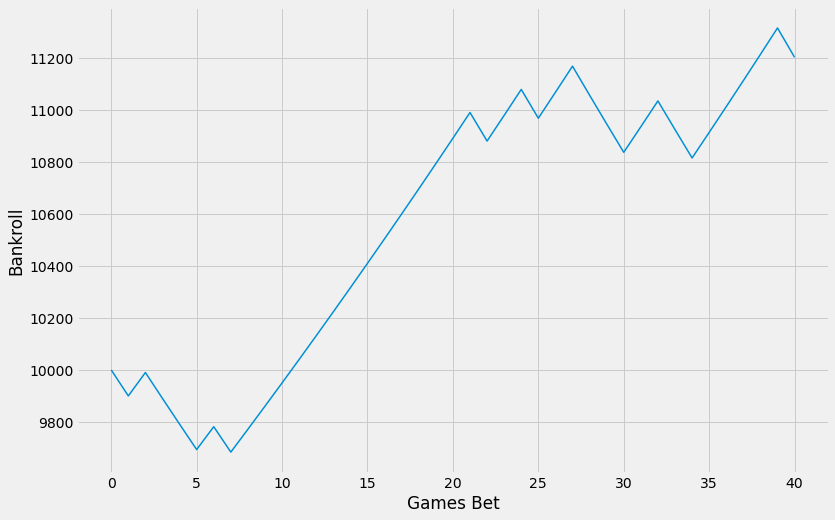

min balance: 9683.59372299 
max balance: 11317.23315304026 
final balance: 11092.02021329476 
win percentage 65.85


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0   12248 2017-01-08    -9.5               12         -3.386551         1.0   
1   12388 2017-01-27   -17.0                8         -3.122763         0.0   
2   13109 2017-11-13     3.0              -11          3.164212         0.0   
3   13125 2017-11-15    -3.5                5         -3.119416         1.0   
4   13252 2017-12-03    10.5              -28          3.701464         0.0   
5   13644 2018-01-27    -6.5                2         -3.279354         0.0   
6   13838 2018-03-01     2.5                5         -3.463751         1.0   
7   13861 2018-03-04    -7.5                3         -5.029615         0.0   
8   13873 2018-03-06   -15.0               13         -3.378135         0.0   
9   13889 2018-03-08    -7.5              -14         -3.127061         0.0   
10  14085 2018-04-04    -7.0               18          3.218103         1.0   
11  14089 2018-04-05    -8.0               22          3.090252         1.0   
12  14242 2018-10-29    -7.0                5         -3.107178         0.0   
13  14437 2018-11-25   -12.0               10         -3.023658         0.0   
14  14610 2018-12-19     2.0                5          3.293717         1.0   
15  14755 2019-01-09   -11.0               10         -3.749111         0.0   
16  14902 2019-01-29    -7.0                5         -3.037556         0.0   
17  14975 2019-02-09    -8.0               20          3.102976         1.0   
18  15012 2019-02-14    -7.5              -15         -3.040194         0.0   
19  15362 2019-04-09     3.0                1          3.038718         1.0   
20  15397 2019-04-19    -7.0               12          3.767699         1.0   
21  15406 2019-04-21    -5.0              -13          3.819046         0.0   
22  15409 2019-04-22     2.0               16          3.355846         1.0   
23  15412 2019-04-23    -4.5                3         -3.671277         0.0   
24  15467 2019-11-03     3.0               29         -3.471269         1.0   
25  15498 2019-11-08    -5.0                3         -3.409990         0.0   
26  15552 2019-11-15   -10.5                2         -3.208168         0.0   
27  15769 2019-12-17   -14.5               21         -3.005266         1.0   
28  16087 2020-02-01   -10.5               12         -3.547204         1.0   
29  16131 2020-02-08     9.0              -16          3.368344         0.0   
30  16133 2020-02-08    10.0               27          3.677128         1.0   
31  16200 2020-02-23   -14.5               12         -3.628144         0.0   
32  16205 2020-02-24   -14.0               16         -3.308429         1.0   
33  16273 2020-03-04    -8.0               21         -4.053001         1.0   
34  16283 2020-03-06     3.5               10          3.159141         1.0   
35  16333 2020-08-01    -1.0               16          7.472183         1.0   
36  16335 2020-08-01     3.0               15          8.824553         1.0   
37  16388 2020-08-10    -4.0               22          3.167673         1.0   
38  16397 2020-08-12     5.5               -4          3.058670         1.0   
39  16409 2020-08-14     2.0               17         -3.209787         1.0   
40  16437 2020-08-23    14.0              -28          3.146172         0.0   

    bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0          0        0  10000.000000   9900.000000  100.000000  
1          0        1   9900.000000   9990.000000   99.000000  
2          1        0   9990.000000   9890.100000   99.900000  
3          0        0   9890.100000   9791.199000   98.901000  
4          1        0   9791.199000   9693.287010   97.911990  
5          0        1   9693.287010   9781.407801   96.932870  
6          0        0   9781.407801   9683.593723   97.814078  
7          0        1   9683.593723   9771.626393   96.835937  
8          0        1   9771.626393   9860.459360   97.716264  
9          0        1   9860.459360   9950.09

In [473]:
pipeline_svr = Pipeline([('scaler', StandardScaler()),
                        ('svr', LinearSVR(max_iter=10000))])


search_spaces = {'svr__C': Real(1e-6, 1e+6, prior='log-uniform'),
                'svr__loss' : Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive'])}


svr_bs = BayesSearchCV(pipeline_svr, search_spaces=search_spaces, n_jobs=-1, cv=tscv, verbose=3)
svr_bs.fit(X_train_spread, spread_point_diff_train)

print("best estimator:", svr_bs.best_estimator_)
print("best parameters:", svr_bs.best_params_)
best_svr = svr_bs.best_estimator_
svr_preds = best_svr.predict(X_test_spread)



C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.8
num_games_bet: 68
win percetange at threshold: 0.6911764705882353


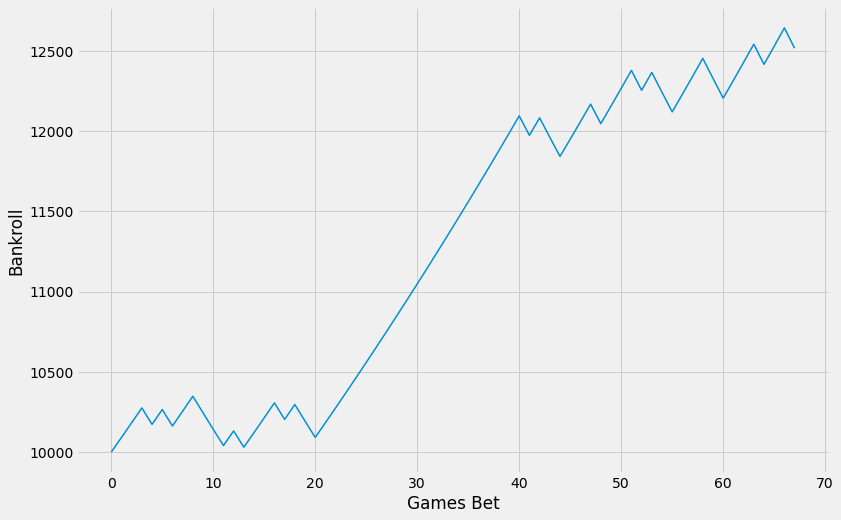

min balance: 10030.514798333123 
max balance: 12641.322118276772 
final balance: 12389.759808123064 
win percentage 69.12


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0   11792 2016-11-08    -4.0              -12         -2.868995         0.0   
1   12026 2016-12-09    -1.5               -4         -2.810785         0.0   
2   12028 2016-12-09     3.5                8          2.916955         1.0   
3   12248 2017-01-08    -9.5               12         -3.386551         1.0   
4   12261 2017-01-10    -1.0                8          2.895441         1.0   
5   12308 2017-01-16    -8.5               22         -2.870259         1.0   
6   12388 2017-01-27   -17.0                8         -3.122763         0.0   
7   12781 2017-03-26    -6.0                4         -2.913660         0.0   
8   12902 2017-04-11    -8.5               27         -2.975788         1.0   
9   13109 2017-11-13     3.0              -11          3.164212         0.0   
10  13125 2017-11-15    -3.5                5         -3.119416         1.0   
11  13149 2017-11-18    -6.0              -40         -2.908159         0.0   
12  13252 2017-12-03    10.5              -28          3.701464         0.0   
13  13400 2017-12-23    -9.5                4         -2.970920         0.0   
14  13410 2017-12-25     1.5               -7         -2.980583         0.0   
15  13592 2018-01-20    -2.5               12          2.918935         1.0   
16  13622 2018-01-24    -6.5               15         -2.993940         1.0   
17  13644 2018-01-27    -6.5                2         -3.279354         0.0   
18  13786 2018-02-22    -8.5               15         -2.940684         1.0   
19  13838 2018-03-01     2.5                5         -3.463751         1.0   
20  13861 2018-03-04    -7.5                3         -5.029615         0.0   
21  13873 2018-03-06   -15.0               13         -3.378135         0.0   
22  13889 2018-03-08    -7.5              -14         -3.127061         0.0   
23  14019 2018-03-26   -13.0               -8         -2.983943         0.0   
24  14085 2018-04-04    -7.0               18          3.218103         1.0   
25  14089 2018-04-05    -8.0               22          3.090252         1.0   
26  14120 2018-04-09     6.0              -10         -2.818796         0.0   
27  14242 2018-10-29    -7.0                5         -3.107178         0.0   
28  14243 2018-10-30    -3.5               18          2.832977         1.0   
29  14420 2018-11-23     4.0               -7         -2.821706         0.0   
30  14437 2018-11-25   -12.0               10         -3.023658         0.0   
31  14533 2018-12-08    -9.5              -23         -2.886754         0.0   
32  14610 2018-12-19     2.0                5          3.293717         1.0   
33  14755 2019-01-09   -11.0               10         -3.749111         0.0   
34  14894 2019-01-28     5.5               -3          2.823883         1.0   
35  14902 2019-01-29    -7.0                5         -3.037556         0.0   
36  14975 2019-02-09    -8.0               20          3.102976         1.0   
37  15012 2019-02-14    -7.5              -15         -3.040194         0.0   
38  15285 2019-03-30    -5.5                9          2.838321         1.0   
39  15362 2019-04-09     3.0                1          3.038718         1.0   
40  15390 2019-04-16    -1.0               20         -2.872725         1.0   
41  15397 2019-04-19    -7.0               12          3.767699         1.0   
42  15400 2019-04-20    -2.0               -3          2.831891         0.0   
43  15406 2019-04-21    -5.0              -13          3.819046         0.0   
44  15409 2019-04-22     2.0               16          3.355846         1.0   
45  15412 2019-04-23    -4.5                3         -3.671277         0.0   
46  15414 2019-04-24    -8.5                7         -2.974175         0.0   
47  15467 2019-11-03     3.0               29         -3.471269         1.0   
48  15473 2019-11-04    11.5                9          2.823409         1.0   
49  15498 2019-11-08    -5.0                3         

In [525]:
select_bets_svr, best_thresholds_svr = find_optimal_confidence_thresholds(svr_preds, test_indices)
simulate_bets(select_bets_svr)

#### Linear SVM EWM

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.00018877550822240589,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])
best parameters: OrderedDict([('svr__C', 0.00018877550822240589), ('svr__epsilon', 0.0), ('svr__loss', 'squared_epsilon_insensitive')])
best thresholds: 1.9
num_games_bet: 298
win percetange at threshold: 0.5536912751677853


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


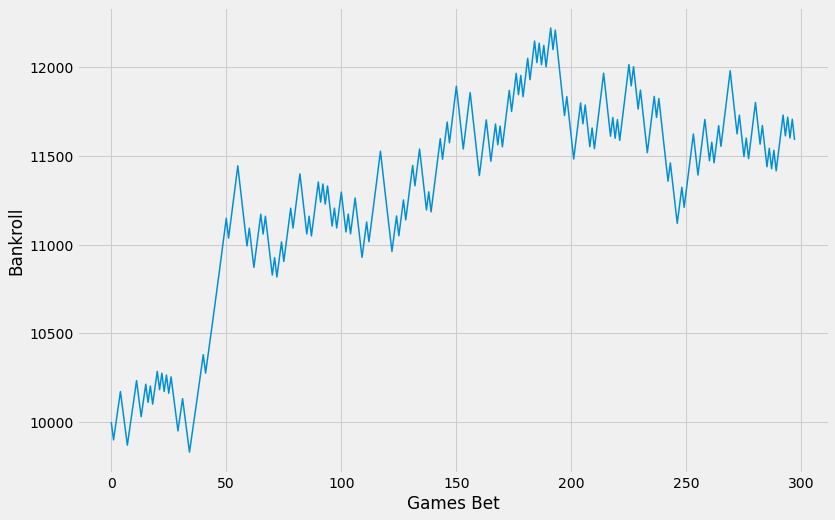

min balance: 9831.353223738244 
max balance: 12220.195688753185 
final balance: 11694.4373112862 
win percentage 55.37


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11786 2016-11-07    -7.0               32         -2.142344         1.0   
1    11792 2016-11-08    -4.0              -12         -2.884867         0.0   
2    11803 2016-11-09    -3.0              -16         -2.221602         0.0   
3    11834 2016-11-14   -11.0                4         -2.336738         0.0   
4    11843 2016-11-15    -4.5              -25          1.912500         0.0   
..     ...        ...     ...              ...               ...         ...   
293  16432 2020-08-22    -5.0                9          2.014478         1.0   
294  16437 2020-08-23    14.0              -28          2.865198         0.0   
295  16445 2020-08-29    -5.0               34          1.944653         1.0   
296  16480 2020-09-19     3.5              -11          2.412903         0.0   
297  16483 2020-09-23     3.5                3          2.638547         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           0        1   9900.000000   9990.000000   99.000000  
2           0        1   9990.000000  10080.818182   99.900000  
3           0        1  10080.818182  10172.461983  100.808182  
4           1        0  10172.461983  10070.737364  101.724620  
..        ...      ...           ...           ...         ...  
293         1        1  11612.294998  11717.861316  116.122950  
294         1        0  11717.861316  11600.682703  117.178613  
295         1        1  11600.682703  11706.143455  116.006827  
296         1        0  11706.143455  11589.082020  117.061435  
297         1        1  11589.082020  11694.437311  115.890820  

[298 rows x 11 columns]

In [649]:
pipeline_svr = Pipeline([('scaler', StandardScaler()),
                        ('svr', LinearSVR(max_iter=10000))])


search_spaces = {'svr__C': Real(1e-6, 1e+6, prior='log-uniform'),
                'svr__loss' : Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive'])}


svr_bs = BayesSearchCV(pipeline_svr, search_spaces=search_spaces, n_jobs=-1, cv=tscv, verbose=1)
svr_bs.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

print("best estimator:", svr_bs.best_estimator_)
print("best parameters:", svr_bs.best_params_)
best_svr = svr_bs.best_estimator_
svr_preds = best_svr.predict(X_test_ewm_19)

select_bets_svr, best_thresholds_svr = find_optimal_confidence_thresholds(svr_preds, test_indices)
simulate_bets(select_bets_svr)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 0.8
num_games_bet: 2066
win percetange at threshold: 0.5353339787028074


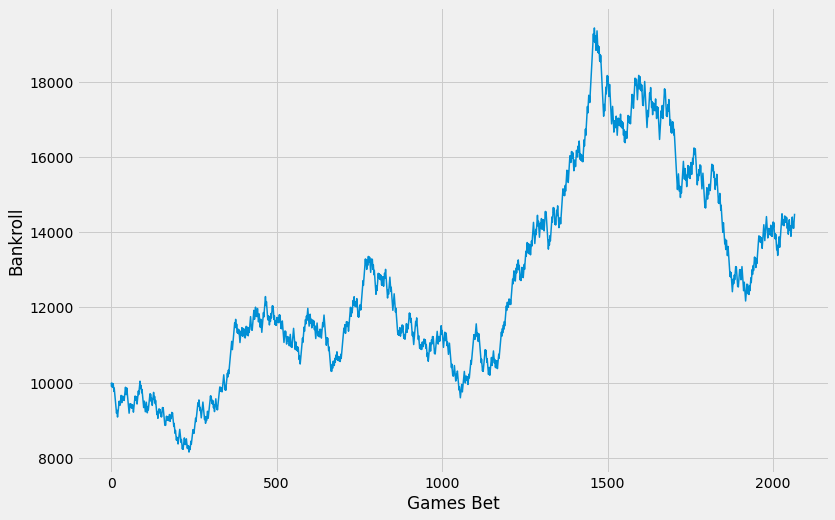

min balance: 8158.624043336692 
max balance: 19424.44568608518 
final balance: 14344.703193953967 
win percentage 53.53


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0     11779 2016-11-05    -3.5               26         -0.821997         1.0   
1     11781 2016-11-06    -7.5               -5         -1.187993         0.0   
2     11782 2016-11-06    -4.0               11         -1.851017         1.0   
3     11783 2016-11-06    -7.0              -16         -1.300832         0.0   
4     11785 2016-11-07    -5.5               12         -1.805132         1.0   
...     ...        ...     ...              ...               ...         ...   
2061  16485 2020-09-25    -3.5               13         -0.973901         1.0   
2062  16486 2020-09-26    -5.5               10          1.516662         1.0   
2063  16487 2020-09-27     3.0               12          1.798189         1.0   
2064  16488 2020-09-30    -4.5               18          1.001547         1.0   
2065  16492 2020-10-09    -7.5               -3          0.967421         0.0   

      bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0            0        0  10000.000000   9900.000000  100.000000  
1            0        1   9900.000000   9990.000000   99.000000  
2            0        0   9990.000000   9890.100000   99.900000  
3            0        1   9890.100000   9980.010000   98.901000  
4            0        0   9980.010000   9880.209900   99.800100  
...        ...      ...           ...           ...         ...  
2061         0        0  14243.945280  14101.505827  142.439453  
2062         1        1  14101.505827  14229.701335  141.015058  
2063         1        1  14229.701335  14359.062256  142.297013  
2064         1        1  14359.062256  14489.599186  143.590623  
2065         1        0  14489.599186  14344.703194  144.895992  

[2066 rows x 11 columns]

In [58]:
linear_svm = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr', LinearSVR(C=0.00018877550822240589,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])

linear_svm.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

svr_preds = linear_svm.predict(X_test_ewm_19)

select_bets_svr, best_thresholds_svr = find_optimal_confidence_thresholds(svr_preds, test_indices)
simulate_bets(select_bets_svr)

#### Windsor Outliers

### XGB

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.4s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.1s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.2s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=3.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: (10, 19)
num_games_bet: 88
win percetange at threshold: 0.5340909090909091


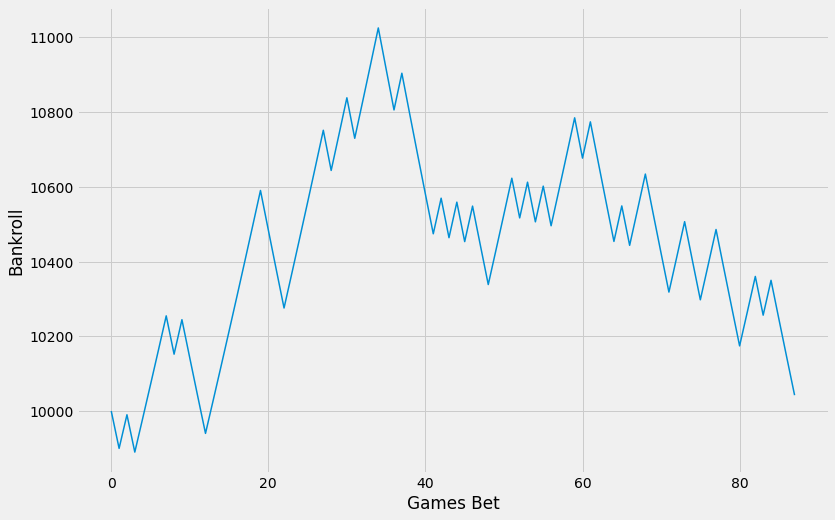

min balance: 9890.1 
max balance: 11025.134442213528 
final balance: 10133.670502227182 
win percentage 53.410000000000004


index  GAME_DATE  spread  point_diff_team      preds  home_cover  \
0   18149 2015-11-13   -10.5               19   0.467651         1.0   
1   18305 2015-12-05     2.5               15  12.106814         1.0   
2   18412 2015-12-19    -2.5               16  -8.596247         1.0   
3   18914 2016-03-02     1.5                5   8.871097         1.0   
4   18958 2016-03-08    -1.0               16  11.850453         1.0   
5   18975 2016-03-11     3.0                7   7.452716         1.0   
6   18987 2016-03-12   -14.0               12   1.606647         0.0   
7   19018 2016-03-16     3.5               -6   6.557537         0.0   
8   19038 2016-03-18    15.5              -14  -3.909948         1.0   
9   19097 2016-03-26    11.5              -24   1.007764         0.0   
10  19098 2016-03-26     8.0               -9   3.003536         0.0   
11  19102 2016-03-26   -12.5               19   0.373051         1.0   
12  19106 2016-03-27   -22.0               12  11.783009         0.0   
13  19110 2016-03-28     5.5                8   6.897187         1.0   
14  19133 2016-03-30   -19.0                8   5.261089         0.0   
15  19137 2016-03-31     7.0                6   4.261722         1.0   
16  19138 2016-03-31   -17.0                2   2.948947         0.0   
17  19199 2016-04-08   -13.5               -3   2.100039         0.0   
18  19213 2016-04-10     5.5               15   5.967437         1.0   
19  19250 2016-04-17   -17.5               32   4.302588         1.0   
20  19254 2016-04-19   -17.5               26   5.779492         1.0   
21  19259 2016-04-21     9.5              -29   2.393999         0.0   
22  19528 2016-12-01     4.0                1   6.009226         1.0   
23  19583 2016-12-08    11.5               -7  -1.068132         1.0   
24  19712 2016-12-26     4.5               -4   7.664991         1.0   
25  19713 2016-12-26     8.0               -4   2.555633         1.0   
26  19748 2016-12-30   -18.5                9   1.111392         0.0   
27  19760 2017-01-01     6.5               -9   4.197295         0.0   
28  19835 2017-01-12    -2.5               -9 -10.365545         0.0   
29  20121 2017-02-25   -21.5               17   6.070810         0.0   
30  20280 2017-03-18   -13.5               30   0.379904         1.0   
31  20431 2017-04-07    -5.0              -13  -6.971290         0.0   
32  20453 2017-04-10    10.5                1   2.103284         1.0   
33  20461 2017-04-11    -8.0               -2  -3.553380         0.0   
34  20553 2017-05-25    10.0              -33   3.079795         0.0   
35  20586 2017-11-01    -7.5               10  -3.067763         1.0   
36  20665 2017-11-11    10.0                8   1.615845         1.0   
37  20678 2017-11-13     3.0              -11   7.525069         0.0   
38  20815 2017-12-03    10.5              -28  -0.492563         0.0   
39  20816 2017-12-03     2.5               -5   8.347933         0.0   
40  20823 2017-12-04     9.0              -10   2.117797         0.0   
41  20829 2017-12-05    -8.0                6  -2.908175         0.0   
42  20965 2017-12-23     3.0              -15   8.311669         0.0   
43  21175 2018-01-23     5.0                1   6.191872         1.0   
44  21390 2018-02-28     8.5              -13   2.598853         0.0   
45  21495 2018-03-14     4.0               -1   7.754441         1.0   
46  21574 2018-03-25     9.0              -19   1.498806         0.0   
47  21592 2018-03-27     8.0              -11   7.284669         0.0   
48  21608 2018-03-30   -17.5                1   7.341352         0.0   
49  21698 2018-04-11     4.5               13   6.818979         1.0   
50  21759 2018-05-02   -10.5               -8  -2.955511         0.0   
51  21784 2018-05-26   -12.5               29   0.541650         1.0   
52  21910 2018-11-13     9.0               24   1.078566         1.0   
53  22232 2018-12-28     7.0              -11   7.129992         0.0   
54  22427 2019-01-24   -14.0                

In [226]:
search_spaces = {'min_child_weight':Integer(1,8),
              'gamma': Real(0.5, 3),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 30),
              'reg_lambda': Integer(1, 10),
              'reg_alpha': Integer(0, 10)}
    
    
xgb_bs = BayesSearchCV(xgb.XGBRegressor(), search_spaces=search_spaces, cv=tscv, verbose=1, n_jobs=-1)

xgb_bs.fit(X_train, point_diff_train)

print(xgb_bs.best_estimator_)

best_xgb = xgb_bs.best_estimator_
xgb_preds = best_xgb.predict(X_test)


select_bets_xgb, best_thresholds_xgb = find_optimal_threshold(xgb_preds, test_indices)
simulate_bets(select_bets_xgb)

#### Predicting Spread + Actual Point Diff as Proxy for Confidence of Covering

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.5s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=10, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)
best thresholds: 3
num_games_bet: 895
win percetange at threshold: 0.5407821229050279


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


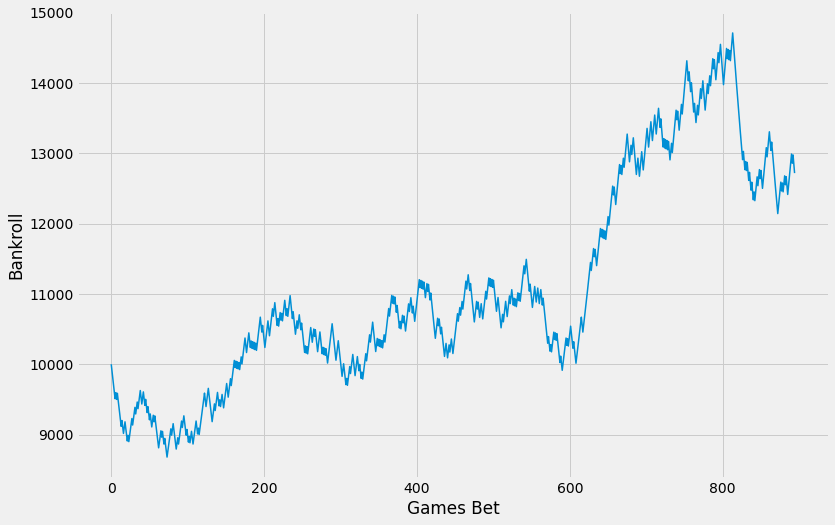

min balance: 8679.951041398208 
max balance: 14710.165999990046 
final balance: 12832.96754003134 
win percentage 54.08


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11774 2016-11-04    11.5               20         -5.631546         1.0   
1    11776 2016-11-04     3.5              -14          3.162053         0.0   
2    11778 2016-11-05    -3.5               26         -4.100602         1.0   
3    11779 2016-11-05    -3.0               15         -4.821010         1.0   
4    11781 2016-11-06    -4.0               11         -5.283764         1.0   
..     ...        ...     ...              ...               ...         ...   
890  16451 2020-08-31     4.5                4         -4.341241         1.0   
891  16452 2020-08-31    -5.0              -11         -4.672438         0.0   
892  16466 2020-09-07     1.5              -22          3.374611         0.0   
893  16468 2020-09-08     4.5              -10          3.534227         0.0   
894  16474 2020-09-12    -6.5               23          5.971379         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           1        0   9900.000000   9801.000000   99.000000  
2           0        0   9801.000000   9702.990000   98.010000  
3           0        0   9702.990000   9605.960100   97.029900  
4           0        0   9605.960100   9509.900499   96.059601  
..        ...      ...           ...           ...         ...  
890         0        0  12988.557601  12858.672025  129.885576  
891         0        1  12858.672025  12975.569044  128.586720  
892         1        0  12975.569044  12845.813353  129.755690  
893         1        0  12845.813353  12717.355220  128.458134  
894         1        1  12717.355220  12832.967540  127.173552  

[895 rows x 11 columns]

In [474]:
search_spaces = {'min_child_weight':Integer(1,8),
              'gamma': Real(0.5, 3),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 30),
              'reg_lambda': Integer(1, 10),
              'reg_alpha': Integer(0, 10)}
    
    
xgb_bs = BayesSearchCV(xgb.XGBRegressor(), search_spaces=search_spaces, cv=tscv, verbose=1, n_jobs=-1)

xgb_bs.fit(X_train_spread, spread_point_diff_train)

print(xgb_bs.best_estimator_)

best_xgb = xgb_bs.best_estimator_
xgb_preds = best_xgb.predict(X_test_spread)


select_bets_xgb, best_thresholds_xgb = find_optimal_confidence_thresholds(xgb_preds, test_indices)
simulate_bets(select_bets_xgb)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 3.0
num_games_bet: 895
win percetange at threshold: 0.5407821229050279


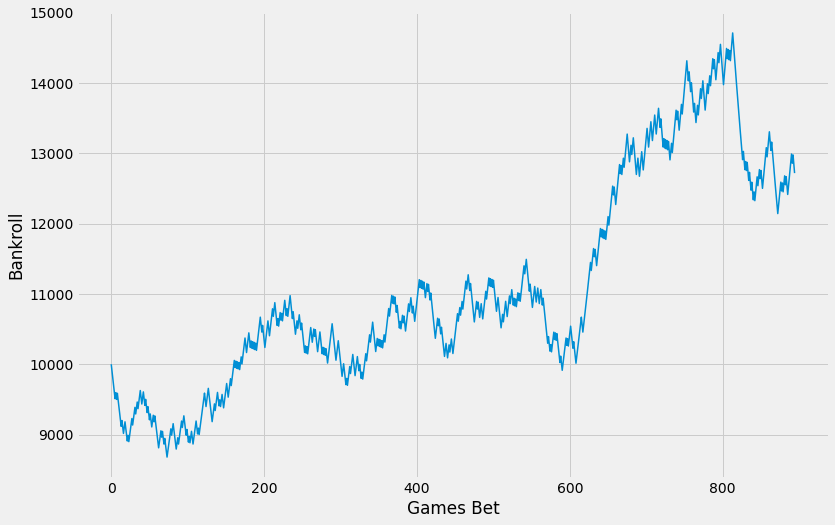

min balance: 8679.951041398208 
max balance: 14710.165999990046 
final balance: 12832.96754003134 
win percentage 54.08


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11774 2016-11-04    11.5               20         -5.631546         1.0   
1    11776 2016-11-04     3.5              -14          3.162053         0.0   
2    11778 2016-11-05    -3.5               26         -4.100602         1.0   
3    11779 2016-11-05    -3.0               15         -4.821010         1.0   
4    11781 2016-11-06    -4.0               11         -5.283764         1.0   
..     ...        ...     ...              ...               ...         ...   
890  16451 2020-08-31     4.5                4         -4.341241         1.0   
891  16452 2020-08-31    -5.0              -11         -4.672438         0.0   
892  16466 2020-09-07     1.5              -22          3.374611         0.0   
893  16468 2020-09-08     4.5              -10          3.534227         0.0   
894  16474 2020-09-12    -6.5               23          5.971379         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           1        0   9900.000000   9801.000000   99.000000  
2           0        0   9801.000000   9702.990000   98.010000  
3           0        0   9702.990000   9605.960100   97.029900  
4           0        0   9605.960100   9509.900499   96.059601  
..        ...      ...           ...           ...         ...  
890         0        0  12988.557601  12858.672025  129.885576  
891         0        1  12858.672025  12975.569044  128.586720  
892         1        0  12975.569044  12845.813353  129.755690  
893         1        0  12845.813353  12717.355220  128.458134  
894         1        1  12717.355220  12832.967540  127.173552  

[895 rows x 11 columns]

In [526]:
select_bets_xgb, best_thresholds_xgb = find_optimal_confidence_thresholds(xgb_preds, test_indices)
simulate_bets(select_bets_xgb)

#### XGB EWM

In [62]:
tscv = TimeSeriesSplit()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=3.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=20, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)
best thresholds: 7.1
num_games_bet: 26
win percetange at threshold: 0.5384615384615384


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


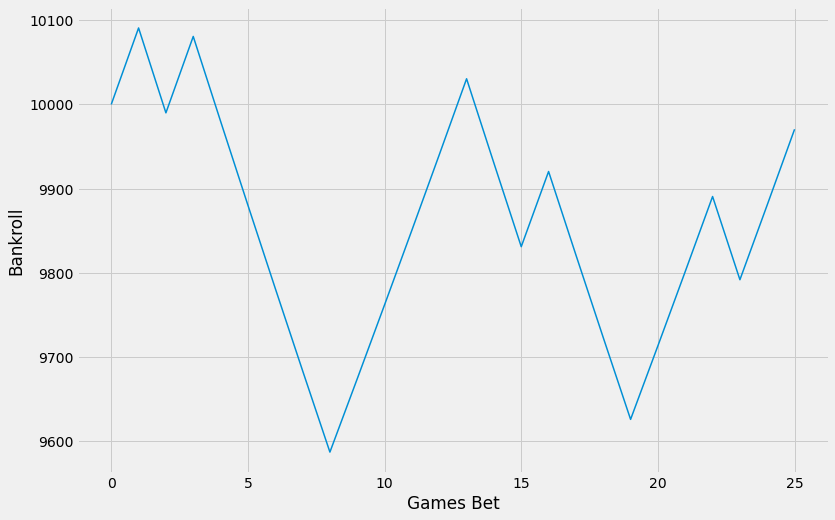

min balance: 9586.757785760099 
max balance: 10090.90909090909 
final balance: 10061.122711957973 
win percentage 53.849999999999994


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0   11984 2016-12-03     3.5               25          7.525306         1.0   
1   11997 2016-12-05     3.5               -8          7.461194         0.0   
2   12565 2017-02-26    -2.0              -10         -8.350107         0.0   
3   12974 2017-05-06     6.5              -11         12.318402         0.0   
4   12978 2017-05-08     9.0              -26         11.491919         0.0   
5   12988 2017-05-20     9.5              -12          9.040609         0.0   
6   12990 2017-05-22    11.0              -14          8.048524         0.0   
7   12995 2017-06-07     3.0               -5          9.843543         0.0   
8   12996 2017-06-09     5.0               21          8.508821         1.0   
9   13178 2017-11-22     5.5               17          9.605476         1.0   
10  13300 2017-12-09     8.5               -7          7.117244         1.0   
11  13452 2017-12-30   -14.5               13         -8.985557         0.0   
12  13590 2018-01-20    -9.5                7         -7.777387         0.0   
13  13685 2018-02-02    -7.0                9         -8.341413         1.0   
14  14274 2018-11-03     8.5               -8         -7.674702         1.0   
15  14469 2018-11-30     4.0              -31         -7.991335         0.0   
16  15206 2019-03-19     7.5              -16          8.420250         0.0   
17  15211 2019-03-19     6.5              -10          9.127798         0.0   
18  15416 2019-04-25    -3.0               17         -7.341652         1.0   
19  15504 2019-11-08    -4.0               -4         -8.822841         0.0   
20  15521 2019-11-10     3.5               -2          8.695292         1.0   
21  15849 2019-12-30    -4.0               -6         -7.239242         0.0   
22  16053 2020-01-28   -11.5               20        -10.329385         1.0   
23  16183 2020-02-21     5.5              -13         -7.615965         0.0   
24  16222 2020-02-26     2.5              -10         -7.240199         0.0   
25  16255 2020-03-02    10.0                2          9.041419         1.0   

    bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0          1        1  10000.000000  10090.909091  100.000000  
1          1        0  10090.909091   9990.000000  100.909091  
2          0        1   9990.000000  10080.818182   99.900000  
3          1        0  10080.818182   9980.010000  100.808182  
4          1        0   9980.010000   9880.209900   99.800100  
5          1        0   9880.209900   9781.407801   98.802099  
6          1        0   9781.407801   9683.593723   97.814078  
7          1        0   9683.593723   9586.757786   96.835937  
8          1        1   9586.757786   9673.910129   95.867578  
9          1        1   9673.910129   9761.854767   96.739101  
10         1        1   9761.854767   9850.598901   97.618548  
11         0        1   9850.598901   9940.149800   98.505989  
12         0        1   9940.149800  10030.514798   99.401498  
13         0        0  10030.514798   9930.209650  100.305148  
14         0        0   9930.209650   9830.907554   99.302097  
15         0        1   9830.907554   9920.279441   98.309076  
16         1        0   9920.279441   9821.076646   99.202794  
17         1        0   9821.076646   9722.865880   98.210766  
18         0        0   9722.865880   9625.637221   97.228659  
19         0        1   9625.637221   9713.143014   96.256372  
20         1        1   9713.143014   9801.444314   97.131430  
21         0        1   9801.444314   9890.548353   98.014443  
22         0        0   9890.548353   9791.642870   98.905484  
23         0        1   9791.642870   9880.657805   97.916429  
24         0        1   9880.657805   9970.481967   98.806578  
25         1        1   9970.481967  10061.122712   99.704820

In [63]:
search_spaces = {'min_child_weight':Integer(1,8),
              'gamma': Real(0.5, 3),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 5),
              'reg_lambda': Integer(8, 20),
              'reg_alpha': Integer(0, 10)}
    
    
xgb_bs = BayesSearchCV(xgb.XGBRegressor(), search_spaces=search_spaces, cv=tscv, verbose=1, n_jobs=-1)

xgb_bs.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

print(xgb_bs.best_estimator_)

best_xgb = xgb_bs.best_estimator_
xgb_preds = best_xgb.predict(X_test_ewm_19)


select_bets_xgb, best_thresholds_xgb = find_optimal_confidence_thresholds(xgb_preds, test_indices)
simulate_bets(select_bets_xgb)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 1.8
num_games_bet: 1955
win percetange at threshold: 0.5370843989769821


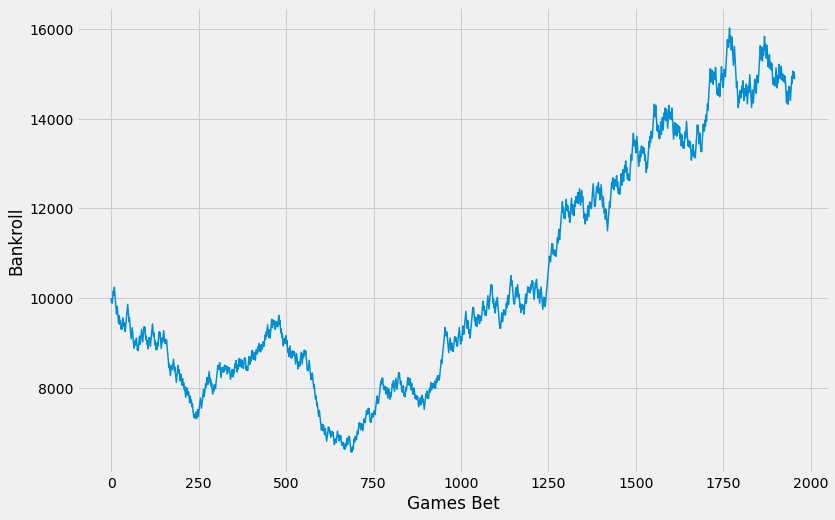

min balance: 6566.7057100275515 
max balance: 16026.682117344499 
final balance: 15019.636447598754 
win percentage 53.71


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0     11774 2016-11-04    11.5               20         -4.697775         1.0   
1     11781 2016-11-06    -7.5               -5         -3.064961         0.0   
2     11782 2016-11-06    -4.0               11         -2.468719         1.0   
3     11789 2016-11-08     4.0                9          4.070855         1.0   
4     11791 2016-11-08    -8.5                3         -3.502885         0.0   
...     ...        ...     ...              ...               ...         ...   
1950  16477 2020-09-15    -2.0               -3         -5.180860         0.0   
1951  16480 2020-09-19     3.5              -11          2.686885         0.0   
1952  16483 2020-09-23     3.5                3          2.352502         1.0   
1953  16485 2020-09-25    -3.5               13         -5.120756         1.0   
1954  16486 2020-09-26    -5.5               10          1.946269         1.0   

      bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0            0        0  10000.000000   9900.000000  100.000000  
1            0        1   9900.000000   9990.000000   99.000000  
2            0        0   9990.000000   9890.100000   99.900000  
3            1        1   9890.100000   9980.010000   98.901000  
4            0        1   9980.010000  10070.737364   99.800100  
...        ...      ...           ...           ...         ...  
1950         0        1  14914.137769  15049.720840  149.141378  
1951         1        0  15049.720840  14899.223631  150.497208  
1952         1        1  14899.223631  15034.671119  148.992236  
1953         0        0  15034.671119  14884.324408  150.346711  
1954         1        1  14884.324408  15019.636448  148.843244  

[1955 rows x 11 columns]

In [60]:
xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, 
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

xgbr.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)


xgb_preds = xgbr.predict(X_test_ewm_19)


select_bets_xgb, best_thresholds_xgb = find_optimal_confidence_thresholds(xgb_preds, test_indices)
simulate_bets(select_bets_xgb)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.4
num_games_bet: 1360
win percetange at threshold: 0.5323529411764706


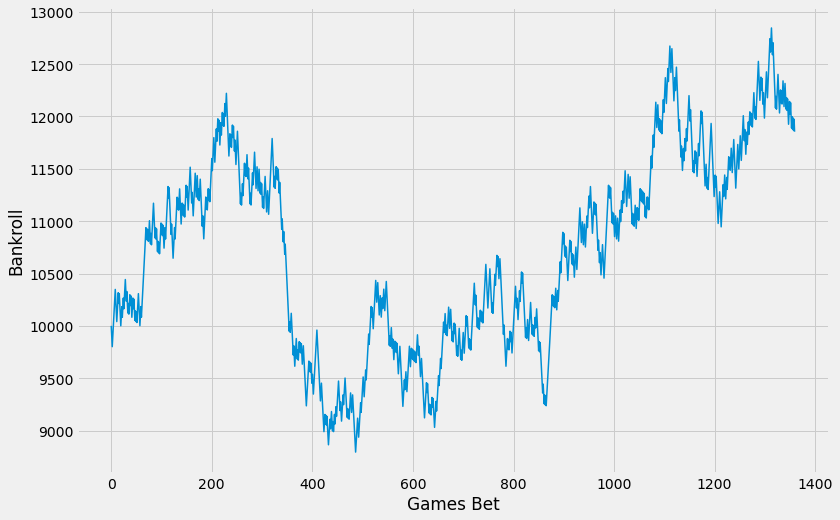

min balance: 8793.954881752543 
max balance: 12845.772440241844 
final balance: 11735.898668844451 
win percentage 53.239999999999995


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0     11774 2016-11-04    11.5               20         -4.696824         1.0   
1     11781 2016-11-06    -4.0               11         -2.468104         1.0   
2     11782 2016-11-06    -7.5               -5         -3.065332         0.0   
3     11789 2016-11-08     4.0                9          4.069438         1.0   
4     11791 2016-11-08    -8.5                3         -3.502422         0.0   
...     ...        ...     ...              ...               ...         ...   
1355  16474 2020-09-12    -6.5               23          3.603366         1.0   
1356  16476 2020-09-15    -7.5              -15          2.963645         0.0   
1357  16477 2020-09-15    -2.0               -3         -5.181109         0.0   
1358  16480 2020-09-19     3.5              -11          2.684426         0.0   
1359  16485 2020-09-25    -3.5               13         -5.120707         1.0   

      bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0            0        0  10000.000000   9900.000000  100.000000  
1            0        0   9900.000000   9801.000000   99.000000  
2            0        1   9801.000000   9890.100000   98.010000  
3            1        1   9890.100000   9980.010000   98.901000  
4            0        1   9980.010000  10070.737364   99.800100  
...        ...      ...           ...           ...         ...  
1355         1        1  11878.187597  11986.171120  118.781876  
1356         1        0  11986.171120  11866.309409  119.861711  
1357         0        1  11866.309409  11974.184949  118.663094  
1358         1        0  11974.184949  11854.443100  119.741849  
1359         0        0  11854.443100  11735.898669  118.544431  

[1360 rows x 11 columns]

### Random Forest

In [228]:
from sklearn.ensemble import RandomForestRegressor

search_spaces = {'max_depth': Integer(3, 30, prior='log-uniform'),
                'max_features': Real(0.1, 1),
                 'min_samples_split': Real(0.1, 1),
                 'min_samples_leaf': Real(0.1, 0.5)}

rf_bs = BayesSearchCV(RandomForestRegressor(), search_spaces=search_spaces, n_jobs=-1, cv=tscv, verbose=3)
rf_bs.fit(X_train, point_diff_train)
                 





Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.9s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.7s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.9s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.5s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.4s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.5s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


RandomForestRegressor(max_depth=3, max_features=0.4520024776359294,
                      min_samples_leaf=0.1,
                      min_samples_split=0.17095523728123663)


NameError: name 'bets_rf' is not defined

In [ ]:
best_rf = rf_bs.best_estimator_
print(best_rf)
rf_preds = best_rf.predict(X_test)

select_bets_rf, best_thresholds_rf = find_optimal_threshold(rf_preds, test_indices)
simulate_bets(select_bets_rf)

In [658]:
print(gs_rf.best_params_)
best_rf = gs_rf.best_estimator_
y_preds = best_rf.predict(X_test)
mae = mean_absolute_error(total_test, y_preds)
mse = mean_squared_error(total_test, y_preds)
print('mae:', mae)

{'max_depth': 10, 'max_features': 0.2888888888888889}
mae: 15.519578952157952


In [659]:
y_preds

array([205.74019359, 217.54525072, 210.78817095, ..., 219.36898161,
       219.39432272, 220.69016304])

In [671]:
rf_total_bet_results.head(20)

total  AWAY_TEAM_SCORE  HOME_TEAM_SCORE  actual_total  model_preds  \
19276  205.0               95              100           195   205.740194   
19277  220.0               93              116           209   217.545251   
19278  210.0              104              105           209   210.788171   
19279  210.5               96              116           212   214.291256   
19280  224.5              102               98           200   221.852722   
19281  220.0              130              109           239   218.110430   
19282  217.0               96              107           203   210.880776   
19283  205.5               79               91           170   213.033712   
19284  207.5               97              104           201   205.120585   
19285  204.0              109              124           233   204.114778   
19286  210.0              114              100           214   208.425233   
19287  206.0               88               98           186   211.123264   
19288    NaN              103              111           214   207.731634   
19289    NaN               95              104           199   206.572510   
19290    NaN              104               92           196   203.761058   
19291  210.5              105              120           225   207.139300   
19292  206.0              115               98           213   207.999772   
19293  201.0               90              104           194   202.618353   
19294  210.5              116              122           238   207.946276   
19295  201.5              113              104           217   204.006853   

       bet_over  over_correct  bet_won    bankroll_i    bankroll_n    bet_size  
19276         1           0.0      0.0  10000.000000   9900.000000  100.000000  
19277         0           0.0      1.0   9900.000000   9990.000000   99.000000  
19278         1           0.0      0.0   9990.000000   9890.100000   99.900000  
19279         1           1.0      1.0   9890.100000   9980.010000   98.901000  
19280         0           0.0      1.0   9980.010000  10070.737364   99.800100  
19281         0           1.0      0.0  10070.737364   9970.029990  100.707374  
19282         0           0.0      1.0   9970.029990  10060.666626   99.700300  
19283         1           0.0      0.0  10060.666626   9960.059960  100.606666  
19284         0           0.0      1.0   9960.059960  10050.605960   99.600600  
19285         1           1.0      1.0  10050.605960  10141.975105  100.506060  
19286         0           1.0      0.0  10141.975105  10040.555354  101.419751  
19287         1           0.0      0.0  10040.555354   9940.149800  100.405554  
19288         0           0.0      1.0   9940.149800  10030.514798   99.401498  
19289         0           0.0      1.0  10030.514798  10121.701296  100.305148  
19290         0           0.0      1.0  10121.701296  10213.716763  101.217013  
19291         0           1.0      0.0  10213.716763  10111.579595  102.137168  
19292         1           1.0      1.0  10111.579595  10203.503046  101.115796  
19293         1           0.0      0.0  10203.503046  10101.468016  102.035030  
19294         0           1.0      0.0  10101.468016  10000.453335  101.014680  
19295         1           1.0      1.0  10000.453335  10091.366548  100.004533

#### Predicting Spread + Actual Point Diff as Proxy for Confidence of Covering

In [479]:
search_spaces = {'max_depth': Integer(3, 30, prior='log-uniform'),
                'max_features': Real(0.1, 1),
                 'min_samples_split': Real(0.1, 1),
                 'min_samples_leaf': Real(0.1, 0.5)}

rf_bs = BayesSearchCV(RandomForestRegressor(), search_spaces=search_spaces, n_jobs=-1, cv=tscv, verbose=3)
rf_bs.fit(X_train_spread, spread_point_diff_train)
                 


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


BayesSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
              estimator=RandomForestRegressor(), n_jobs=-1,
              search_spaces={'max_depth': Integer(low=3, high=30, prior='log-uniform', transform='identity'),
                             'max_features': Real(low=0.1, high=1, prior='uniform', transform='identity'),
                             'min_samples_leaf': Real(low=0.1, high=0.5, prior='uniform', transform='identity'),
                             'min_samples_split': Real(low=0.1, high=1, prior='uniform', transform='identity')},
              verbose=3)

RandomForestRegressor(max_depth=8, max_features=1.0, min_samples_leaf=0.1,
                      min_samples_split=0.1)
best thresholds: 1.4
num_games_bet: 177
win percetange at threshold: 0.576271186440678


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


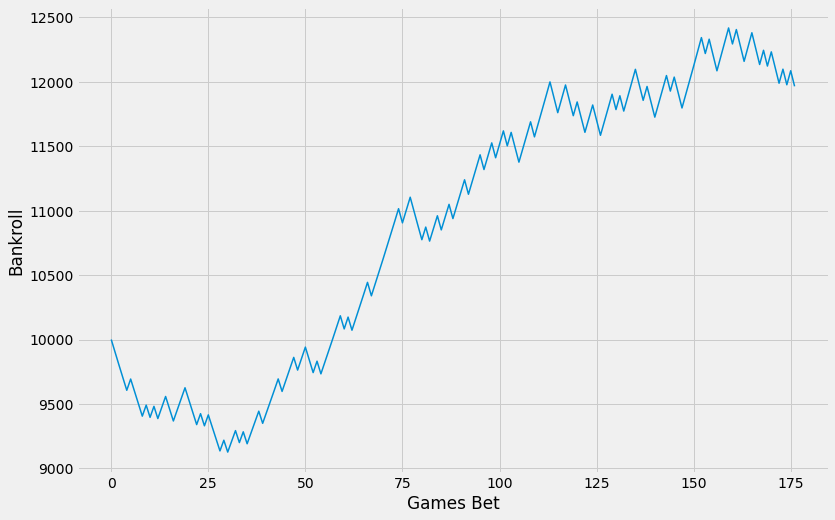

min balance: 9126.45101798612 
max balance: 12417.390785622189 
final balance: 11844.849443927265 
win percentage 57.63


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11778 2016-11-05    -3.5               26         -1.538982         1.0   
1    11779 2016-11-05    -3.0               15         -1.405176         1.0   
2    11786 2016-11-07    -7.0               32         -1.537470         1.0   
3    11788 2016-11-07    -5.5               12         -1.421934         1.0   
4    11792 2016-11-08    -4.0              -12         -1.623760         0.0   
..     ...        ...     ...              ...               ...         ...   
172  16367 2020-08-07    -9.0                8         -1.544226         0.0   
173  16375 2020-08-08    -1.5                2         -1.442953         1.0   
174  16377 2020-08-08    -4.5               -5         -1.549685         0.0   
175  16411 2020-08-17    -4.5               10         -1.416901         1.0   
176  16464 2020-09-06    -6.0                8         -1.419234         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           0        0   9900.000000   9801.000000   99.000000  
2           0        0   9801.000000   9702.990000   98.010000  
3           0        0   9702.990000   9605.960100   97.029900  
4           0        1   9605.960100   9693.287010   96.059601  
..        ...      ...           ...           ...         ...  
172         0        1  11988.459318  12097.445312  119.884593  
173         0        0  12097.445312  11976.470859  120.974453  
174         0        1  11976.470859  12085.347866  119.764709  
175         0        0  12085.347866  11964.494388  120.853479  
176         0        0  11964.494388  11844.849444  119.644944  

[177 rows x 11 columns]

In [527]:
best_rf = rf_bs.best_estimator_
print(best_rf)
rf_preds = best_rf.predict(X_test_spread)

select_bets_rf, best_thresholds_rf = find_optimal_confidence_thresholds(rf_preds, test_indices)
simulate_bets(select_bets_rf)

In [638]:
abs(rf_preds).mean()
abs(spread_point_diff_train).mean()

9.167020553762528

#### RF EWM

In [639]:
search_spaces = {'max_depth': Integer(3, 30, prior='log-uniform'),
                'max_features': Real(0.1, 1),
                 'min_samples_split': Real(0.1, 1),
                 'min_samples_leaf': Real(0.1, 0.5)}

rf_bs = BayesSearchCV(RandomForestRegressor(), search_spaces=search_spaces, n_jobs=-1, cv=tscv, verbose=3)
rf_bs.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
                 
best_rf = rf_bs.best_estimator_
print(best_rf)
rf_preds = best_rf.predict(X_test_ewm_19)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.2s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.4s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.3s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


RandomForestRegressor(max_depth=27, max_features=0.7932417217142294,
                      min_samples_leaf=0.1, min_samples_split=0.1)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 1.3
num_games_bet: 173
win percetange at threshold: 0.5606936416184971


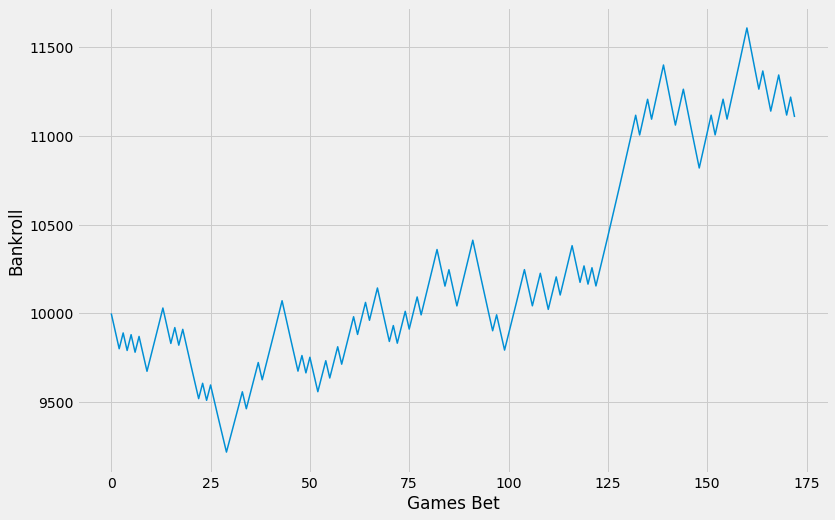

min balance: 9218.637391905168 
max balance: 11608.610680516103 
final balance: 11207.616743672046 
win percentage 56.07


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11785 2016-11-07    -5.5               12         -1.388267         1.0   
1    11788 2016-11-07    -7.0               32         -1.349965         1.0   
2    11792 2016-11-08    -4.0              -12         -1.522270         0.0   
3    11804 2016-11-09   -18.5               21         -1.389840         1.0   
4    11834 2016-11-14   -11.0                4         -1.423576         0.0   
..     ...        ...     ...              ...               ...         ...   
168  16203 2020-02-24   -14.0               16         -1.471930         1.0   
169  16273 2020-03-04    -8.0               21         -1.479491         1.0   
170  16297 2020-03-07    -2.5              -12         -1.398950         0.0   
171  16318 2020-03-10    -6.5               16         -1.382179         1.0   
172  16371 2020-08-07    -9.0                8         -1.309675         0.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           0        0   9900.000000   9801.000000   99.000000  
2           0        1   9801.000000   9890.100000   98.010000  
3           0        0   9890.100000   9791.199000   98.901000  
4           0        1   9791.199000   9880.209900   97.911990  
..        ...      ...           ...           ...         ...  
168         0        0  11343.500651  11230.065645  113.435007  
169         0        0  11230.065645  11117.764988  112.300656  
170         0        1  11117.764988  11218.835579  111.177650  
171         0        0  11218.835579  11106.647223  112.188356  
172         0        1  11106.647223  11207.616744  111.066472  

[173 rows x 11 columns]

In [64]:
rf = RandomForestRegressor(max_depth=27, max_features=0.7932417217142294,
                      min_samples_leaf=0.1, min_samples_split=0.1)


rf.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

rf_preds = rf.predict(X_test_ewm_19)

select_bets_rf, best_thresholds_rf = find_optimal_confidence_thresholds(rf_preds, test_indices)
simulate_bets(select_bets_rf)

### Stacked Regressor for Spread + Actual Point Diff

In [531]:
lasso_pipe = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(max_iter=20000))])

lr_pipe = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

sgd_pipe = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(epsilon=0.257191, l1_ratio=1.0, loss='huber',
                              penalty='elasticnet'))])


xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, n_estimators=100, n_jobs=0, num_parallel_tree=1,
                    random_state=0, reg_alpha=10, reg_lambda=10)

linear_svr = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr', LinearSVR(C=0.000307628104,
                loss='squared_epsilon_insensitive',
                max_iter=10000))])


rf = RandomForestRegressor(max_depth=8, max_features=1.0, min_samples_leaf=0.1,
                      min_samples_split=0.1)


lgbr = lgb.LGBMRegressor(feature_fraction=0.01, max_depth=3, min_child_weight=8,
              num_leaf=2048, objective='regression', reg_alpha=10,
              reg_lambda=10, subsample=0.6, subsample_freq=1)

estimators = [('lasso', lasso_pipe), ('lr', lr_pipe),
              ('sgd', sgd_pipe), ('xgbr', xgbr),
              ('svr', linear_svr), ('rf', rf),
              ('lgbr', lgbr)]

stacked_reg = StackingRegressor(estimators = estimators, final_estimator = LinearRegression())

stacked_reg.fit(X_train_spread, spread_point_diff_train)

stacked_preds = stacked_reg.predict(X_test_spread)




[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01
[LightGBM] [Warning] num_leaves is set=31, num_leaf=2048 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01
[LightGBM] [Warning] num_leaves is set=31, num_leaf=2048 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01
[LightGBM] [Warning] num_leaves is set=31, num_leaf=2048 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01
[LightGBM] [Warning] num_leaves is set=31, num_leaf=2048 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be igno

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.1
num_games_bet: 265
win percetange at threshold: 0.569811320754717


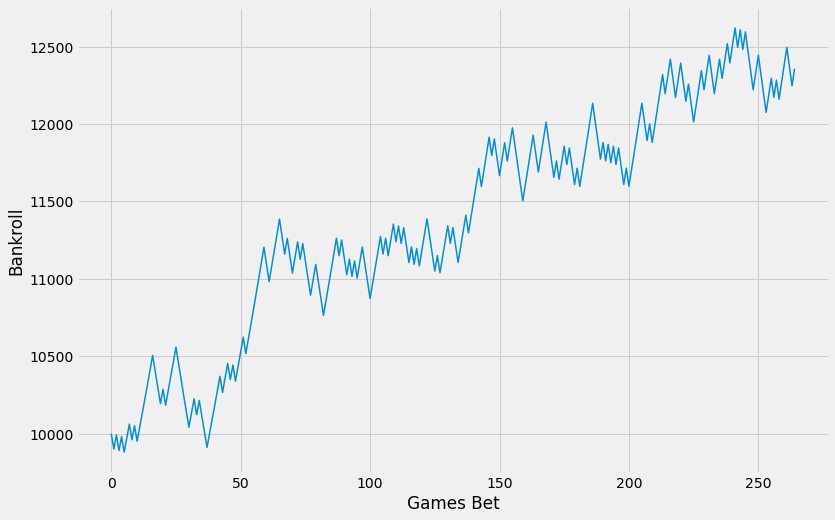

min balance: 9880.2099 
max balance: 12621.200422175167 
final balance: 12470.576245910346 
win percentage 56.98


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0    11781 2016-11-06    -4.0               11         -2.101167         1.0   
1    11785 2016-11-07   -16.5               10         -2.280885         0.0   
2    11788 2016-11-07    -5.5               12         -2.423314         1.0   
3    11792 2016-11-08    -4.0              -12         -2.984580         0.0   
4    11797 2016-11-09   -18.5               21         -2.543383         1.0   
..     ...        ...     ...              ...               ...         ...   
260  16424 2020-08-20     4.0               -9         -2.158518         0.0   
261  16427 2020-08-21    11.0              -25          2.961695         0.0   
262  16437 2020-08-23    14.0              -28          3.185883         0.0   
263  16465 2020-09-07     9.0               -6          2.345374         1.0   
264  16483 2020-09-23     3.5                3          2.117217         1.0   

     bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0           0        0  10000.000000   9900.000000  100.000000  
1           0        1   9900.000000   9990.000000   99.000000  
2           0        0   9990.000000   9890.100000   99.900000  
3           0        1   9890.100000   9980.010000   98.901000  
4           0        0   9980.010000   9880.209900   99.800100  
..        ...      ...           ...           ...         ...  
260         0        1  12382.982294  12495.554860  123.829823  
261         1        0  12495.554860  12370.599311  124.955549  
262         1        0  12370.599311  12246.893318  123.705993  
263         1        1  12246.893318  12358.228712  122.468933  
264         1        1  12358.228712  12470.576246  123.582287  

[265 rows x 11 columns]

In [532]:
select_bets_stacked, best_thresholds_stacked = find_optimal_confidence_thresholds(stacked_preds, test_indices)
simulate_bets(select_bets_stacked)

In [544]:
betting_df = final_df_spread[['GAME_DATE', 'HOME_GAME', 'home_spread_mode', 'point_diff_team']].iloc[cutoff_16:]
betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
betting_df['confidence_preds'] = stacked_preds
betting_df['home_cover'] = (betting_df['point_diff_team'] + betting_df['spread'] > 0).astype(int)
betting_df['bet_home'] = (betting_df['confidence_preds'] > 0).astype(int)

betting_df.loc[betting_df['spread'] + betting_df['point_diff_team'] == 0, 'home_cover'] = 0.5
betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['home_cover']).astype(int)

betting_df.loc[((betting_df['bet_home'] == 0) & (betting_df['spread'] > 0)), 'bet_won']

11810    1
11816    0
11875    0
11888    1
11891    0
        ..
16424    1
16431    0
16441    0
16451    0
16482    0
Name: bet_won, Length: 434, dtype: int32

#### Stacked EWM 

In [700]:
lasso_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.0727895384398315, max_iter=20000))])

en_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.11721022975334805, max_iter=10000))])

ridge_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=100.0, max_iter=10000))])

sgd_pipe = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.0008858667904100823,
                              epsilon=0.19144819761699575, l1_ratio=0.25,
                              loss='huber', penalty='elasticnet'))])

xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

linear_svr = Pipeline(steps=[('scaler', StandardScaler()),
                    ('svr',
                     LinearSVR(C=0.00018877550822240589,
                               loss='squared_epsilon_insensitive',
                               max_iter=10000))])


rf = RandomForestRegressor(max_depth=27, max_features=0.7932417217142294,
                      min_samples_leaf=0.1, min_samples_split=0.1)


lgbr = lgb.LGBMRegressor(feature_fraction=1.0, max_depth=3, min_child_weight=8,
              num_leaves=2, objective='regression', reg_alpha=10, reg_lambda=10,
              subsample=0.6, subsample_freq=1)

estimators = [('lasso', lasso_pipe), ('en', en_pipe),
              ('sgd', sgd_pipe), ('xgbr', xgbr),
              ('svr', linear_svr), ('rf', rf),
              ('lgbr', lgbr), ('ridge', ridge_pipe)]

stacked_reg = StackingRegressor(estimators = estimators, final_estimator = LinearRegression())

stacked_reg.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

stacked_preds = stacked_reg.predict(X_test_ewm_19)




[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 3.5
num_games_bet: 16
win percetange at threshold: 0.625


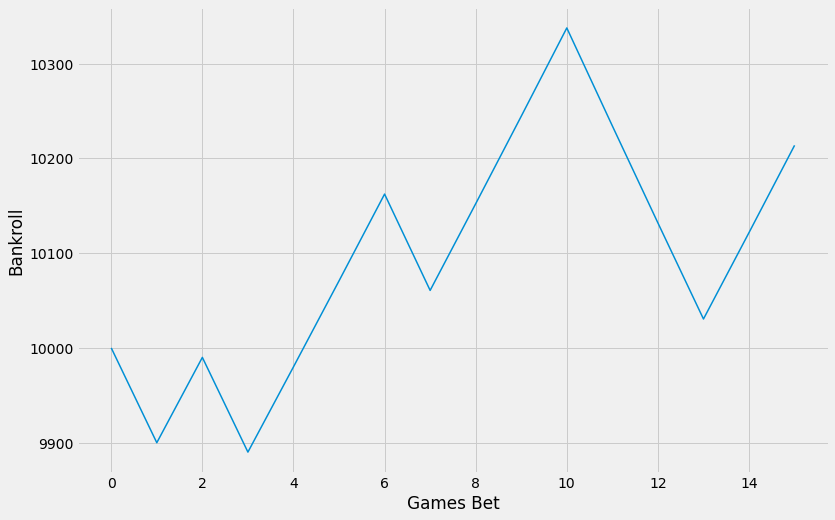

min balance: 9890.1 
max balance: 10337.550382235911 
final balance: 10306.568733402799 
win percentage 62.5


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0   11786 2016-11-07    -7.0               32         -4.136365         1.0   
1   11792 2016-11-08    -4.0              -12         -3.719210         0.0   
2   12248 2017-01-08    -9.5               12         -3.615359         1.0   
3   13014 2017-10-30    -4.0               14          3.835894         1.0   
4   13314 2017-12-12    -5.0               -6         -3.808488         0.0   
5   13859 2018-03-04     3.5              -17         -4.117492         0.0   
6   14227 2018-10-26    11.5              -28          4.051480         0.0   
7   14233 2018-10-28     9.5               -6          3.847959         1.0   
8   14610 2018-12-19     2.0                5          3.590901         1.0   
9   15412 2019-04-23    -4.5                3         -3.666035         0.0   
10  15467 2019-11-03     3.0               29         -4.634694         1.0   
11  15474 2019-11-04     0.0                5         -3.633738         1.0   
12  15502 2019-11-08     2.0                3         -4.098998         1.0   
13  16200 2020-02-23   -14.5               12         -3.620715         0.0   
14  16332 2020-08-01     6.0                6         12.095107         1.0   
15  16336 2020-08-01    -5.0               23         14.213478         1.0   

    bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0          0        0  10000.000000   9900.000000  100.000000  
1          0        1   9900.000000   9990.000000   99.000000  
2          0        0   9990.000000   9890.100000   99.900000  
3          1        1   9890.100000   9980.010000   98.901000  
4          0        1   9980.010000  10070.737364   99.800100  
5          0        1  10070.737364  10162.289521  100.707374  
6          1        0  10162.289521  10060.666626  101.622895  
7          1        1  10060.666626  10152.127232  100.606666  
8          1        1  10152.127232  10244.419298  101.521272  
9          0        1  10244.419298  10337.550382  102.444193  
10         0        0  10337.550382  10234.174878  103.375504  
11         0        0  10234.174878  10131.833130  102.341749  
12         0        0  10131.833130  10030.514798  101.318331  
13         0        1  10030.514798  10121.701296  100.305148  
14         1        1  10121.701296  10213.716763  101.217013  
15         1        1  10213.716763  10306.568733  102.137168

In [701]:
select_bets_stacked, best_thresholds_stacked = find_optimal_confidence_thresholds(stacked_preds, test_indices)
simulate_bets(select_bets_stacked)

#### All Models Voting EWM

In [675]:
lasso_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.0727895384398315, max_iter=20000))])

en_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.11721022975334805, max_iter=10000))])


ridge_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=100.0, max_iter=10000))])

sgd_pipe = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(epsilon=0.257191, l1_ratio=1.0, loss='huber',
                              penalty='elasticnet'))])


xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, n_estimators=100, n_jobs=0, num_parallel_tree=1,
                    random_state=0, reg_alpha=10, reg_lambda=10)

linear_svr = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr', LinearSVR(C=0.000307628104,
                loss='squared_epsilon_insensitive',
                max_iter=10000))])




rf = RandomForestRegressor(max_depth=27, max_features=0.7932417217142294,
                      min_samples_leaf=0.1, min_samples_split=0.1)


lgbr = lgb.LGBMRegressor(colsample_bytree=0.8678435885410023, feature_fraction=0.01,
              max_depth=25, min_child_weight=7, num_leaves=2,
              objective='regression', reg_alpha=20, reg_lambda=13,
              subsample_freq=1)

lasso_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
en_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
ridge_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
sgd_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
xgbr.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
linear_svr.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
rf.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
lgbr.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

lasso_preds = lasso_pipe.predict(X_test_ewm_19)
en_preds = en_pipe.predict(X_test_ewm_19)
ridge_preds = ridge_pipe.predict(X_test_ewm_19)
sgd_preds = sgd_pipe.predict(X_test_ewm_19)
xgbr_preds = xgbr.predict(X_test_ewm_19)
svr_preds = linear_svr.predict(X_test_ewm_19)
rf_preds = rf.predict(X_test_ewm_19)
lgbr_preds = lgbr.predict(X_test_ewm_19)




[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=0.8678435885410023 will be ignored. Current value: feature_fraction=0.01


In [698]:
betting_df = final_df_spread[['GAME_DATE', 'HOME_GAME', 'home_spread_mode', 'point_diff_team']].iloc[cutoff_16:]
betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
betting_df['lasso_preds'] = lasso_preds
betting_df['en_preds'] = en_preds
betting_df['ridge_preds'] = ridge_preds
betting_df['sgd_preds'] = sgd_preds
betting_df['xgbr_preds'] = xgbr_preds
betting_df['svr_preds'] = svr_preds
betting_df['rf_preds'] = rf_preds
betting_df['lgbr_preds'] = lgbr_preds


betting_df['home_cover'] = (betting_df['point_diff_team'] + betting_df['spread'] > 0).astype(int)

betting_df['bet_home_lasso'] = np.select([betting_df['lasso_preds']>1.6, betting_df['lasso_preds'] <-1.6], [1, -1], 0)
betting_df['bet_home_en'] = np.select([betting_df['en_preds']>1.5, betting_df['en_preds'] <-1.5], [1, -1], 0)
betting_df['bet_home_ridge'] = np.select([betting_df['ridge_preds']>2.5, betting_df['ridge_preds'] <-2.5], [1, -1], 0)
betting_df['bet_home_sgd'] = np.select([betting_df['sgd_preds']>1.3, betting_df['sgd_preds'] <-1.3], [1, -1], 0)
betting_df['bet_home_xgbr'] = np.select([betting_df['xgbr_preds']>2.4, betting_df['xgbr_preds'] <-2.4], [1, -1], 0)
betting_df['bet_home_svr'] = np.select([betting_df['svr_preds']>1.9, betting_df['svr_preds'] <-1.9], [1, -1], 0)
betting_df['bet_home_rf'] = np.select([betting_df['rf_preds']>1.3, betting_df['rf_preds'] <-1.3], [1, -1], 0)
betting_df['bet_home_lgbr'] = np.select([betting_df['lgbr_preds']>0.6, betting_df['lgbr_preds'] <-0.6], [1, -1], 0)

betting_df['bet_consensus'] = (betting_df.iloc[:, 15:22] > 0).sum(axis=1)
betting_df['bet_home'] = (betting_df['bet_consensus'] > 0).astype(int)

betting_df.loc[betting_df['spread'] + betting_df['point_diff_team'] == 0, 'home_cover'] = 0.5
betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['home_cover']).astype(int)


select_bets = betting_df.loc[((abs(betting_df['lasso_preds']) > 1.6) 
                            | (abs(betting_df['en_preds']) > 1.5)
                             |(abs(betting_df['ridge_preds']) > 2.5)
                            | (abs(betting_df['sgd_preds']) > 1.3) 
                            | (abs(betting_df['xgbr_preds']) > 2.4) 
                             | (abs(betting_df['svr_preds']) > 1.9) 
                             | (abs(betting_df['rf_preds']) > 1.3) 
                             | (abs(betting_df['lgbr_preds']) > 0.6))]

select_bets = select_bets.loc[select_bets['bet_consensus'] != 0]

# hf = select_bets.loc[((select_bets['bet_home'] == 1) & (select_bets['spread'] < 0)), 'bet_won'].mean()
# hd = select_bets.loc[((select_bets['bet_home'] == 1) & (select_bets['spread'] > 0)), 'bet_won'].mean()
# af = select_bets.loc[((select_bets['bet_home'] == 0) & (select_bets['spread'] > 0)), 'bet_won'].mean()
# ad = select_bets.loc[((select_bets['bet_home'] == 0) & (select_bets['spread'] < 0)), 'bet_won'].mean()

# hf_games = select_bets.loc[((select_bets['bet_home'] == 1) & (select_bets['spread'] < 0)), 'bet_won'].shape[0]
# hd_games = select_bets.loc[((select_bets['bet_home'] == 1) & (select_bets['spread'] > 0)), 'bet_won'].shape[0]
# af_games = select_bets.loc[((select_bets['bet_home'] == 0) & (select_bets['spread'] > 0)), 'bet_won'].shape[0]
# ad_games = select_bets.loc[((select_bets['bet_home'] == 0) & (select_bets['spread'] < 0)), 'bet_won'].shape[0]

# print("HF:", hf, "HD:", hd, 'AF:', af, 'AD:', ad)
# print("HF_games:", hf_games, 'HD_games:', hd_games, 'AF_games:', af_games, 'AD_games:', ad_games)

# print("overall win_pct:", select_bets['bet_won'].mean())

select_bets


GAME_DATE  HOME_GAME  spread  point_diff_team  lasso_preds  en_preds  \
11777 2016-11-05          1    -4.5              -24     0.213260  0.231837   
11779 2016-11-05          1    -3.0               15     0.195331  0.162509   
11789 2016-11-08          1     4.0                9    -0.607457 -0.495325   
11790 2016-11-08          1    -4.0                1     0.084697  0.160411   
11795 2016-11-09          1   -11.5                7     0.323475  0.327824   
...          ...        ...     ...              ...          ...       ...   
16481 2020-09-20          1    -7.5                2     0.714325  0.763663   
16483 2020-09-23          1     3.5                3     1.897914  1.962849   
16486 2020-09-26          1    -5.5               10     1.075247  1.129537   
16487 2020-09-27          1     3.0               12     1.199596  1.228001   
16489 2020-10-02          1   -11.0               10     0.247355  0.277335   

       ridge_preds  sgd_preds  xgbr_preds  svr_preds  rf_preds  lgbr_preds  \
11777     0.834546   1.326378   -1.478675   0.830264 -0.271166    0.168603   
11779     0.667753  -0.329578    2.498864   0.268550 -1.286166   -0.470707   
11789     0.339221  -0.028548    2.597501  -0.017647  0.478733   -0.228526   
11790     0.538093   1.366422    0.565771   0.814663 -0.098503    0.284730   
11795    -0.290948   0.640929    2.914597  -0.017273  0.150087   -0.287823   
...            ...        ...         ...        ...       ...         ...   
16481     0.754744   1.475856    0.197554   1.094332  0.239277    0.049296   
16483     3.287159   2.543345    1.510496   2.880407  0.543966   -0.230455   
16486     1.408192   1.906490   -1.029127   1.561461  0.313621   -0.164972   
16487     2.517299   1.562851    0.782514   2.012982  0.308588   -0.456948   
16489     0.104642   0.923484    3.117330   0.498303 -0.043740    0.120913   

       home_cover  bet_home_lasso  bet_home_en  bet_home_ridge  bet_home_sgd  \
11777         0.0               0            0               0             1   
11779         1.0               0            0               0             0   
11789         1.0               0            0               0             0   
11790         0.0               0            0               0             1   
11795         0.0               0            0               0             0   
...           ...             ...          ...             ...           ...   
16481         0.0               0            0               0             1   
16483         1.0               1            1               1             1   
16486         1.0               0            0               0             1   
16487         1.0               0            0               1             1   
16489         0.0               0            0               0             0   

       bet_home_xgbr  bet_home_svr  bet_home_rf  bet_home_lgbr  bet_consensus  \
11777              0             0            0              0              1   
11779              1             0            0              0              1   
11789              1             0            0              0              1   
11790              0             0            0              0              1   
11795              1             0            0              0              1   
...              ...           ...          ...            ...            ...   
16481              0             0            0              0              1   
16483              0             1            0              0              3   
16486              0             0            0              0              1   
16487              0             1            0              0              3   
16489              1             0            0              0              1   

       bet_home  bet_won  
11777         1        0  
11779         1        1  
11789         1        1  
11790         1        0  
11795         1        0  
...         ...      ... 

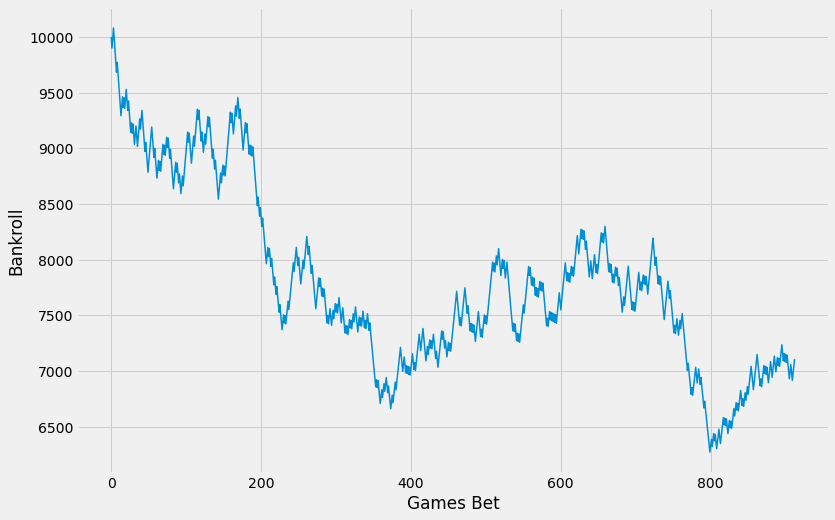

min balance: 6271.61946968746 
max balance: 10080.818181818182 
final balance: 7035.069947246549 
win percentage 50.6


index  GAME_DATE  HOME_GAME  spread  point_diff_team  lasso_preds  \
0    11777 2016-11-05          1    -4.5              -24     0.213260   
1    11779 2016-11-05          1    -3.0               15     0.195331   
2    11789 2016-11-08          1     4.0                9    -0.607457   
3    11790 2016-11-08          1    -4.0                1     0.084697   
4    11795 2016-11-09          1   -11.5                7     0.323475   
..     ...        ...        ...     ...              ...          ...   
908  16481 2020-09-20          1    -7.5                2     0.714325   
909  16483 2020-09-23          1     3.5                3     1.897914   
910  16486 2020-09-26          1    -5.5               10     1.075247   
911  16487 2020-09-27          1     3.0               12     1.199596   
912  16489 2020-10-02          1   -11.0               10     0.247355   

     en_preds  ridge_preds  sgd_preds  xgbr_preds  svr_preds  rf_preds  \
0    0.231837     0.834546   1.326378   -1.478675   0.830264 -0.271166   
1    0.162509     0.667753  -0.329578    2.498864   0.268550 -1.286166   
2   -0.495325     0.339221  -0.028548    2.597501  -0.017647  0.478733   
3    0.160411     0.538093   1.366422    0.565771   0.814663 -0.098503   
4    0.327824    -0.290948   0.640929    2.914597  -0.017273  0.150087   
..        ...          ...        ...         ...        ...       ...   
908  0.763663     0.754744   1.475856    0.197554   1.094332  0.239277   
909  1.962849     3.287159   2.543345    1.510496   2.880407  0.543966   
910  1.129537     1.408192   1.906490   -1.029127   1.561461  0.313621   
911  1.228001     2.517299   1.562851    0.782514   2.012982  0.308588   
912  0.277335     0.104642   0.923484    3.117330   0.498303 -0.043740   

     lgbr_preds  home_cover  bet_home_lasso  bet_home_en  bet_home_ridge  \
0      0.168603         0.0               0            0               0   
1     -0.470707         1.0               0            0               0   
2     -0.228526         1.0               0            0               0   
3      0.284730         0.0               0            0               0   
4     -0.287823         0.0               0            0               0   
..          ...         ...             ...          ...             ...   
908    0.049296         0.0               0            0               0   
909   -0.230455         1.0               1            1               1   
910   -0.164972         1.0               0            0               0   
911   -0.456948         1.0               0            0               1   
912    0.120913         0.0               0            0               0   

     bet_home_sgd  bet_home_xgbr  bet_home_svr  bet_home_rf  bet_home_lgbr  \
0               1              0             0            0              0   
1               0              1             0            0              0   
2               0              1             0            0              0   
3               1              0             0            0              0   
4               0              1             0            0              0   
..            ...            ...           ...          ...            ...   
908             1              0             0            0              0   
909             1              0             1            0              0   
910             1              0             0            0              0   
911             1              0             1            0              0   
912             0              1             0            0              0   

     bet_consensus  bet_home  bet_won    bankroll_i    bet_size    bankroll_n  
0                1         1        0  10000.000000  100.000000   9900.000000  
1                1         1        1   9900.000000   99.000000   9990.000000  
2                1         1        1   9990.000000   99.900000  10080.818182  
3                1         1        0  10080.818182  100.

In [699]:
simulate_bets(select_bets)

## Make Predictions

ETL Pipeline

### Update Date

In [ ]:
from src.data.update_data import update_all_data
from src.data.update_data import update_moneyline_data
from src.data.update_data import update_spread_data

update_all_data(season='2020-21')
update_spread_data(season='2020-21')
update_moneyline_data(season='2020-21')

### Get Todays Betting Data

In [65]:
from src.models.model_preparation import get_days_spreads
from datetime import datetime
todays_date = datetime.today().strftime('%Y-%m-%d')

todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")


away_team home_team   game_date away_spread1 away_spread2  away_spread3  \
0       SAC       CLE  2021-03-22     -4.5-110     -4.5-113          -5.0   
1       OKC       MIN  2021-03-22      4.5-110      4.5-110           4.0   
2       CHA       SAS  2021-03-22      5.5-110        5-108           5.5   
3       BOS       MEM  2021-03-22        2-110      2.5-113           2.0   
4       IND       MIL  2021-03-22        5-110        5-112           5.0   
5       TOR       HOU  2021-03-22       -9-115       -9-110          -9.0   
6       UTA       CHI  2021-03-22     -8.5-115     -8.5-112          -9.0   
7       ATL       LAC  2021-03-22      6.5-110      6.5-113           6.5   

   away_spread4  home_spread1  home_spread2  home_spread3  home_spread4  \
0          -4.5           4.5           4.5           5.0           4.5   
1           4.5          -4.5          -4.5          -4.0          -4.5   
2           5.5          -5.5          -5.0          -5.5          -5.5   
3           2.0          -2.0          -2.5          -2.0          -2.0   
4           5.0          -5.0          -5.0          -5.0          -5.0   
5          -9.0           9.0           9.0           9.0           9.0   
6          -8.5           8.5           8.5           9.0           8.5   
7           6.5          -6.5          -6.5          -6.5          -6.5   

  away_spread_mode  home_spread_mode  
0               -5               4.5  
1          4.5-110              -4.5  
2              5.5              -5.5  
3                2              -2.0  
4                5              -5.0  
5               -9               9.0  
6             -8.5               8.5  
7              6.5              -6.5

In [66]:
def load_current_season_team_data(season):
    """Loads basic, advanced, and scoring boxscores from
    current season and merges them into one dataframe
    """
    basic_gls = pd.read_csv('../data/current_season_data/team_gamelogs_{}.csv'.format(season))

    adv_gls = pd.read_csv('../data/current_season_data/team_advanced_boxscores_{}.csv'.format(season))

    scoring_gls = pd.read_csv('../data/current_season_data/team_scoring_boxscores_{}.csv'.format(season))

    temp = pd.merge(basic_gls, adv_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])

    full_df = full_df.drop(columns = ['VIDEO_AVAILABLE', 'TEAM_ID_y', 
                                      'TEAM_NAME_y', 'TEAM_CITY', 
                                      'MIN_y', 'TEAM_ID_y',
                                      'TEAM_NAME_y', 'TEAM_CITY_y',
                                      'MIN_y'], errors='ignore')
    
    full_df['SEASON_YEAR'] = season
    
    full_df = full_df[['SEASON_YEAR', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV',
       'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
       'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM']]
    return full_df

df = load_current_season_team_data('2020-21')

In [80]:
def get_team_and_opp_ewm_for_model(df, min_periods=5, span=19, adjust=True):
    df = df.copy()

    df = df.drop(columns = ['SEASON_YEAR_opp', 'SEASON_ID_opp', 
                            'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp',
                            'TEAM_NAME_opp', 'GAME_DATE_opp', 
                            'MATCHUP_opp', 'WL_opp', 'HOME_GAME_opp',
                           'point_diff_opp'])

    team_dfs = []
    for season in tqdm(df['SEASON_YEAR_team'].unique(), desc='Progress'):
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            team_df.iloc[:, 12:] = team_df.iloc[:, 12:].ewm(span = span, min_periods=min_periods).mean()
            team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df


In [81]:
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = get_team_and_opp_ewm_for_model(df1)

df1 = add_percentage_features(df1)
df1 = add_rest_days(df1)
df1

Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0             2020-21           22020    1610612747                    LAL   
1             2020-21           22020    1610612747                    LAL   
2             2020-21           22020    1610612747                    LAL   
3             2020-21           22020    1610612747                    LAL   
4             2020-21           22020    1610612747                    LAL   
...               ...             ...           ...                    ...   
1245          2020-21           22020    1610612760                    OKC   
1246          2020-21           22020    1610612760                    OKC   
1247          2020-21           22020    1610612760                    OKC   
1248          2020-21           22020    1610612760                    OKC   
1249          2020-21           22020    1610612760                    OKC   

             TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0        Los Angeles Lakers  22000002     2020-12-22  LAL vs. LAC   
1        Los Angeles Lakers  22000008     2020-12-25  LAL vs. DAL   
2        Los Angeles Lakers  22000040     2020-12-27  LAL vs. MIN   
3        Los Angeles Lakers  22000045     2020-12-28  LAL vs. POR   
4        Los Angeles Lakers  22000060     2020-12-30    LAL @ SAS   
...                     ...       ...            ...          ...   
1245  Oklahoma City Thunder  22000586     2021-03-13  OKC vs. NYK   
1246  Oklahoma City Thunder  22000593     2021-03-14  OKC vs. MEM   
1247  Oklahoma City Thunder  22000612     2021-03-16    OKC @ CHI   
1248  Oklahoma City Thunder  22000626     2021-03-18    OKC @ ATL   
1249  Oklahoma City Thunder  22000016     2021-03-21    OKC @ HOU   

      HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team    MIN_team  \
0                  1              109               -7        0         NaN   
1                  1              138               23        1         NaN   
2                  1              127               36        1         NaN   
3                  1              107               -8        0         NaN   
4                  0              121               14        1  240.000000   
...              ...              ...              ...      ...         ...   
1245               1               97              -22        0  241.271375   
1246               1              128                6        1  241.142114   
1247               0              102              -21        0  241.026189   
1248               0               93              -23        0  240.922187   
1249               0              114                2        1  240.828851   

      RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team  \
0             NaN        NaN        NaN        NaN        NaN        NaN   
1             NaN        NaN        NaN        NaN        NaN        NaN   
2             NaN        NaN        NaN        NaN        NaN        NaN   
3             NaN        NaN        NaN        NaN        NaN        NaN   
4        0.620009  32.288564  55.328368  13.012112  30.794828  16.600181   
...           ...        ...        ...        ...        ...        ...   
1245     0.441207  25.454870  48.693508  12.653094  37.313024  15.008418   
1246     0.498019  25.510293  48.012980  12.993373  36.671181  16.329269   
1247     0.447470  26.473501  50.244669  12.385044  34.979051  15.788347   
1248     0.402120  25.918772  51.132006  12.447369  34.879826  15.404405   
1249     0.462632  26.230628  51.219857  12.503302  35.296836  15.565898   

       FTA_team  OREB_team  DREB_team   REB_team   AST_team  STL_team  \
0           NaN        NaN        NaN        NaN        NaN       NaN   
1           NaN        NaN        NaN        NaN        NaN       NaN   
2           NaN        NaN        NaN        NaN        NaN       NaN   
3           NaN        NaN        NaN        NaN        NaN       NaN   
4     21.639

In [75]:
prev_season_final_elo = {}
for team in full_df_ewm_19['TEAM_ABBREVIATION'].unique():
    team_df = full_df_ewm_19.loc[full_df_ewm_19['MATCHUP'].str.contains(team)].sort_values('GAME_DATE').reset_index(drop=True)
    if team_df.loc[team_df.shape[0]-1, 'MATCHUP'][:3] == team:
        final_elo = team_df.loc[team_df.shape[0]-1, 'home_rating_n']
    else:
        final_elo = team_df.loc[team_df.shape[0]-1, 'away_rating_n']
    prev_season_final_elo[team] = final_elo
    
    
prev_season_final_elo

{'CHA': 1372.5167527903575,
 'MIN': 1341.5579293791445,
 'HOU': 1572.018728730659,
 'PHX': 1522.3987178407065,
 'POR': 1500.4650377720225,
 'DAL': 1555.6941663957334,
 'LAC': 1662.9472489555571,
 'SAS': 1527.6660099433834,
 'MIL': 1679.9241786940884,
 'CHI': 1317.3924432438212,
 'PHI': 1548.5036725162634,
 'CLE': 1276.2862656851603,
 'BKN': 1457.0658777245853,
 'NYK': 1300.2702489098272,
 'IND': 1554.86137696024,
 'SAC': 1491.646940025234,
 'GSW': 1335.3787930772623,
 'DET': 1340.504756058109,
 'DEN': 1596.5333774227315,
 'LAL': 1710.7714561409525,
 'MIA': 1640.4218181237568,
 'ATL': 1322.8474192461028,
 'OKC': 1579.6728495579941,
 'BOS': 1726.1484658588272,
 'WAS': 1355.7553234152126,
 'TOR': 1726.494363766163,
 'UTA': 1582.8569759539466,
 'MEM': 1547.605627422138,
 'ORL': 1477.851185940239,
 'NOP': 1499.2638783827626}

In [82]:
# Add ELO ratings

def get_current_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME_team'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP_team'][:3]
        away_team_abbr = row['MATCHUP_team'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['TEAM_SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[home_team_abbr] = df.loc[idx, 'home_rating_n']
        elo_dic[away_team_abbr] = df.loc[idx, 'away_rating_n']

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return elo_dic

elo_ratings_dic = get_current_elo_ratings(df1, prev_season_final_elo)


progress:: 625it [00:00, 716.76it/s]


In [77]:
sorted(list(elo_ratings_dic.items()), key=lambda x: x[1], reverse=True)

[('UTA', 1687.1968902707804),
 ('LAL', 1684.9969500101383),
 ('MIL', 1633.491580883469),
 ('PHX', 1630.8554216427806),
 ('LAC', 1625.0228990461212),
 ('DEN', 1621.38396742839),
 ('PHI', 1599.1721332306977),
 ('BKN', 1581.23070485638),
 ('DAL', 1578.5672751553072),
 ('BOS', 1566.3706207889775),
 ('MIA', 1536.968618729765),
 ('MEM', 1532.169475866027),
 ('TOR', 1531.2104544031904),
 ('NOP', 1528.7567480300602),
 ('IND', 1519.3811804070342),
 ('SAS', 1494.297428411711),
 ('POR', 1493.3987108267906),
 ('GSW', 1490.4709250199141),
 ('ATL', 1487.081629266338),
 ('CHI', 1479.0703245195268),
 ('NYK', 1454.3563135321606),
 ('CHA', 1453.2016753641676),
 ('SAC', 1414.5897775198537),
 ('OKC', 1405.9162673305534),
 ('DET', 1383.1713651530492),
 ('WAS', 1365.8287915258193),
 ('ORL', 1360.5489450882192),
 ('CLE', 1356.1030283776197),
 ('HOU', 1331.5295859277023),
 ('MIN', 1303.6517258371932)]

In [79]:
full_df_ewm_19

SEASON_YEAR  SEASON_ID     TEAM_ID TEAM_ABBREVIATION  \
0         2000-01      22000  1610612766               CHA   
1         2000-01      22000  1610612750               MIN   
2         2000-01      22000  1610612745               HOU   
3         2000-01      22000  1610612756               PHX   
4         2000-01      22000  1610612757               POR   
...           ...        ...         ...               ...   
24084     2019-20      42019  1610612747               LAL   
24085     2019-20      42019  1610612748               MIA   
24086     2019-20      42019  1610612748               MIA   
24087     2019-20      42019  1610612747               LAL   
24088     2019-20      42019  1610612748               MIA   

                    TEAM_NAME   GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  \
0           Charlotte Hornets  20000073 2000-11-09  CHA vs. OKC          1   
1      Minnesota Timberwolves  20000075 2000-11-09  MIN vs. PHI          1   
2             Houston Rockets  20000076 2000-11-09  HOU vs. MEM          1   
3                Phoenix Suns  20000077 2000-11-09  PHX vs. ATL          1   
4      Portland Trail Blazers  20000078 2000-11-09  POR vs. DEN          1   
...                       ...       ...        ...          ...        ...   
24084      Los Angeles Lakers  41900402 2020-10-02  LAL vs. MIA          1   
24085              Miami Heat  41900403 2020-10-04  MIA vs. LAL          1   
24086              Miami Heat  41900404 2020-10-06  MIA vs. LAL          1   
24087      Los Angeles Lakers  41900405 2020-10-09  LAL vs. MIA          1   
24088              Miami Heat  41900406 2020-10-11  MIA vs. LAL          1   

       SCORE_team  point_diff_team  WL_team    MIN_team  RECORD_team_diff  \
0              94               -8        0  240.000000          0.643965   
1              82               -2        0  246.104857         -0.641987   
2              85                7        1  240.000000         -0.379991   
3              88                9        1  240.000000          0.839784   
4             107               16        1  240.000000          0.019780   
...           ...              ...      ...         ...               ...   
24084         124               10        1  240.069982          0.180049   
24085         115               11        1  242.293870         -0.262051   
24086          96               -6        0  242.064467         -0.135836   
24087         108               -3        0  240.051015          0.222258   
24088          93              -13        0  241.672197         -0.100024   

       FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  \
0           -2.742644       -0.465630       -1.832263       -7.306879   
1            5.751068       13.776684        0.761959       -2.775195   
2           -4.913995      -10.131889        2.315157        4.450563   
3            6.951137       -4.616639        0.314034        3.675759   
4           -0.513345        3.031941       -0.826671       -4.683988   
...               ...             ...             ...             ...   
24084        3.829387        4.177028       -1.424760       -5.244663   
24085       -4.246486       -4.359336        0.782227        2.719977   
24086       -2.921731       -3.023288        0.503981        1.647892   
24087        2.629528        2.420907       -0.153559       -0.783042   
24088       -2.366556       -1.578763        0.138200        0.204702   

       FTM_team_diff  FTA_team_diff  OREB_team_diff  DREB_team_diff  \
0           9.693902      13.763229       -0.672438       -1.643696   
1         -10.192620     -12.229836        1.234036       -3.947352   
2          -0.307050      -2.151742       -0.654270       -5.351762   
3           0.291812      -0.635906       -4.438964        1.871383   
4          -9.899636     -15.017460        0.569266        2.739542   
...              ...            ...             ...             ...   
24084      -0.412213     

In [78]:
def create_matchups_rows_for_model(df, away_team, home_team, spread, current_elo_dic):
    df = df.copy(deep=True)
    df.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                      'SEASON_ID_team':'SEASON_ID',
                      'TEAM_ID_team':'TEAM_ID',
                      'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                      'GAME_DATE_team':'GAME_date',
                      'MATCHUP_team':'MATCHUP',
                      'HOME_GAME_team':'HOME_GAME',
                       'TEAM_SCORE_team':'SCORE_team'}, inplace=True)
    
    df.sort_values(['GAME_DATE'], inplace=True)
    
    home_stats = df.loc[df['TEAM_ABBREVIATION'] == home_team]
    away_stats = df.loc[df['TEAM_ABBREVIATION'] == away_team]
    

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0             2020-21           22020    1610612747                    LAL   
1             2020-21           22020    1610612747                    LAL   
2             2020-21           22020    1610612747                    LAL   
3             2020-21           22020    1610612747                    LAL   
4             2020-21           22020    1610612747                    LAL   
...               ...             ...           ...                    ...   
1245          2020-21           22020    1610612760                    OKC   
1246          2020-21           22020    1610612760                    OKC   
1247          2020-21           22020    1610612760                    OKC   
1248          2020-21           22020    1610612760                    OKC   
1249          2020-21           22020    1610612760                    OKC   

             TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0        Los Angeles Lakers  22000002     2020-12-22  LAL vs. LAC   
1        Los Angeles Lakers  22000008     2020-12-25  LAL vs. DAL   
2        Los Angeles Lakers  22000040     2020-12-27  LAL vs. MIN   
3        Los Angeles Lakers  22000045     2020-12-28  LAL vs. POR   
4        Los Angeles Lakers  22000060     2020-12-30    LAL @ SAS   
...                     ...       ...            ...          ...   
1245  Oklahoma City Thunder  22000586     2021-03-13  OKC vs. NYK   
1246  Oklahoma City Thunder  22000593     2021-03-14  OKC vs. MEM   
1247  Oklahoma City Thunder  22000612     2021-03-16    OKC @ CHI   
1248  Oklahoma City Thunder  22000626     2021-03-18    OKC @ ATL   
1249  Oklahoma City Thunder  22000016     2021-03-21    OKC @ HOU   

      HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team    MIN_team  \
0                  1              109               -7        0         NaN   
1                  1              138               23        1         NaN   
2                  1              127               36        1         NaN   
3                  1              107               -8        0         NaN   
4                  0              121               14        1         NaN   
...              ...              ...              ...      ...         ...   
1245               1               97              -22        0  241.415562   
1246               1              128                6        1  241.271375   
1247               0              102              -21        0  241.142114   
1248               0               93              -23        0  241.026189   
1249               0              114                2        1  240.922187   

      RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team  \
0             NaN        NaN        NaN        NaN        NaN        NaN   
1             NaN        NaN        NaN        NaN        NaN        NaN   
2             NaN        NaN        NaN        NaN        NaN        NaN   
3             NaN        NaN        NaN        NaN        NaN        NaN   
4             NaN        NaN        NaN        NaN        NaN        NaN   
...           ...        ...        ...        ...        ...        ...   
1245     0.491244  25.052815  49.225801  13.180804  37.915577  15.009373   
1246     0.441207  25.454870  48.693508  12.653094  37.313024  15.008418   
1247     0.498019  25.510293  48.012980  12.993373  36.671181  16.329269   
1248     0.447470  26.473501  50.244669  12.385044  34.979051  15.788347   
1249     0.402120  25.918772  51.132006  12.447369  34.879826  15.404405   

       FTA_team  OREB_team  DREB_team   REB_team   AST_team  STL_team  \
0           NaN        NaN        NaN        NaN        NaN       NaN   
1           NaN        NaN        NaN        NaN        NaN       NaN   
2           NaN        NaN        NaN        NaN        NaN       NaN   
3           NaN        NaN        NaN        NaN        NaN       NaN   
4           